# Absolute Calibration

## Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import spectralpy as spc
import astropy.units as u
from spectralpy.calcorr import remove_balmer
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time


In [1]:
def compute_pos(lat: str, lon: str):
    res = []
    for pos in [lat,lon]:
        pos = np.array(pos.split(' ')).astype(float)
        res += [(pos[0]+pos[1]/60+pos[2]/3600) * u.deg]
    return res

In [2]:

### CONSTANTS
FONTSIZE = 18
NIGHT = '17-03-27'
TARGET_NAME = 'Vega'
SELECTION = 0
WLEN_ENDS = (4500,6490)
wl_lim = lambda wlen : (wlen >= WLEN_ENDS[0]) & (wlen <= WLEN_ENDS[-1])


In [3]:

### WAVELENGTH CALIBRATION
print('-- WAVELENGTH CALIBRATION --')
ord1 = 2
ord2 = 3
display_plots = False
diagn_plots = False
cal_target, cal_lamp = spc.calibration(NIGHT, TARGET_NAME+'01','mean', norm=False, balmer_cal=False, ord_lamp=ord1, ord_balm=ord2, display_plots=display_plots,diagn_plots=diagn_plots)


-- WAVELENGTH CALIBRATION --


NameError: name 'spc' is not defined

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/17-03-27/Vega02/vega-001_35deg.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (1392, 1040)   int16 (rescales to uint16)   
NEWS [489 550 259 1384] [494 531 204 -3]
Start [494 531 204 -3]
N = 1040
K = 1
[494 531 204 -3]
Start [494 531 204 -3]
N = 1392
K = 3
[494 531 204 1389]
Start [489 550 259 1384]
N = 1040
K = 1
[489 550 259 1384]
Start [489 550 259 1384]
N = 1392
K = 3
[489 550 259 1384]
 - HEADER -
SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 1392 /fastest changing axis                           
NAXIS2  =                 1040 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physic

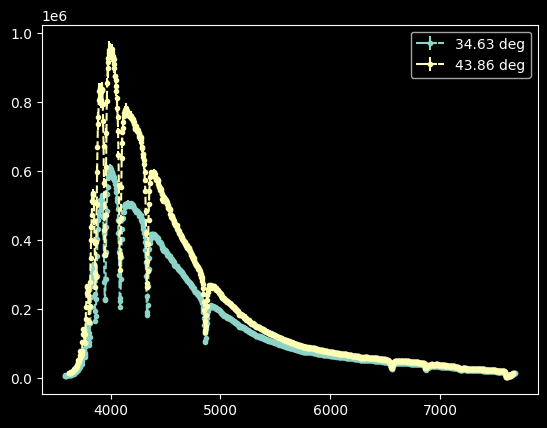

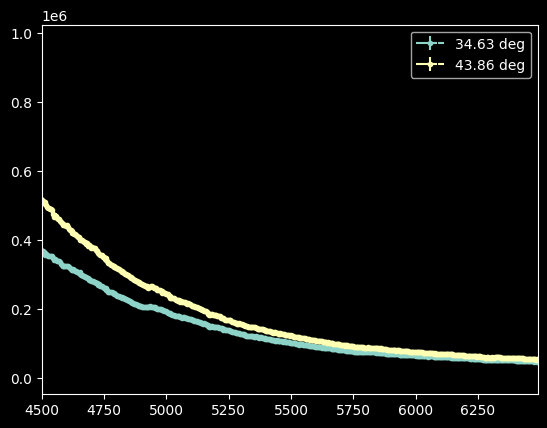

In [ ]:

### DATA
# initialize variables
targets: list[spc.Spectrum] = []    #: list of data
vega:    list[spc.Spectrum] = []    #: list of spectra after balmer's removal
spans = []  #: list of each extraction region width
alt  = np.array([])  #: array of altitudes
Dalt = np.array([])  #: array of the uncertainty in them 
# collect data
for i in [2,3]:
    tmp, _ = spc.calibration(NIGHT,TARGET_NAME+f'0{i}',SELECTION, norm=False, other_lamp=cal_lamp, display_plots=False,diagn_plots=diagn_plots)
    # store data
    spans   += [tmp.span]
    targets += [tmp.copy()]

## Spectrum Extraction
wlen_gap = [
    [[4805,4924],[6520,6690]],
    [[4790,4910],[6520,6690]]
]
min_span = np.min(spans)    #: minimum width
for i in range(len(targets)):
    tag = targets[i].copy()
    # take data inside a section wide `min_span`
    span = slice(tag.cen-min_span,tag.cen+min_span+1)
    data = tag.data[span].copy()
    tag.spec = np.sum(data,axis=0)
    # set the uncertainty to semi-dispersion
    cen_val = data[min_span]
    tag.std = np.mean([abs(cen_val - data[0]),abs(cen_val - data[-1])],axis=0)
    # update data
    targets[i] = tag.copy()
    # remove Balmer's lines
    tag.spec = remove_balmer(tag.lines, tag.spec,wlen_gap=wlen_gap[i],display_plots=display_plots,xlim=WLEN_ENDS)
    vega += [tag.copy()]
    # extract observation site information
    if isinstance(tag.header,list):
        lat = tag.header[0]['SITELAT'] 
        lon = tag.header[0]['SITELONG']
    else:
        lat = tag.header['SITELAT'] 
        lon = tag.header['SITELONG']
    lat, lon = compute_pos(lat,lon)
    print(tag.name,'\tPOS:',lat,lon)
    obs = EarthLocation(lat=lat,lon=lon)
    # compute sky coordinates of Vega
    obj = SkyCoord.from_name('alf Lyr')
    # compute the altitude and the airmass on the observation date
    if isinstance(tag.header,list):
        estalt = []
        for h in tag.header:
            time = Time(h['DATE-OBS'])
            coord = obj.transform_to(AltAz(obstime=time,location=obs))
            print('ALT',coord.alt)
            estalt += [coord.alt.value]
        Destalt = (np.max(estalt)-np.min(estalt))/ 2
        estalt = np.mean(estalt)   
    else:
        time = Time(tag.header['DATE-OBS'])
        coord = obj.transform_to(AltAz(obstime=time,location=obs))
        print('ALT',coord.alt)
        estalt = coord.alt.value
        # set an uncertainty a priori
        Destalt = 0.02
    print(tag.name,'\tALT:',estalt, Destalt)
    # store the results
    alt  = np.append(alt,[estalt])
    Dalt = np.append(Dalt,[Destalt])

fig1, ax1 = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)
for tg, veg, a in zip(targets,vega,alt):
    tmp_tgdata = tg.spectral_data(True) 
    tmp_data = veg.spectral_data(True)
    ax1.errorbar(*tmp_tgdata,fmt='.',linestyle='dashed',label=f'{a:.2f} deg')
    ax2.errorbar(*tmp_data,fmt='.',linestyle='dashed',label=f'{a:.2f} deg')
ax1.legend()
ax2.set_xlim(*WLEN_ENDS)
ax2.legend()
plt.show()


-- RESPONSE FUNCTION --
[4500. 4550. 4600. 4650. 4700. 4750. 4800. 4850. 4900. 4950. 5000. 5050.
 5100. 5150. 5200. 5250. 5300. 5350. 5400. 5450. 5500. 5550. 5600. 5650.
 5700. 5750. 5800. 5850. 5900. 5950. 6000. 6050. 6100. 6150. 6200. 6250.
 6300. 6350. 6400. 6450. 6500.]
EDGES [4500. 6500.]
[4500. 4550. 4600. 4650. 4700. 4750. 4800. 4850. 4900. 4950. 5000. 5050.
 5100. 5150. 5200. 5250. 5300. 5350. 5400. 5450. 5500. 5550. 5600. 5650.
 5700. 5750. 5800. 5850. 5900. 5950. 6000. 6050. 6100. 6150. 6200. 6250.
 6300. 6350. 6400. 6450. 6500.]
EDGES [4500. 6500.]


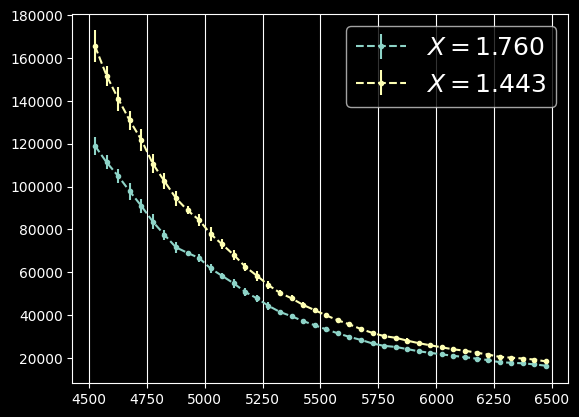

In [ ]:

### RESPONSE FUNCTION
print('-- RESPONSE FUNCTION --')

BIN_WIDTH = 50
# wlen, rfunc, tau = spc.ccd_response((alt, Dalt), vega, WLEN_ENDS, bin_width=bin_width,display_plots=True,diagn_plots=True)
x  = 1/np.sin(alt*np.pi/180)
Dx = Dalt * np.cos(alt*np.pi/180) * x**2 * np.pi/180 
unbin_wlen  = []
unbin  = []
ydata  = []
Dydata = []
for obs in vega:
    obs = obs.copy()        
    exp_time = obs.get_exposure()
    obs.spec = obs.spec / exp_time
    unbin_wlen += [obs.lines[wl_lim(obs.lines)]]
    unbin += [obs.spec[wl_lim(obs.lines)]]
    obs.std  = obs.std  / exp_time if obs.std is not None else None
    (wlen, Dwlen), (bin_spec, Dbin_spec), bins = obs.binning(bin=BIN_WIDTH,edges=WLEN_ENDS)
    ydata  += [bin_spec]
    Dydata += [Dbin_spec]

plt.figure()
plt.errorbar(wlen,ydata[0],Dydata[0],fmt='.--',label=f'$X = {x[0]:.3f}$')    
plt.errorbar(wlen,ydata[1],Dydata[1],fmt='.--',label=f'$X = {x[1]:.3f}$')
plt.grid(True,which='both',axis='x')
plt.legend(fontsize=FONTSIZE)
plt.show()    


curve_fit
XERR None

Fit results:
	mode : curve_fit
	par0: -8.37e-04 +/- 5.8e-05  -->  6.97 %	init : -0.0001
	par1: 4.268e+03 +/- 1.8e+01  -->  0.42 %	init : 4.6e+03
	par2: 2.19e-01 +/- 2.5e-02  -->  11.49 %	init : 0.37
	corr_par0-par1	 = 0.36
	corr_par0-par2	 = -0.98
	corr_par1-par2	 = -0.52


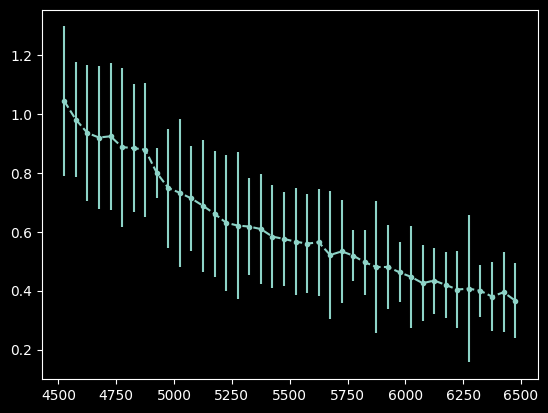

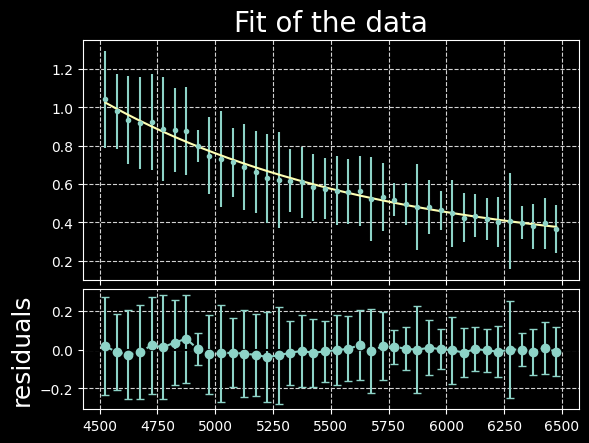

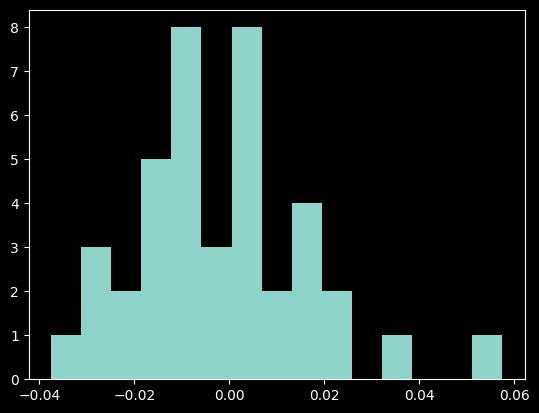

In [ ]:

# Ii = exp(-tau xi) S R
# I1/I2 = exp(-tau (x1-x2))
# ln(I1/I2) = -tau * (x1-x2)
# tau = ln(I1/I2)/(x2-x1)
# Dtau = [DI1/I1 + DI2/I2 + ln(I1/I2)/(x2-x1)*(Dx1+Dx2)]/(x2-x1) 
tau  = np.log(ydata[1]/ydata[0]) / (x[0]-x[1])
Dtau = (Dydata[1]/ydata[1] + Dydata[0]/ydata[0] + tau*(Dx[1]+Dx[0]))/(x[0]-x[1])
plt.figure()
plt.errorbar(wlen,tau,Dtau,fmt='.--')
# plt.show()

def fit_func(x, *params):
    b,c,d = params
    return np.exp(b*(x-c)) + d
initial_values = [-1e-4,wlen[1],tau.min()]
fit = spc.FuncFit(xdata=wlen,ydata=tau,yerr=Dtau)
fit.pipeline(fit_func,initial_values)
fit.plot(mode='subplots')
plt.figure()
plt.hist(fit.residuals(),15)
plt.show()    


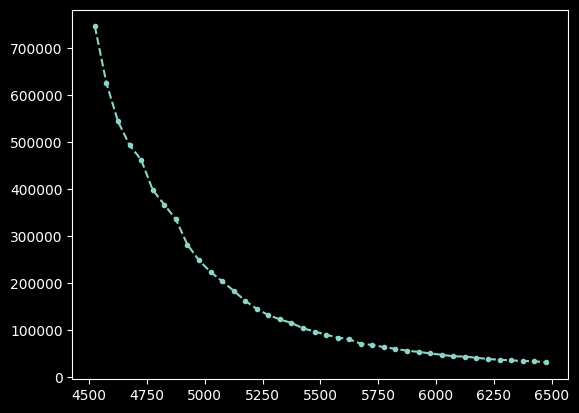

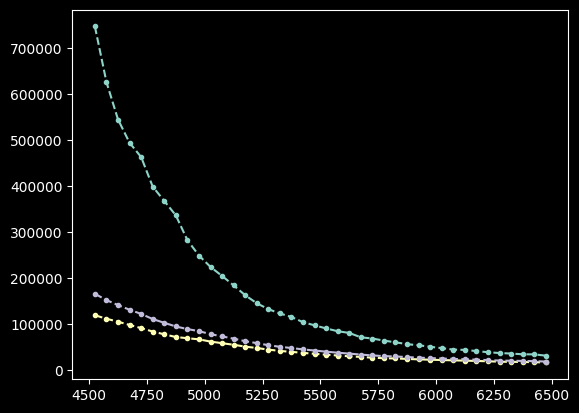

[4500. 4550. 4600. 4650. 4700. 4750. 4800. 4850. 4900. 4950. 5000. 5050.
 5100. 5150. 5200. 5250. 5300. 5350. 5400. 5450. 5500. 5550. 5600. 5650.
 5700. 5750. 5800. 5850. 5900. 5950. 6000. 6050. 6100. 6150. 6200. 6250.
 6300. 6350. 6400. 6450. 6500.]
EDGES [4500. 6500.]


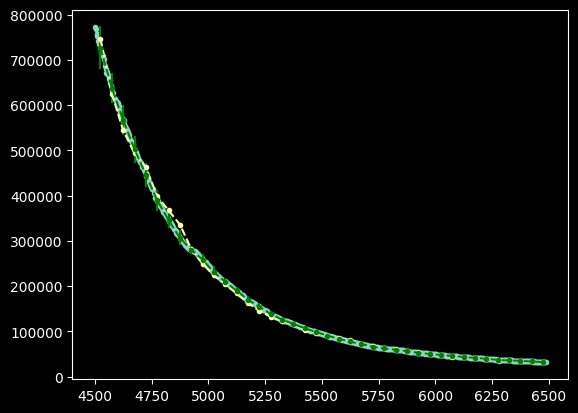

In [ ]:

# ln(I) = -tau x + ln(SR)
# ln(SR) = ln(Ii) + tau xi

Sigma = [ydata[i]*np.exp(tau*x[i]) for i in range(2) ]
DSigma = abs(Sigma[1]-Sigma[0])/2
Sigma = np.mean(Sigma,axis=0)
plt.errorbar(wlen,Sigma,DSigma,fmt='.--')
plt.figure()
plt.errorbar(wlen,Sigma,DSigma,fmt='.--')
plt.plot(wlen,ydata[0],'.--') 
plt.plot(wlen,ydata[1],'.--')
plt.show() 


ends = (max(unbin_wlen[0][0],unbin_wlen[1][0]),min(unbin_wlen[0][-1],unbin_wlen[1][-1]))
for i in range(2):
    wlen_i = unbin_wlen[i] 
    sel_pos = (wlen_i >= ends[0]) & (wlen_i <= ends[1])
    unbin_wlen[i] = wlen_i[sel_pos]
    unbin[i] = unbin[i][sel_pos]
unbin_wlen = unbin_wlen[0]
unbin_S = np.mean([unbin[i] * np.exp(fit_func(unbin_wlen,*fit.fit_par)*x[i]) for i in range(2)],axis=0)
plt.figure()
plt.plot(unbin_wlen,unbin_S,'.--')
plt.errorbar(wlen,Sigma,DSigma,fmt='.--')

(wlen,Dwlen),(Sigma, DSigma), bins = spc.binning(unbin_S,unbin_wlen,bins)
plt.errorbar(wlen,Sigma,DSigma,fmt='.--',color='green')
plt.show()


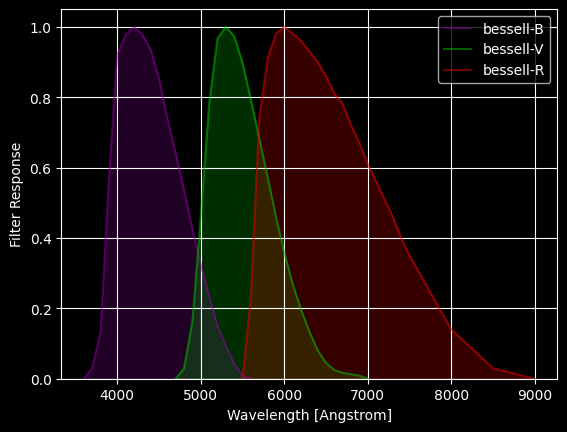

Prev (40,) (59,) (59,)
Foll 6475.0 7025.0 7000.0
Foll 6475.0 9025.0 9000.0
[3.6627728690812137e+19, 2.7563030478508503e+19, 1.1718324681183582e+19]
[-9.06469821e+18 -1.58447058e+19]
2.4909404009628557e+19


In [ ]:

from speclite import filters

blue = filters.load_filter('bessell-B')
visible = filters.load_filter('bessell-V')
red = filters.load_filter('bessell-R')
filters.plot_filters(filters.load_filters('bessell-B','bessell-V','bessell-R'))
plt.plot(wlen,Sigma)
plt.show()
index_col = []
for filt in [blue,visible,red]:
    tmp_wlen = wlen.copy()
    tmp_data = Sigma.copy()
    filt_wlen = filt.wavelength.copy()
    prv_pos = np.where(tmp_wlen <= filt_wlen[0])[0]
    if len(prv_pos) == 0:
        bin_diff = (wlen[0]-filt_wlen[0])
        bin_diff = bin_diff//BIN_WIDTH if bin_diff%BIN_WIDTH==0 else bin_diff//BIN_WIDTH+1
        bin_diff = bin_diff.astype(int)
        tmp_wlen = np.append(np.linspace(wlen[0]-bin_diff*BIN_WIDTH,wlen[0]-BIN_WIDTH,bin_diff),tmp_wlen)
        tmp_data = np.append([0]*bin_diff,tmp_data)
        print('Prev',wlen.shape,tmp_wlen.shape,tmp_data.shape)
    else:
        tmp_wlen = tmp_wlen[prv_pos[-1]:]
        tmp_data = tmp_data[prv_pos[-1]:]
    fll_pos = np.where(tmp_wlen >= filt_wlen[-1])[0]
    if len(fll_pos) == 0:
        bin_diff = (filt_wlen[-1]-wlen[-1])
        bin_diff = bin_diff//BIN_WIDTH if bin_diff%BIN_WIDTH==0 else bin_diff//BIN_WIDTH+1
        bin_diff = bin_diff.astype(int)
        tmp_wlen = np.append(tmp_wlen,np.linspace(wlen[-1]+BIN_WIDTH,wlen[-1]+BIN_WIDTH*bin_diff,bin_diff))
        tmp_data = np.append(tmp_data,[0]*bin_diff)
        print('Foll',wlen[-1],tmp_wlen[-1],filt_wlen[-1])
    else:
        tmp_wlen = tmp_wlen[:fll_pos[0]+1]
        tmp_data = tmp_data[:fll_pos[0]+1]
    
    index_col += [filt.convolve_with_array(tmp_wlen,tmp_data)]
print(index_col)
blue, visible, red = index_col 
print(np.diff(index_col))
print(blue-red)

# print(np.shape(blue.convolve_with_array(wlen,Sigma)))

[4500. 4550. 4600. 4650. 4700. 4750. 4800. 4850. 4900. 4950. 5000. 5050.
 5100. 5150. 5200. 5250. 5300. 5350. 5400. 5450. 5500. 5550. 5600. 5650.
 5700. 5750. 5800. 5850. 5900. 5950. 6000. 6050. 6100. 6150. 6200. 6250.
 6300. 6350. 6400. 6450. 6500.]
EDGES [4500. 6500.]


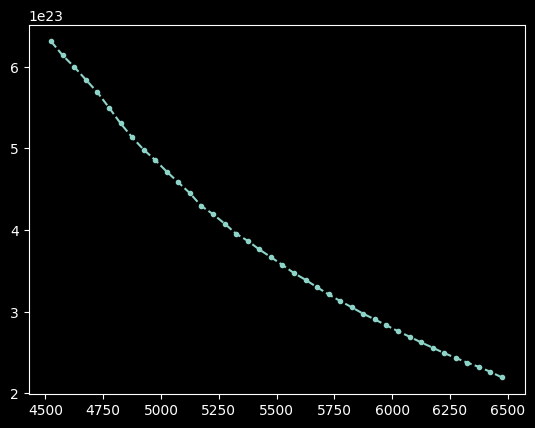

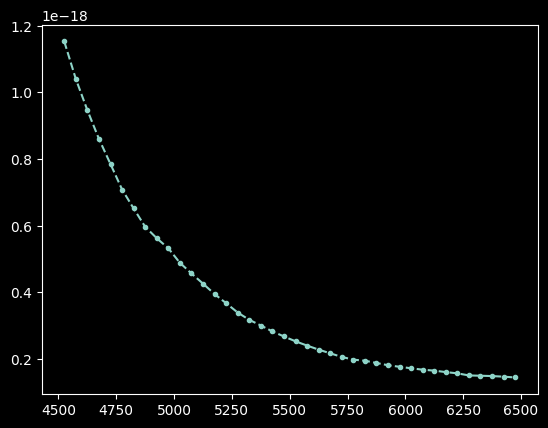

In [ ]:
(_,_),(std_spec,_) = spc.vega_std(bins)
plt.plot(wlen,std_spec,'.--')
response = Sigma/std_spec
plt.figure()
plt.plot(wlen,response,'.--')

[4500. 4550. 4600. 4650. 4700. 4750. 4800. 4850. 4900. 4950. 5000. 5050.
 5100. 5150. 5200. 5250. 5300. 5350. 5400. 5450. 5500. 5550. 5600. 5650.
 5700. 5750. 5800. 5850. 5900. 5950. 6000. 6050. 6100. 6150. 6200. 6250.
 6300. 6350. 6400. 6450. 6500.]
EDGES [4500. 6500.]
[4500. 4550. 4600. 4650. 4700. 4750. 4800. 4850. 4900. 4950. 5000. 5050.
 5100. 5150. 5200. 5250. 5300. 5350. 5400. 5450. 5500. 5550. 5600. 5650.
 5700. 5750. 5800. 5850. 5900. 5950. 6000. 6050. 6100. 6150. 6200. 6250.
 6300. 6350. 6400. 6450. 6500.]
EDGES [4500. 6500.]
[4500. 4550. 4600. 4650. 4700. 4750. 4800. 4850. 4900. 4950. 5000. 5050.
 5100. 5150. 5200. 5250. 5300. 5350. 5400. 5450. 5500. 5550. 5600. 5650.
 5700. 5750. 5800. 5850. 5900. 5950. 6000. 6050. 6100. 6150. 6200. 6250.
 6300. 6350. 6400. 6450. 6500.]
EDGES [4500. 6500.]


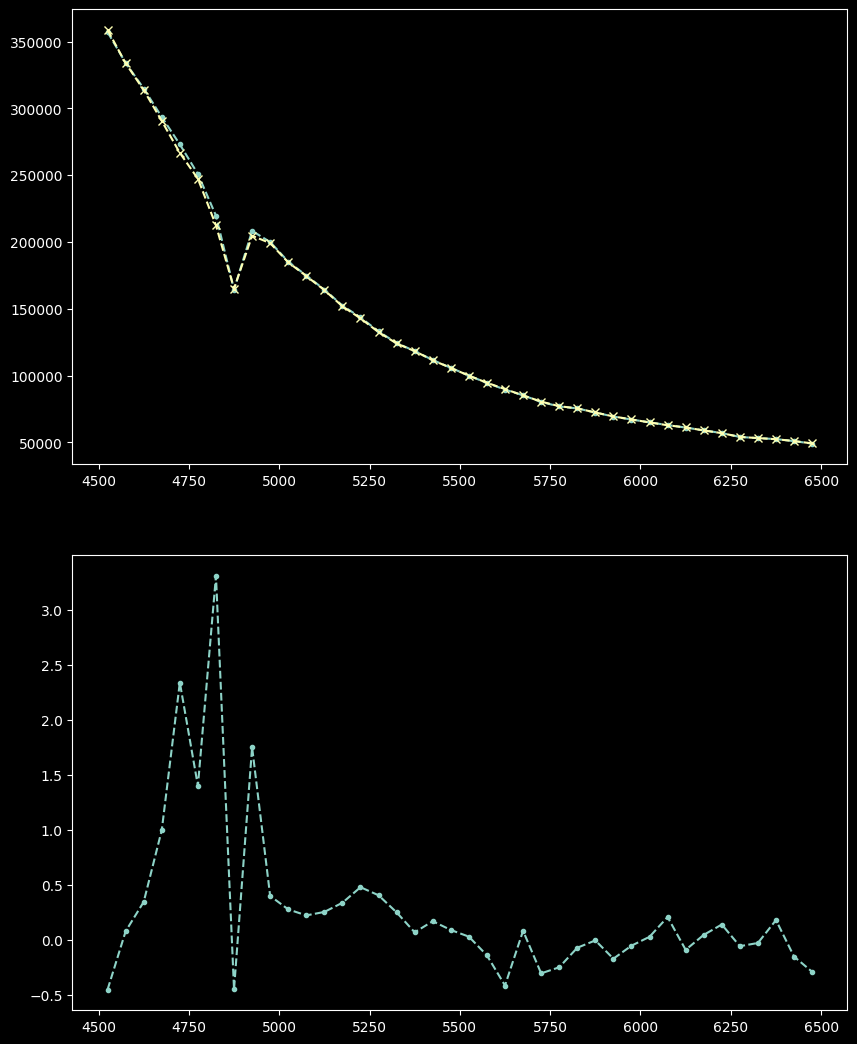

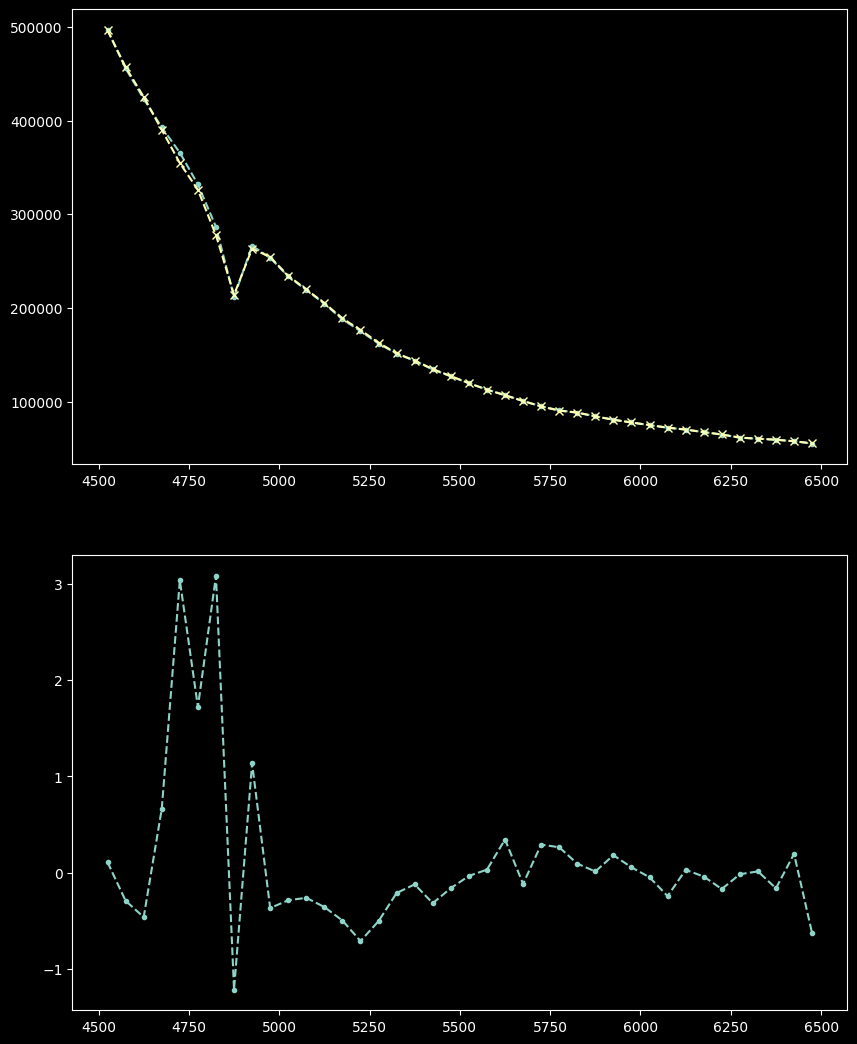

In [ ]:
from scipy.interpolate import CubicSpline

_, (std_spec,_) = spc.vega_std(bins,balmer_rem=False)

int_response = CubicSpline(wlen,response)

for obs,airmass in zip(targets,x):
    est_tau = fit.method(wlen)
    exp_time = obs.get_exposure()
    rec_spec = np.exp(-est_tau*airmass)*std_spec*exp_time*response
    _, (obs_sp,_),_ = obs.binning(bins)
    plt.figure(figsize=(10,13))
    plt.subplot(2,1,1)
    plt.plot(wlen,obs_sp,'.--')
    plt.plot(wlen,rec_spec,'x--')
    plt.subplot(2,1,2)
    plt.plot(wlen,(obs_sp-rec_spec)/obs_sp*100,'.--')



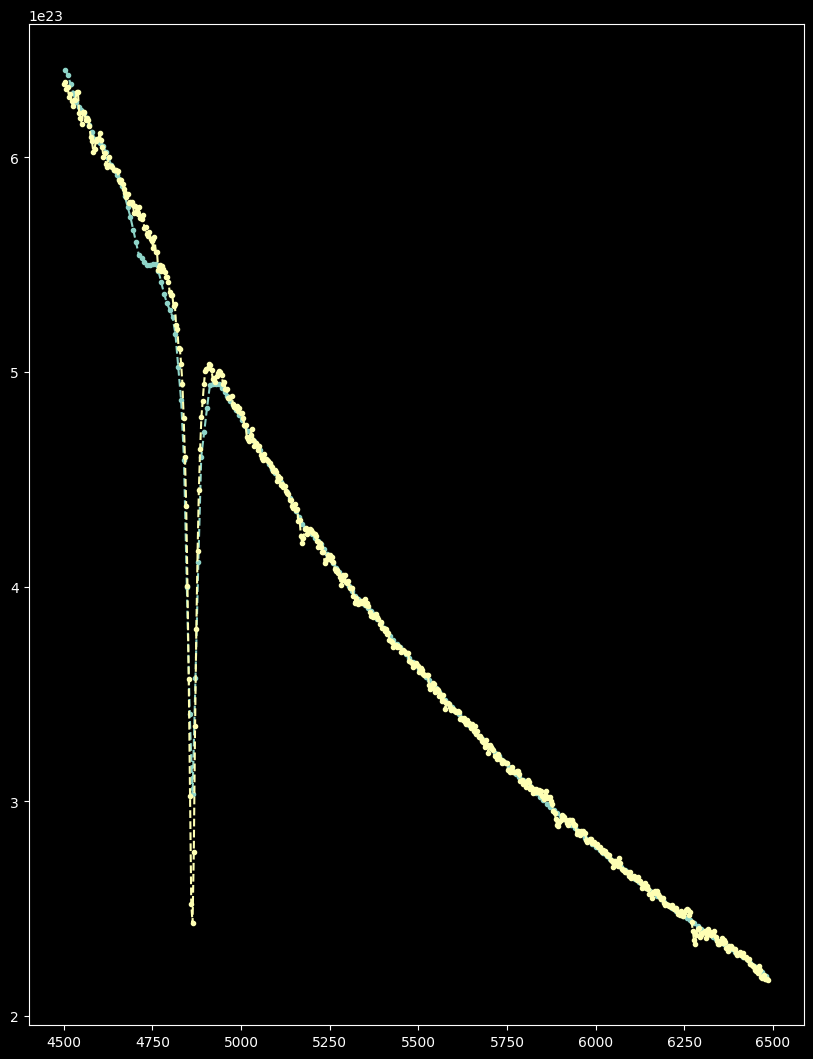

[4500. 4550. 4600. 4650. 4700. 4750. 4800. 4850. 4900. 4950. 5000. 5050.
 5100. 5150. 5200. 5250. 5300. 5350. 5400. 5450. 5500. 5550. 5600. 5650.
 5700. 5750. 5800. 5850. 5900. 5950. 6000. 6050. 6100. 6150. 6200. 6250.
 6300. 6350. 6400. 6450. 6500.]
EDGES [4500. 6500.]
[4500. 4550. 4600. 4650. 4700. 4750. 4800. 4850. 4900. 4950. 5000. 5050.
 5100. 5150. 5200. 5250. 5300. 5350. 5400. 5450. 5500. 5550. 5600. 5650.
 5700. 5750. 5800. 5850. 5900. 5950. 6000. 6050. 6100. 6150. 6200. 6250.
 6300. 6350. 6400. 6450. 6500.]
EDGES [4500. 6500.]
3.3693264304929964
0.04759701051268784
0.15812844414028054 -0.31466859686995424


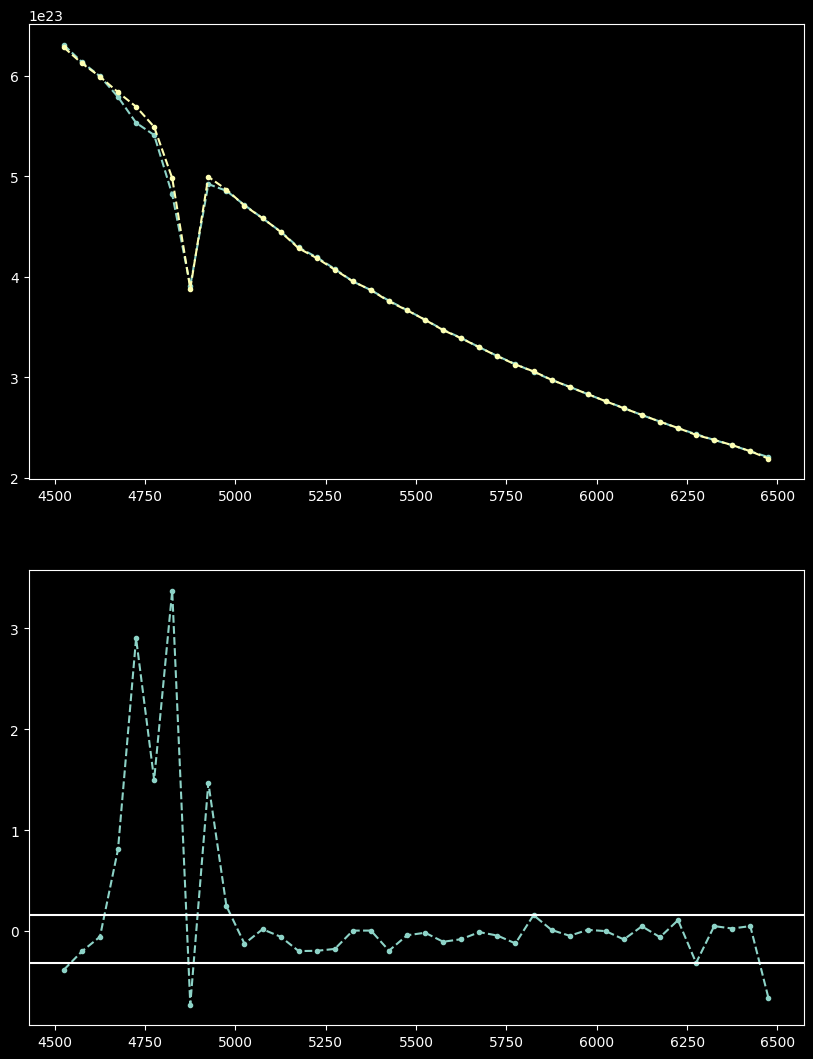

In [ ]:

avg_abssp = 0
for obs, airmass in zip(targets,x):
    wave = obs.lines[wl_lim(obs.lines)]
    sp_data = obs.spec[wl_lim(obs.lines)]
    ext_tau = fit.method(wave)
    exp_time = obs.get_exposure()
    rec_sp  = sp_data * np.exp(ext_tau*airmass) / int_response(wave) / exp_time
    avg_abssp += rec_sp
avg_abssp /= 2

std_wl, std_sp = spc.get_standard()
std_sp = std_sp[wl_lim(std_wl)]
std_wl = std_wl[wl_lim(std_wl)]
plt.figure(figsize=(10,13))
plt.plot(std_wl,std_sp,'.--')
plt.plot(wave,avg_abssp,'.--')
plt.show()

(std_wl,_),(std_sp,_), _ = spc.binning(std_sp,std_wl,bins)
(bin_wl,_),(bin_sp,_), _ = spc.binning(avg_abssp,wave,bins)
norm_diff = (bin_sp-std_sp)/std_sp*100
avg_diff = np.mean(norm_diff[bin_wl>5000][:-1])
print(norm_diff.max())
print(abs(avg_diff))
print(norm_diff[bin_wl>5000][:-1].max(),norm_diff[bin_wl>5000][:-1].min())
plt.figure(figsize=(10,13))
plt.subplot(2,1,1)
plt.plot(std_wl,std_sp,'.--')
plt.plot(bin_wl,bin_sp,'.--')
plt.subplot(2,1,2)
plt.plot(bin_wl,(bin_sp-std_sp)/std_sp*100,'.--')
plt.axhline(norm_diff[bin_wl>5000][:-1].max(),0,1)
plt.axhline(norm_diff[bin_wl>5000][:-1].min(),0,1)
plt.show()





In [ ]:
## Regolo
regolo, _ = spc.calibration(NIGHT,'Regolo',0,'alf Leo',other_lamp=cal_lamp,norm=False,display_plots=False)


Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/17-03-27/Regolo/Regolo-0015sec.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (1392, 1040)   int16 (rescales to uint16)   
NEWS [408 475 240 None] [430 460 232 1371]
Start [430 460 232 1371]
N = 1040
K = 1
[430 460 232 1371]
Start [430 460 232 1371]
N = 1392
K = 3
[430 460 232 1371]
Start [408 475 240 None]
N = 1040
K = 1
[408 475 240 None]
Start [408 475 240 None]
N = 1392
K = 3
[408 475 240 1392]
 - HEADER -
SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 1392 /fastest changing axis                           
NAXIS2  =                 1040 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000

[4500. 4550. 4600. 4650. 4700. 4750. 4800. 4850. 4900. 4950. 5000. 5050.
 5100. 5150. 5200. 5250. 5300. 5350. 5400. 5450. 5500. 5550. 5600. 5650.
 5700. 5750. 5800. 5850. 5900. 5950. 6000. 6050. 6100. 6150. 6200. 6250.
 6300. 6350. 6400. 6450. 6500.]
EDGES [4500. 6500.]
alf Leo 	POS: 42.93277777777777 deg 10.498055555555554 deg
ALT 53d01m05.02590628s
Vega03 	ALT: 53.01806275174495 0.02 1.251838332029716


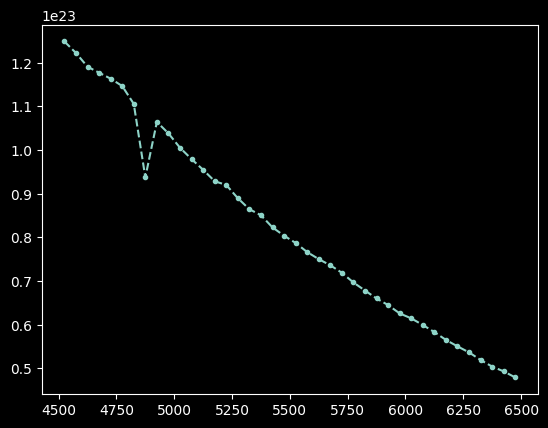

In [ ]:

(reg_wlen,_),(reg_spec,_),_ = regolo.binning(bins)
reg_time = regolo.get_exposure()
# extract observation site information
lat = regolo.header['SITELAT'] 
lon = regolo.header['SITELONG']
lat, lon = compute_pos(lat,lon)
print(regolo.name,'\tPOS:',lat,lon)
obs = EarthLocation(lat=lat,lon=lon)
# compute sky coordinates of Vega
obj = SkyCoord.from_name(regolo.name)
# compute the altitude and the airmass on the observation date
time = Time(regolo.header['DATE-OBS'])
coord = obj.transform_to(AltAz(obstime=time,location=obs))
print('ALT',coord.alt)
reg_alt = coord.alt.value
# set an uncertainty a priori
Dreg_alt = 0.02
reg_x = 1/np.sin(reg_alt*np.pi/180)
print(tag.name,'\tALT:',reg_alt, Dreg_alt, reg_x)

reg_absspec = reg_spec * np.exp(est_tau*reg_x) / reg_time /response
plt.figure()
plt.plot(wlen,reg_absspec,'.--')


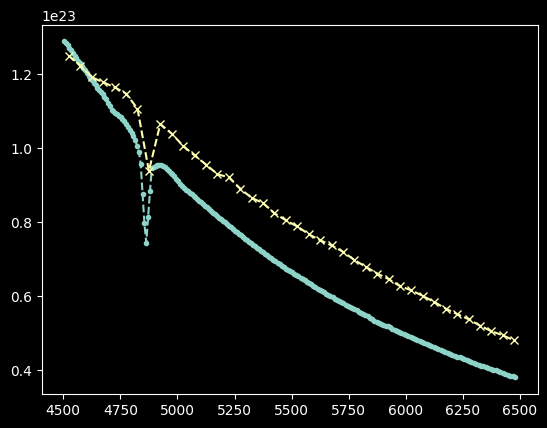

In [ ]:
b_path = spc.data.os.path.join(spc.data.CAL_DIR,'standards','etaUMa','eta_uma.txt')
# b_path = spc.data.os.path.join(spc.data.CAL_DIR,'standards','zetCas','zet_cas.txt')

b_wlen, b_spec, _ = np.loadtxt(b_path, unpack=True)
b_spec = b_spec[wl_lim(b_wlen)]*1e16
b_wlen = b_wlen[wl_lim(b_wlen)] 
plt.plot(b_wlen,b_spec,'.--') 
plt.plot(wlen,reg_absspec,'x--') 
 

# Jupiter Period Estimation


## Packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import spectralpy as spc
from astropy import units as u
import astropy.constants as const

## Constants

In [18]:
## Constants 
BALMER = 6562.79                        #: H_alpha data from NIST
ERRBAL = 0.03                           #: its uncertainty
R = 71492 * u.km                        #: equat. radius of Jupiter from https://ssd.jpl.nasa.gov/horizons/app.html#/
DR = 4 * u.km                           #: its uncertainty
C = const.c.to(u.m/u.s)                 #: light velocity
PERIOD = (9+55/60+29.711/3600) * u.h    #: Sid. rot. period (III) of Jupiter from https://ssd.jpl.nasa.gov/horizons/app.html#/

## Open Data

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/18-04-22/giove/giove_spec.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (1392, 1040)   int16 (rescales to uint16)   
NEWS [568 791 0 None] [624 735 21 None]
Start [624 735 21 None]
N = 1040
K = 1
[624 735 21 None]
Start [624 735 21 None]
N = 1392
K = 3
[624 735 21 1392]
Start [568 791 0 None]
N = 1040
K = 1
[568 791 0 None]
Start [568 791 0 None]
N = 1392
K = 3
[568 791 0 1392]
 - HEADER -
SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 1392 /fastest changing axis                           
NAXIS2  =                 1040 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO +

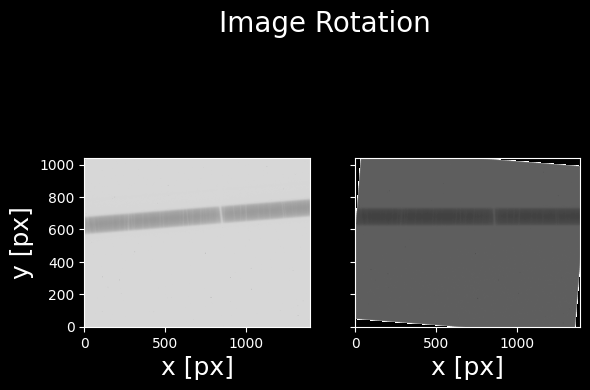

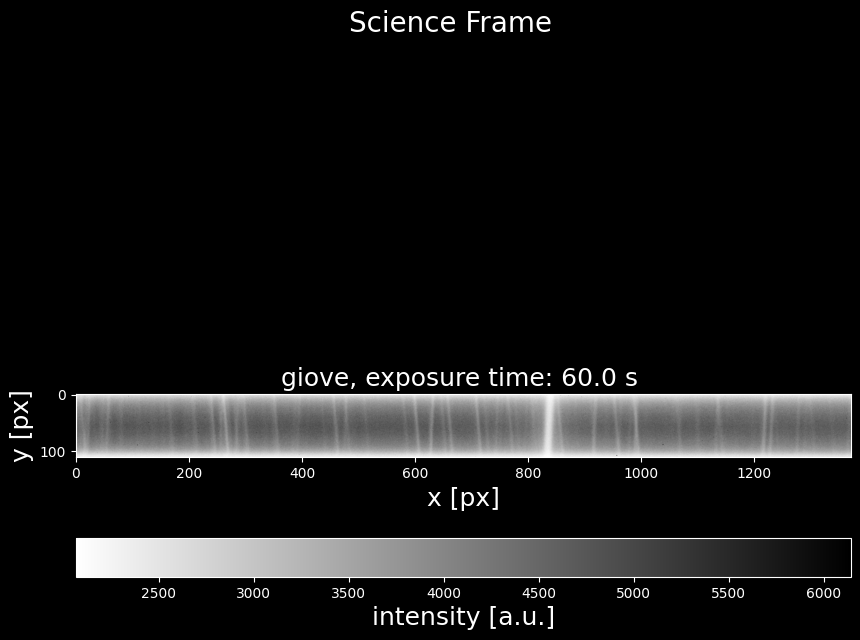

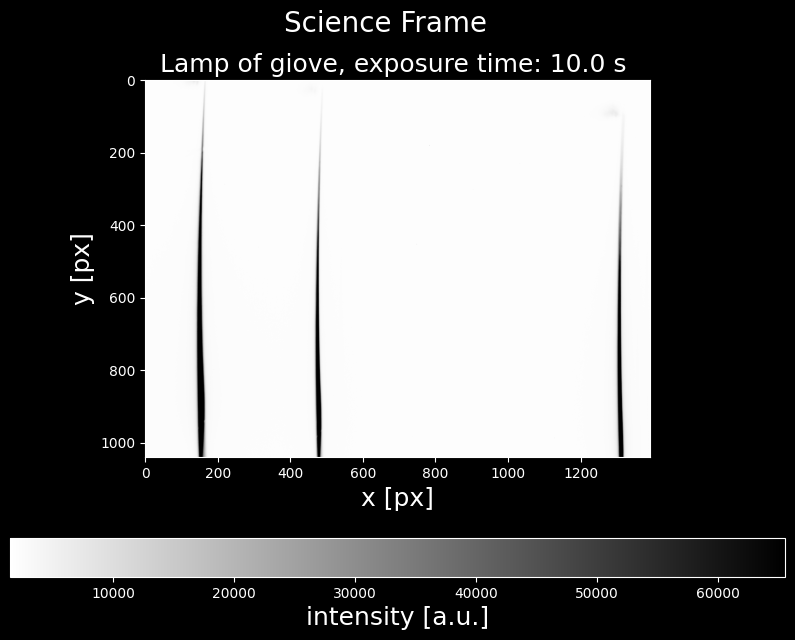

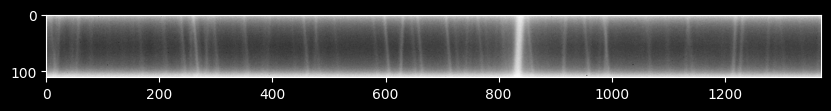

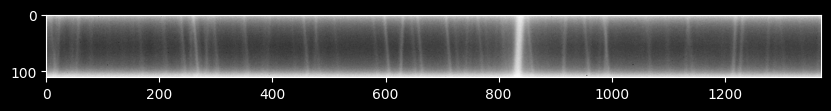

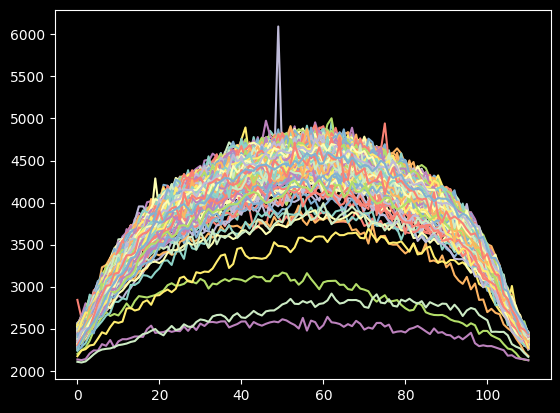

In [19]:
OBS_NIGHT = '18-04-22'
TARGET_NAME = 'giove'    
SELECTION = 0
fit_args = { 'mode': 'odr' }                #: parameters for the fit
lim_width = [[0,1391],[[0,112],[108,221]]]  #: coordinates of the ends of the spectrum
lag = 15                                    #: step length to collect xdata
# open and extract the fit file 
jupiter, lamp = spc.get_target_data(OBS_NIGHT,TARGET_NAME,SELECTION,angle=None,lim_width=lim_width,lag=lag,gauss_corr=False,lamp_incl=False, fit_args=fit_args, diagn_plots=False,norm='log',aspect='equal')


plt.figure(figsize=(10,7))
plt.imshow(jupiter.data,cmap='gray_r',norm='log')
# from scipy.signal import medfilt2d
# data = medfilt2d(jupiter.data.copy())
data = jupiter.data.copy()
plt.figure(figsize=(10,7))
plt.imshow(data,cmap='gray_r',norm='log')
plt.show()

plt.figure()
for i in range(data.shape[1])[::5]:
    plt.plot(data[:,i])
plt.show()


## Inclination Correction

Take a column every `step` pixels, for each one fit a parabola, find the vertecies and fit a line to find the inclination angle


initial_values [4256, 54, 56]
curve_fit
XERR None

Fit results:
	mode : curve_fit
	k: 4243.445953554198 +/- 20.828541160690094  -->  0.49 %	init : 4.3e+03
	mu: 57.424474278548715 +/- 0.3962213974231871  -->  0.69 %	init : 5.4e+01
	sigma: 55.71439672551842 +/- 0.7524122640568743  -->  1.35 %	init : 5.6e+01
	corr_k-mu	 = -0.052
	corr_k-sigma	 = -0.69
	corr_mu-sigma	 = 0.12
initial_values [4472, 66, 44]
curve_fit
XERR None

Fit results:
	mode : curve_fit
	k: 4298.651119544731 +/- 23.034423953101946  -->  0.54 %	init : 4.5e+03
	mu: 56.14744809852253 +/- 0.42889060704085386  -->  0.76 %	init : 6.6e+01
	sigma: 55.6640833488734 +/- 0.818271181352961  -->  1.47 %	init : 4.4e+01
	corr_k-mu	 = -0.025
	corr_k-sigma	 = -0.69
	corr_mu-sigma	 = 0.057
initial_values [4405, 54, 56]
curve_fit
XERR None

Fit results:
	mode : curve_fit
	k: 4368.824960514995 +/- 20.363123538880874  -->  0.47 %	init : 4.4e+03
	mu: 53.95230763594572 +/- 0.36901637310895974  -->  0.68 %	init : 5.4e+01
	sigma: 55.296637322902

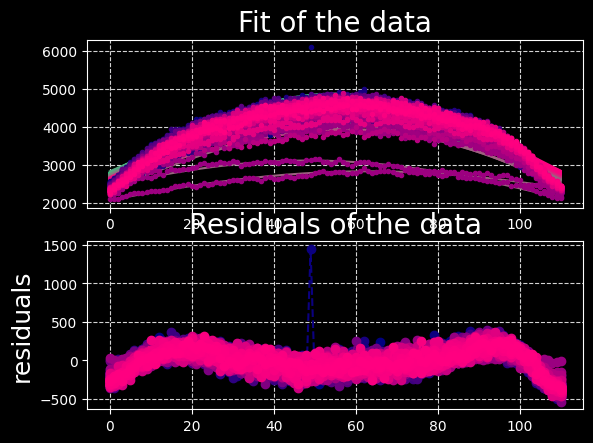

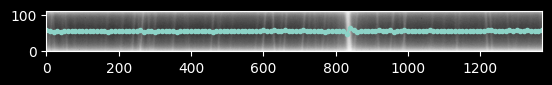

curve_fit
XERR None

Fit results:
	mode : curve_fit
	m: 1.60e-03 +/- 2.4e-04  -->  15.22 %	init : 0.00027
	q: 5.456e+01 +/- 1.9e-01  -->  0.36 %	init : 5.7e+01
	corr_m-q	 = -0.87
[[ 5.95072427e-08 -4.12478822e-05]
 [-4.12478822e-05  3.80061342e-02]]


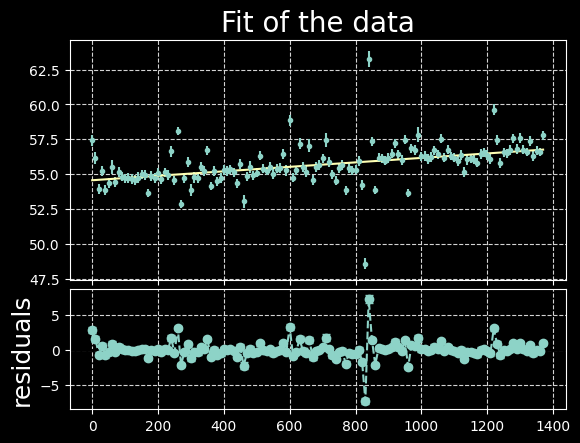

Angle2 = 9.2e-02 +/- 1.4e-02 deg ---> 15.22%
Angle_tot = 4.53e+00 +/- 4.0e-01 deg ---> 8.87%


In [20]:
## Parabola Fits
step = 10
N = data.shape[1]                   #: image horizontal size
col = np.arange(N)[::step]          #: selected columns
v  = []                             #: vertex coordinates of the parabolas for each column
Dv = []                             #: their uncertainties
xdata = np.arange(data.shape[0])
fig, ax = plt.subplots(2,1)
for i in col:
    ydata = data[:,i]
    fit = spc.FuncFit(xdata=xdata,ydata=ydata)
    hm = ydata.max()/2
    hm_pos = np.argmin(abs(hm-ydata))
    hwhm = abs(ydata.argmax()-hm_pos)
    initial_values = [ydata.max(),ydata.argmax(),hwhm]
    print('initial_values',initial_values)
    fit.gaussian_fit(initial_values)
    v  += [fit.fit_par[1]]
    Dv += [fit.fit_err[1]]
    # # fit a parabola
    # fit = spc.FuncFit(xdata=xdata,ydata=ydata,xerr=1)
    # fit.pol_fit(2,[-0.2,1,1],mode='curve_fit')
    # # extract the parameters and the covariances
    # a,b,c = fit.fit_par
    # cov = fit.res['cov']
    # delta = b**2 - 4*a*c
    # # compute the uncertainty related with the estimated vertex value
    # der = [ b/(2*a**2),
    #         -1/(2*a) ]
    # err = np.sqrt(np.sum([der[j]*der[k]*cov[j,k] for k in range(len(der)) for j in range(len(der))]))
    # # store the results
    # v  += [-b/2/a]
    # Dv += [err]
    # # plot
    color1 = (i/N,0,0.5)
    color2 = (i/N,1-i/N,0.5)
    fit.data_plot(ax[0],pltarg1={'color':color1},pltarg2={'color':color2})
    fit.residuals_plot(ax[1],color=color1)
plt.figure()
plt.imshow(data,origin='lower',norm='log',cmap='gray_r')
plt.errorbar(col,v,Dv,fmt='.-')
plt.show()

## Linear Fit
fit = spc.FuncFit(xdata=col,ydata=v,yerr=Dv)
fit.linear_fit(mode='curve_fit')
fit.plot(mode='subplots')
plt.show()
m  = fit.fit_par[0]
Dm = fit.fit_err[0]

# compute the inclination angle
angle  = np.arctan(m) * 180/np.pi
Dangle = Dm/(1+m**2)  * 180/np.pi
# print the value with the correct digits
spc.print_measure(angle,Dangle,'Angle2','deg')

# compute the total inclination angle
angle  = jupiter.angle[0] + angle
Dangle = np.sqrt(jupiter.angle[1]**2 + Dangle**2)
spc.print_measure(angle,Dangle,'Angle_tot','deg')
# rotate the image
jupiter.data = jupiter.hdul[0].data.copy()
jupiter = jupiter.rotate_target(angle)


In [ ]:
plt.plot(jupiter.)

## Period Estimation

$$ T = 8\pi \frac{R_J}{c} \frac{\lambda}{\Delta\lambda} \frac{x}{R_{px}} $$

In [21]:

#? CHECK RICC
jupiter.data = jupiter.data[:,::-1]
jupiter.lims = jupiter.lims[:2] + [jupiter.data.shape[1] - jupiter.lims[3],jupiter.data.shape[1] - jupiter.lims[2] ]

#?


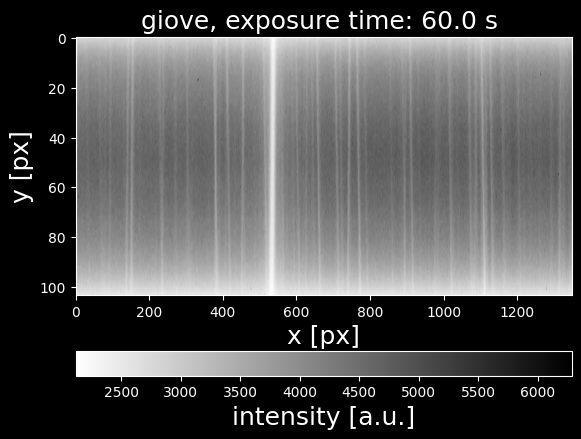

curve_fit
XERR [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Fit results:
	mode : curve_fit
	k: 4.4802e+03 +/- 7.8e+00  -->  0.17 %	init : 4.6e+03
	mu: 4.767e+01 +/- 3.9e-01  -->  0.82 %	init : 5.2e+01
	sigma: 5.701e+01 +/- 6.7e-01  -->  1.18 %	init : 2.0
	corr_k-mu	 = 0.035
	corr_k-sigma	 = -0.38
	corr_mu-sigma	 = -0.17
curve_fit
XERR [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Fit results:
	mode : curve_fit
	k: 4.6616e+03 +/- 9.7e+00  -->  0.21 %	init : 4.7e+03
	mu: 4.923e+01 +/- 4.6e-01  -->  0.94 %	init : 5.2e+01
	sigma: 5.517e+01 +/- 7.7e-01  -->  1.39 %	init : 2.0
	corr_k-mu	 = 0.025
	corr_k-sigma	 = -0.36
	corr_mu-sigma	 = -0.1
curve_fit
XERR [1 1 1

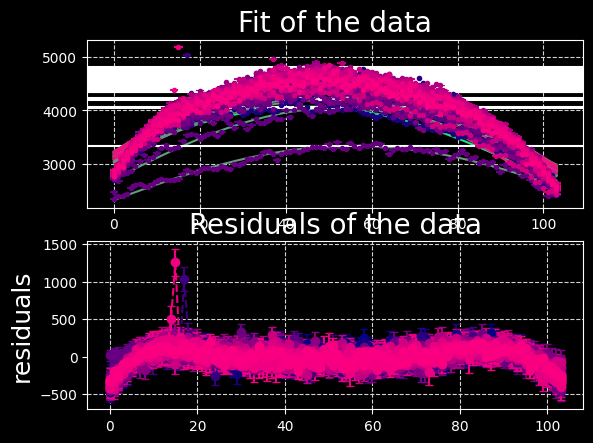

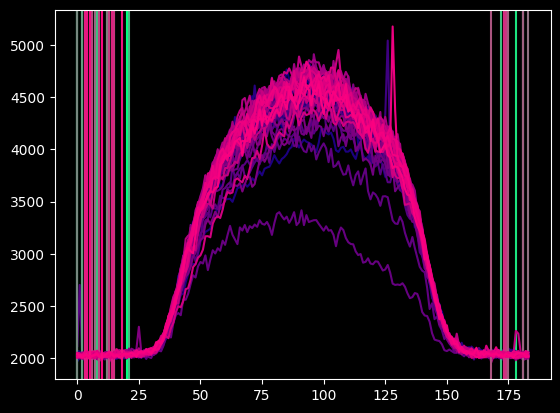

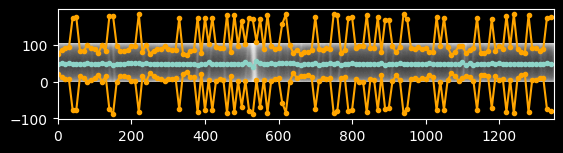

Centre = 4.857e+01 +/- 1.3e-01 pxs ---> 0.27%
Radius = 6.39e+01 +/- 3.5e+00 pxs ---> 5.40%


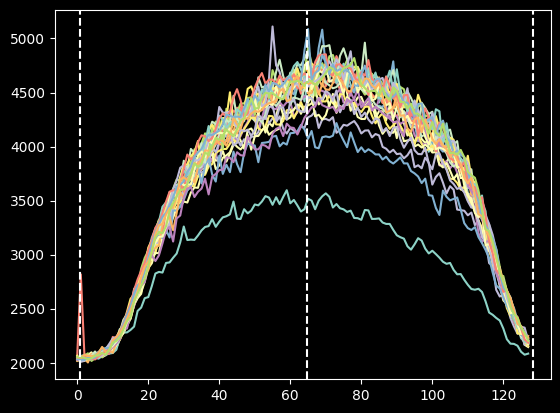

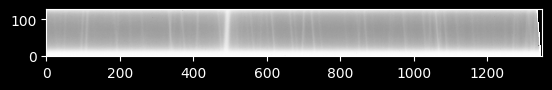

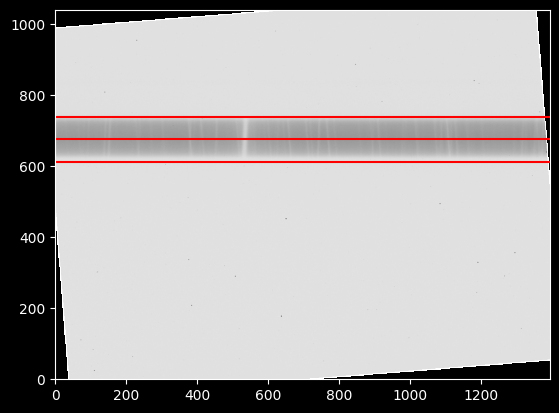

In [9]:

# store data before slicing
uncut_data = jupiter.data.copy()
cp_jup = jupiter.copy()
# ends of the slice
cp_jup.lims = [626,730,42,1391]
#? CHECK RICC
cp_jup.lims = [626,730,lamp.data.shape[-1]-1391,lamp.data.shape[-1]-42]
#?
cp_jup.cut_image()
#? CHECK RICC
cp_jup.data = cp_jup.data[::-1,:]
#?
data = cp_jup.data.copy()

fig,ax = plt.subplots(1,1)
spc.fits_image(fig,ax,cp_jup)
plt.show()

## Gaussian Fit 
step = 10
N = data.shape[1]                   #: image horizontal size
col = np.arange(N)[::step]          #: selected columns
c  = []                             #: coordinates of the centre for each column
Dc = []                             #: their uncertainties
r  = []                             #: radius estimations for each column
Dr = []                             #: their uncertainties
xdata = np.arange(data.shape[0])
# extend the ends of the sliced data 
ext_data = uncut_data[cp_jup.lims[0]-40 : cp_jup.lims[1]+40, cp_jup.lims[2]:].copy()
fig, ax = plt.subplots(2,1)
fig0, ax0 = plt.subplots(1,1)
for i in col:
    ydata = data[:,i]
    # fit a Gaussian
    fit = spc.FuncFit(xdata=xdata,ydata=ydata,xerr=1)
    fit.gaussian_fit([ydata.max(),xdata.mean(),2],mode='curve_fit')
    # extract the estimated paramters
    k,mu = fit.fit_par[:2]
    Dk,Dmu = fit.fit_err[:2]
    # store the center value
    c  += [mu]
    Dc += [Dmu]
    # find the distance at the 10%
    k10 = k / 10
    pos = np.argmin(abs(ext_data[:,i]-k10))
    # store the radius estimation
    r  += [abs(mu-pos)]
    Dr += [np.sqrt(Dmu**2 + 0.5**2)]
    # plot
    if i % 3 == 0:
        color1 = (i/N,0,0.5)
        color2 = (i/N,1-i/N,0.5)
        fit.data_plot(ax[0],pltarg1={'color':color1},pltarg2={'color':color2})
        fit.residuals_plot(ax[1],color=color1)
        ax[0].axhline(k,0,1)
        ax0.plot(ext_data[:,i],color=color1)
        ax0.axvline(pos,0,1,color=color2)
plt.figure()
plt.imshow(data,origin='lower',norm='log',cmap='gray_r')
plt.errorbar(col,c,Dc,fmt='.-')
plt.errorbar(col,np.array(c)+np.array(r),Dr,fmt='.-',color='orange')
plt.errorbar(col,np.array(c)-np.array(r),Dr,fmt='.-',color='orange')
plt.show()

# compute the mean and the STD
cen, Dcen = spc.mean_n_std(c)
rad, Drad = spc.mean_n_std(r) 
# rad = 76
# rad = 48
spc.print_measure(cen,Dcen,'Centre','pxs')
spc.print_measure(rad,Drad,'Radius','pxs')


## Slicing
# store the value of the 0 point
lim0 = cp_jup.lims[0] 
# compute the values in the coordinates of the full image
cen += lim0
top = cen + rad     #: top end of the planet in px 
low = cen - rad     #: bottom end of the planet in px 
# slice the data to the angular size of the planet
cp_jup.data = uncut_data.copy()
cp_jup.lims = [np.floor(low).astype(int),np.floor(top).astype(int),42,1391]
cp_jup.cut_image()
data = cp_jup.data.copy()

plt.figure()
for i in range(data.shape[1])[::50]:
    plt.plot(data[:,i])
plt.axvline(cen-cp_jup.lims[0],0,1,linestyle='--')
plt.axvline(top-cp_jup.lims[0],0,1,linestyle='--')
plt.axvline(low-cp_jup.lims[0],0,1,linestyle='--')
plt.show()

plt.figure()
plt.imshow(cp_jup.data,origin='lower',norm='log',cmap='gray_r')
plt.figure()
plt.imshow(uncut_data,origin='lower',norm='log',cmap='gray_r')
plt.axhline(cen,0,1,color='red')
plt.axhline(top,0,1,color='red')
plt.axhline(low,0,1,color='red')
plt.show()

## Lines Selection
# compute the position of the centre
mid = cen - cp_jup.lims[0]
Dmid = np.sqrt((2*Dcen)**2 + Drad**2)


### Select height

heights 10 119 (128, 1349)


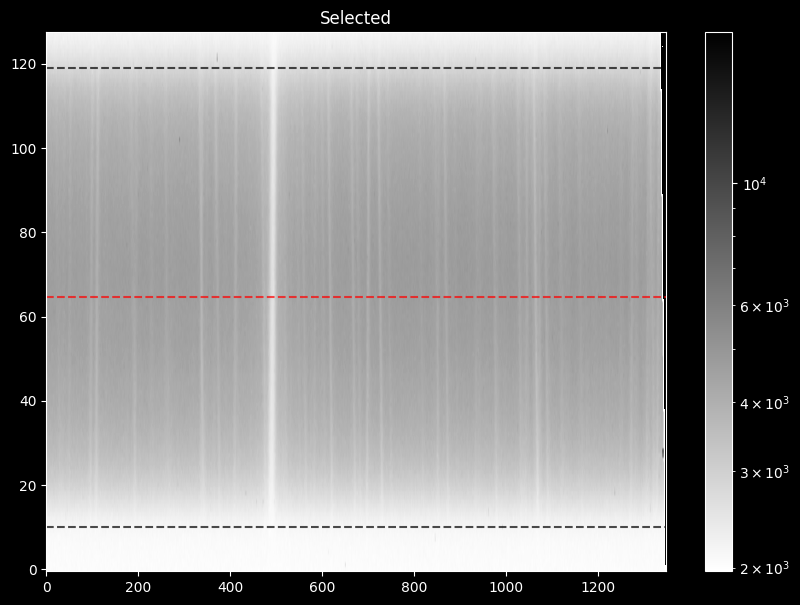

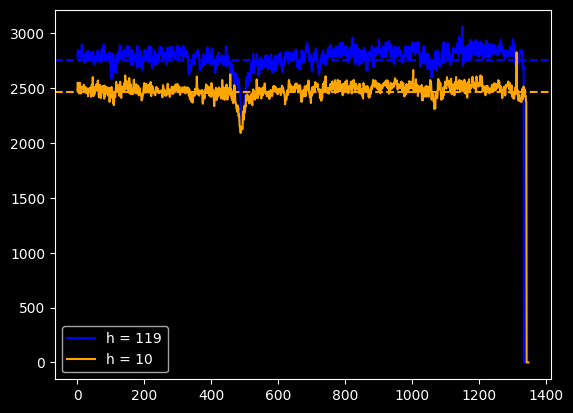

(1349,)


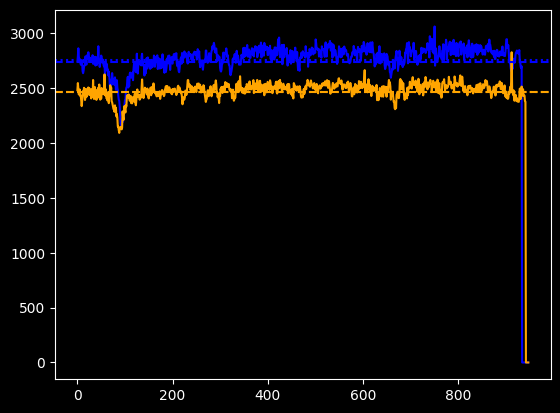

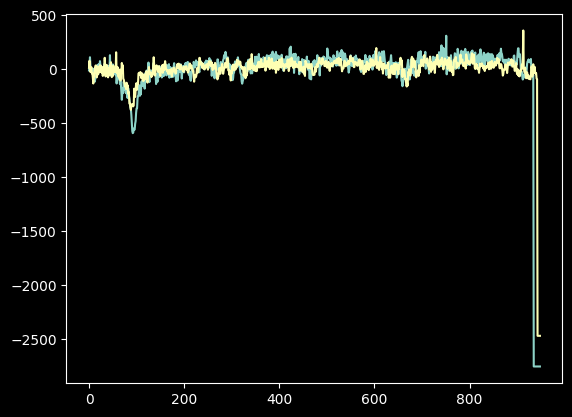

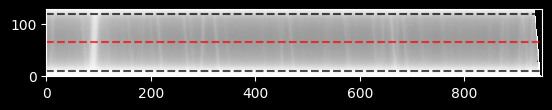

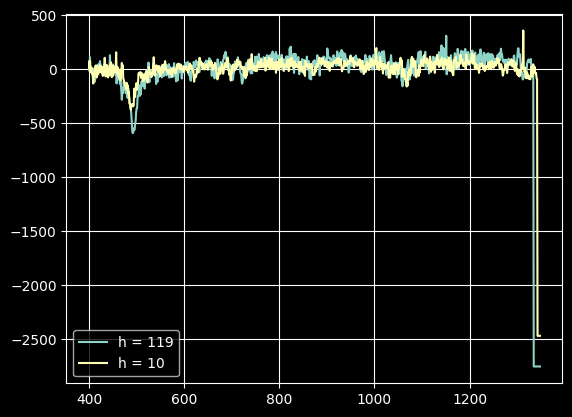

Left Shift 0
Right Shift 0
[-948  948]


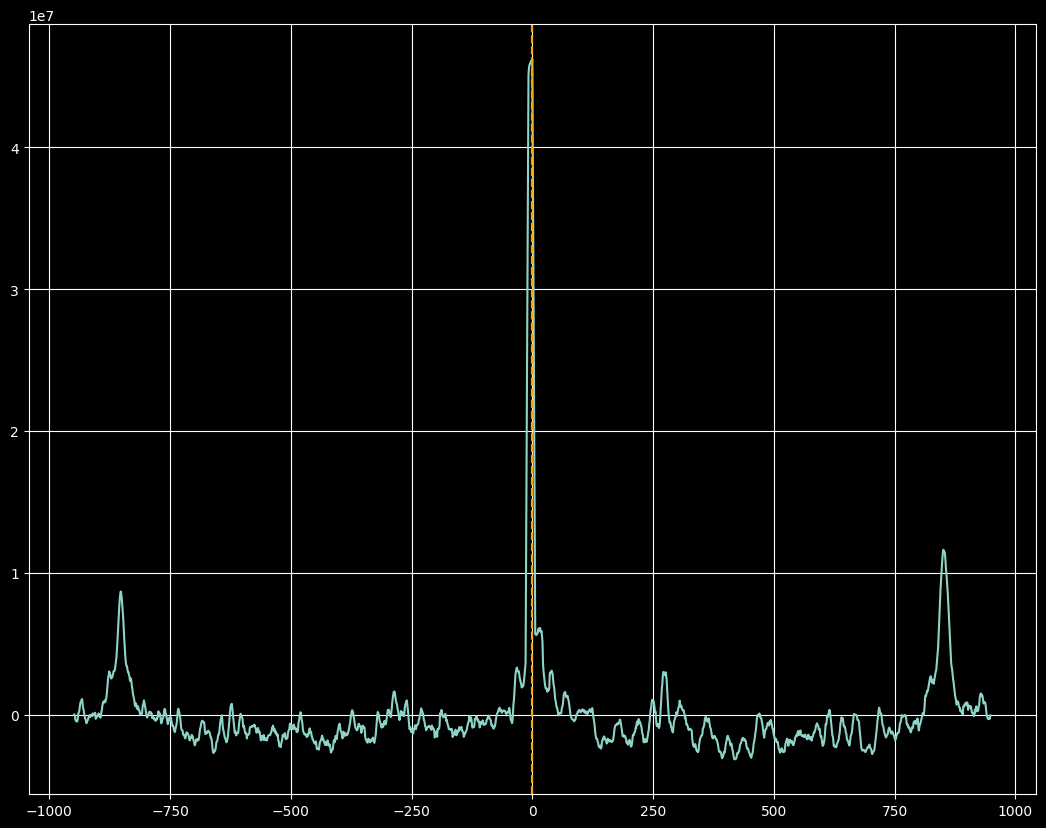

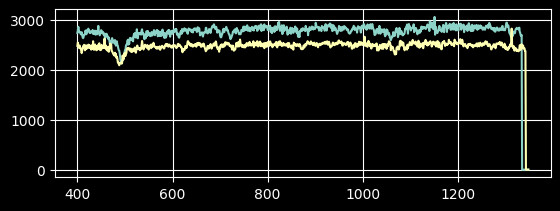

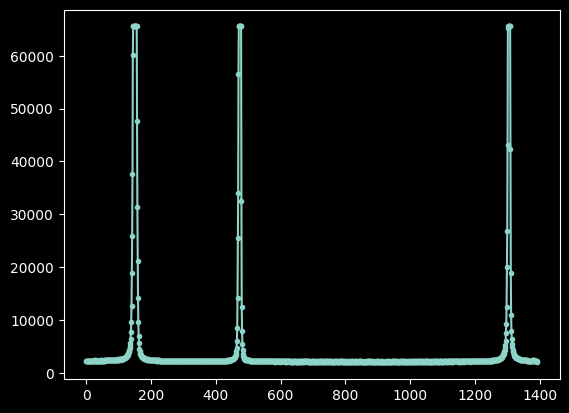

curve_fit
XERR [5.2 3.5 3. ]

Fit results:
	mode : curve_fit
	m: 7.990e-02 +/- 3.7e-04  -->  0.47 %	init : 0.08
	q: 6.49474e+03 +/- 3.3e-01  -->  0.01 %	init : 0.0
	corr_m-q	 = -0.83
[[ 1.40558608e-07 -1.02742394e-04]
 [-1.02742394e-04  1.08621583e-01]]


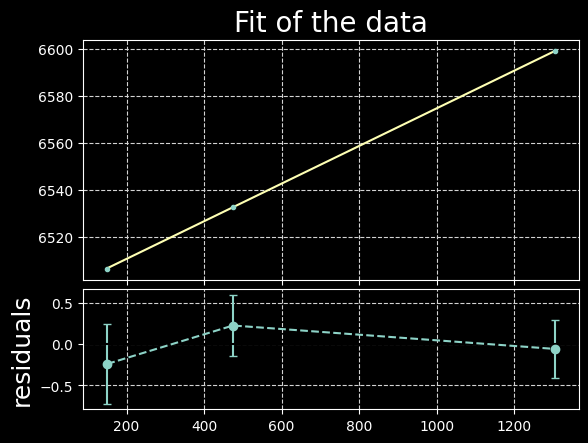

In [10]:

# select two rows
bottom = 10
up = np.floor(2*mid - bottom).astype(int)
print('heights',bottom,up,data.shape) 
# compute the distance from the central row
h = mid - bottom
Dh = Dmid
if bottom > len(data): print('Oh no'); exit()

# average over 3 pixels
j1 = data[up]
j2 = data[bottom+5]
# j1 = np.mean(data[up-1:up+2],axis=0)
# j2 = np.mean(data[bottom-1:bottom+2],axis=0)

plt.figure(figsize=(10,7))
plt.title('Selected')
plt.imshow(data,cmap='gray_r',norm='log',origin='lower',aspect='auto')
plt.axhline(up,0,1,linestyle='dashed',color='black',alpha=0.7)
plt.axhline(mid,0,1,linestyle='dashed',color='red',alpha=0.7)
plt.axhline(bottom,0,1,linestyle='dashed',color='black',alpha=0.7)
plt.colorbar()
plt.figure()
plt.plot(j1,'-',label=f'h = {up}',color='b')
plt.plot(j2,'-',label=f'h = {bottom}',color='orange')
plt.axhline(j1.mean(),0,1,linestyle='dashed',color='b')
plt.axhline(j2.mean(),0,1,linestyle='dashed',color='orange')
plt.legend()
plt.show()

# select an interval
start, stop = 400, None
# start, stop = 790, 850
# check the ends
if stop is None:
    px_val = np.arange(start,data.shape[1])
elif stop > 0:
    px_val = np.arange(start,stop)
else:
    px_val = np.arange(start,data.shape[1]+stop)

print(j1.shape)

# store the data
j1_p = j1[slice(start,stop)].copy()
j2_p = j2[slice(start,stop)].copy()
# j2_p = data[int(mid)]
# remove the average
# j1 = j1_p - data.mean(axis=0)[slice(start,stop)]
# j2 = j2_p - data.mean(axis=0)[slice(start,stop)]
# j1 = j1_p - np.full(j1_p.shape,4000)
# j2 = j2_p - np.full(j1_p.shape,4000)
plt.figure()    
plt.axhline(j1.mean(),0,1,linestyle='dotted',color='b')
plt.axhline(j2.mean(),0,1,linestyle='dotted',color='orange')
j1 = j1_p - j1.mean()
j2 = j2_p - j2.mean()
# j1 = j1_p - np.full(j1_p.shape,4000)
# j2 = j2_p - np.full(j1_p.shape,4000)
# j1 = j1_p - data[int(mid)-1:int(mid)+2,slice(start,stop)].mean(axis=0)
# j2 = j2_p - data[int(mid)-1:int(mid)+2,slice(start,stop)].mean(axis=0)
plt.plot(j1_p,'-',label=f'h = {up}',color='b')
plt.plot(j2_p,'-',label=f'h = {bottom}',color='orange')
plt.axhline(j1_p.mean(),0,1,linestyle='dashed',color='b')
plt.axhline(j2_p.mean(),0,1,linestyle='dashed',color='orange')
plt.show()
plt.figure()
plt.plot(j1)
plt.plot(j2)
plt.show()
# j1 = j1_p - j1_p.mean()
# j2 = j2_p - j2_p.mean()

plt.figure()
plt.imshow(data[:,slice(start,stop)],cmap='gray_r',norm='log',origin='lower')
plt.axhline(up,0,1,linestyle='dashed',color='black',alpha=0.7)
plt.axhline(mid,0,1,linestyle='dashed',color='red',alpha=0.7)
plt.axhline(bottom,0,1,linestyle='dashed',color='black',alpha=0.7)
plt.figure()
plt.plot(px_val,j1,'-',label=f'h = {up}')
plt.plot(px_val,j2,'-',label=f'h = {bottom}')
plt.grid()
plt.legend()
plt.show()

## Doppler Shift
from scipy.signal import correlate,correlation_lags
corr = correlate(j1,j2,mode='full')
lags = correlation_lags(len(j1),len(j2))
n_corr = np.where(lags <= 0, corr, 0)       #: correlation for negative lags only
p_corr = np.where(lags >= 0, corr, 0)       #: correlation for positive lags only
shift1 = lags[n_corr.argmax()]              #: left shift
shift2 = lags[p_corr.argmax()]              #: right shift
print('Left Shift' ,shift1)
print('Right Shift',shift2)
print(lags[[0,-1]])
plt.figure(figsize=(13,10))
plt.plot(lags,corr)
plt.axvline(shift1,0,1,color='orange',linestyle='--')
plt.axvline(shift2,0,1,color='orange',linestyle='--')
plt.grid()
plt.show()

j1 = j1_p.copy()
j2 = j2_p.copy()

plt.figure()
plt.subplot(2,1,1)
plt.plot(px_val,j1)
plt.plot(px_val,j2)
plt.grid()
if shift1 != 0:
    plt.subplot(2,1,2)
    plt.title(f'shift: {shift1}')
    plt.plot(px_val,j1,label=f'h = {up}')
    plt.plot(px_val[:shift1],j2[-shift1:],label=f'h = {bottom}')
    plt.grid()
    plt.legend()
plt.show()

## Wavelength Calibration
# average over 4 rows
heights = np.array([710+i*1 for i in range(4)])
lamp.spec, lamp.std = spc.mean_n_std(lamp.data[heights],axis=0)
plt.figure()
plt.errorbar(np.arange(*lamp.spec.shape),lamp.spec,lamp.std,fmt='.-')
plt.show()
# get data
lines, px, Dpx = spc.get_cal_lines(OBS_NIGHT,TARGET_NAME)
Dlines = lines/20000 / 2
# fit a line
m0 = np.mean(np.diff(lines)/np.diff(px))
fit = spc.FuncFit(xdata=px,xerr=Dpx,ydata=lines,yerr=Dlines)
fit.linear_fit([m0,0])
fit.plot(mode='subplots',points_num=3)
plt.show()
# store the parameter to convert px in AA
px_arm  = fit.fit_par[0]
Dpx_arm = fit.fit_err[0]

# px_arm = 0.115
## Period
def period(delta, index):
    print('\nShift'+index+' :',delta)
    delta  = px_arm * abs(delta)
    Ddelta = Dpx_arm * abs(delta)
    t0 = (8*np.pi * (R/C) * (BALMER/delta)).to(u.h)
    print(t0)
    t  = (8*np.pi * (R/C) * (BALMER/delta) * (h/rad)).to(u.h)
    Dt = t * np.sqrt( (DR/R)**2 + (ERRBAL/BALMER)**2 + (Ddelta/delta)**2 + (Drad/rad)**2 + (Dh/h)**2)
    w  = (2*np.pi / t).to(1 / u.s)
    Dw = w * Dt/t
    v  = (w*R).to(u.km/u.s)
    Dv = v * np.sqrt((Dw/w)**2 + (DR/R)**2)
    spc.print_measure(delta,Ddelta,'Dl'+str(index),'AA')
    spc.print_measure(t,Dt,'T'+str(index))
    spc.print_measure(w,Dw,'omega'+str(index))
    spc.print_measure(v,Dv,'v_tan'+str(index))
    acc_cond = t-Dt <= PERIOD <= t+Dt
    print(f'period = {PERIOD} -->', 'OK' if acc_cond else 'NO') 
    if not acc_cond:
        print(f'diff = {abs(PERIOD-t)/Dt:.2} sigma')
    return t, Dt
if shift1 != 0:
    p1 = period(shift1,'1')


In [11]:
old_mid = mid

FOCAL 2.88
PXWIDTH 6.44922e-06
48
15
6


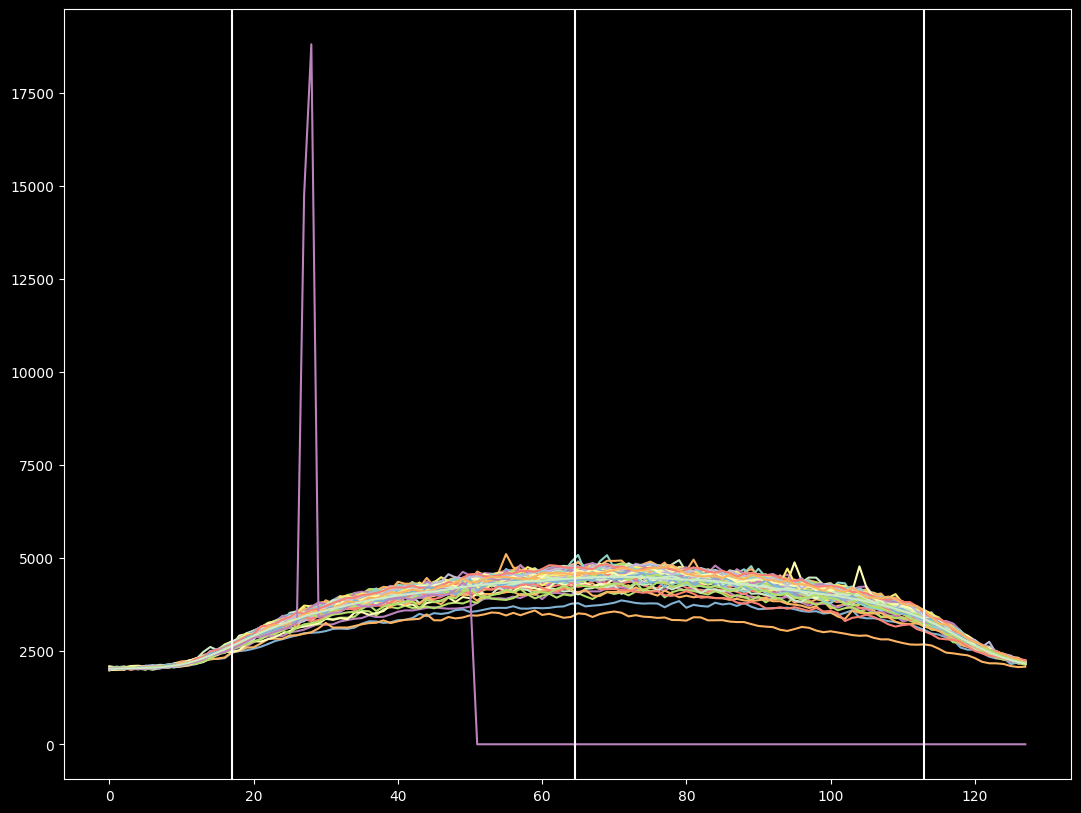

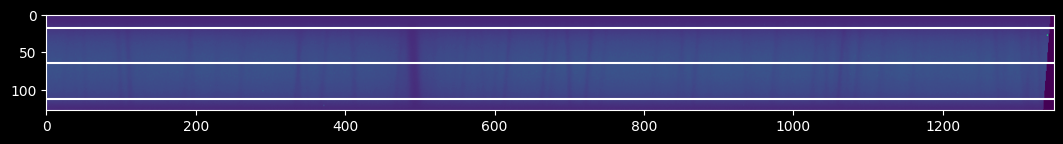

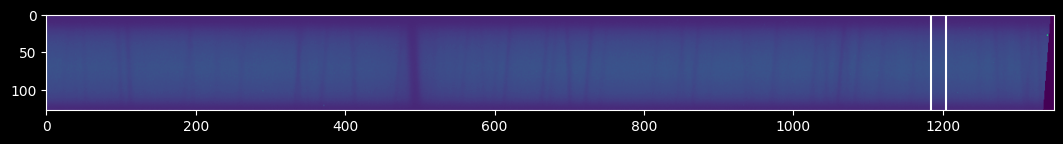

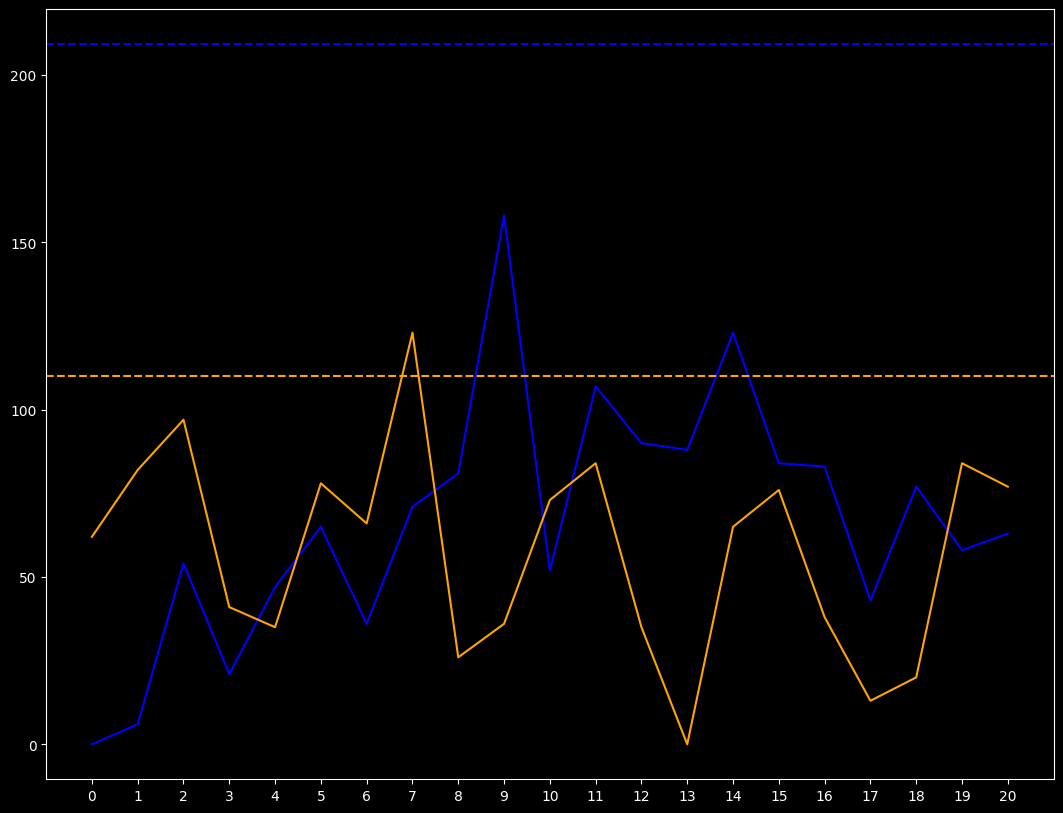

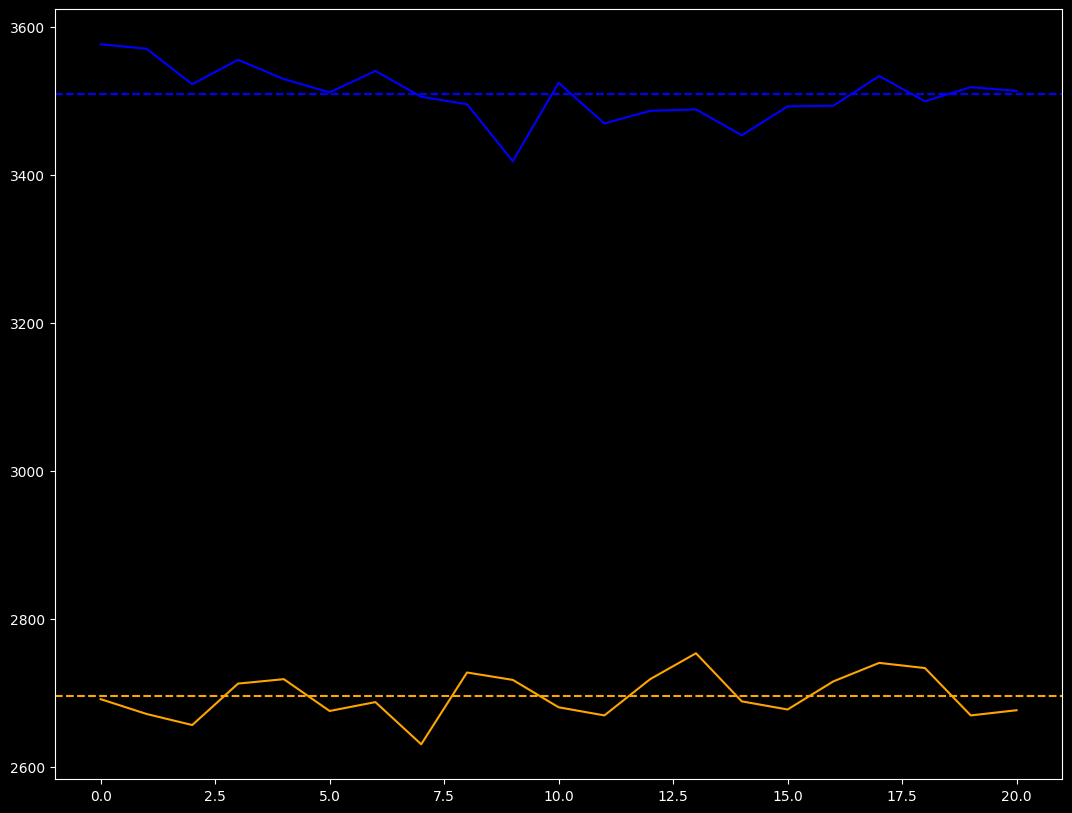

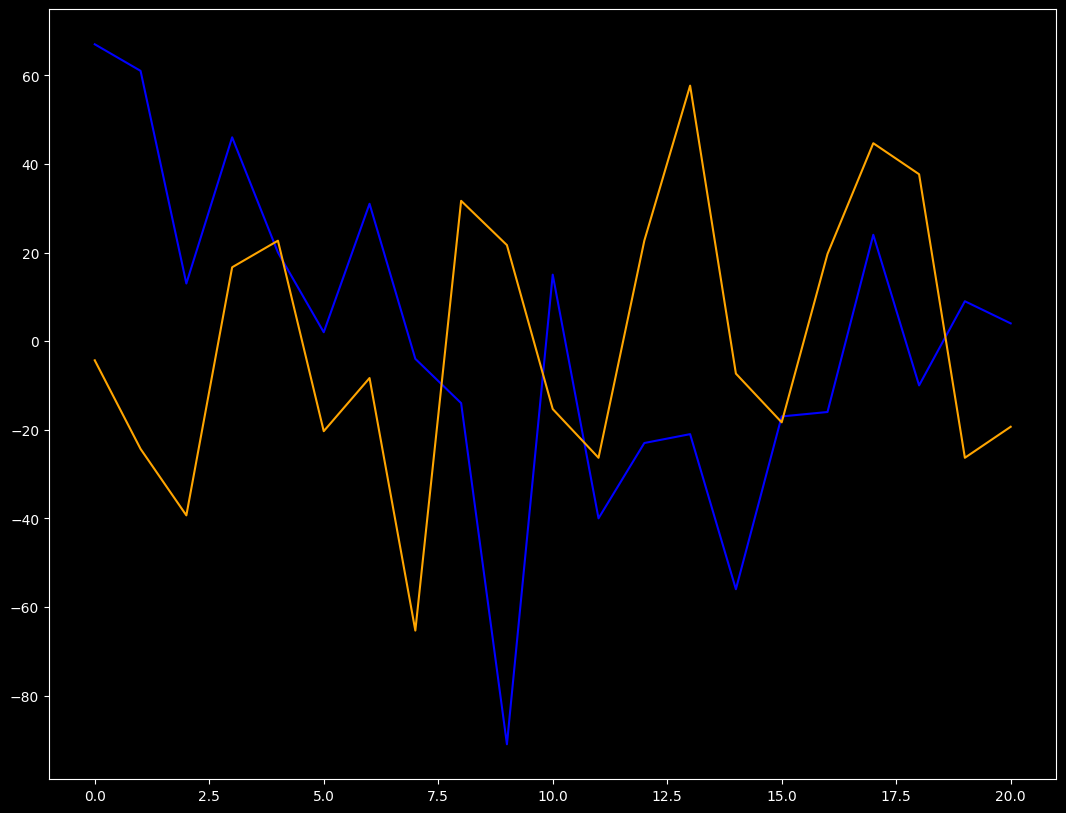

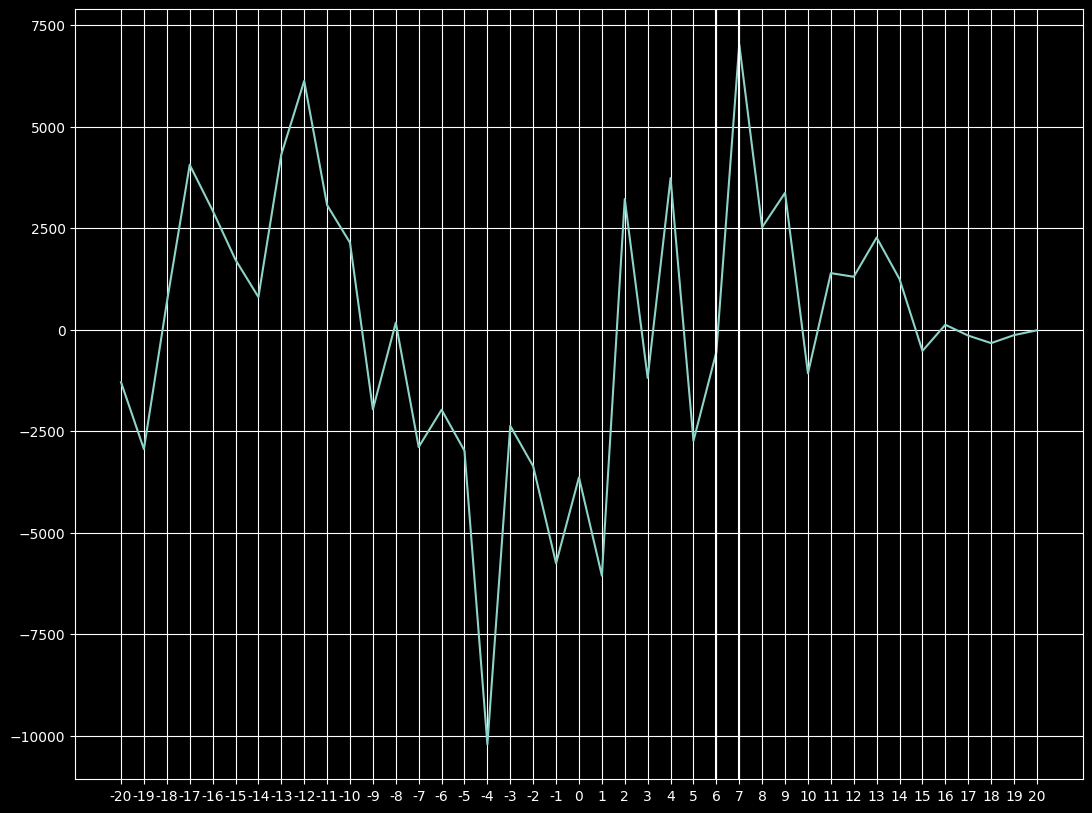

In [12]:
mid = old_mid
mid = mid
# jupiter.print_header()
PX_WIDTH = jupiter.header['YPIXSZ']*1e-6 
FOCAL = jupiter.header['FOCALLEN']*1e-3
print('FOCAL',FOCAL)
print('PXWIDTH',PX_WIDTH) 
ANG_DIAM = 44.29871 / 3600 * np.pi /180
px_rad = np.round(ANG_DIAM*FOCAL / PX_WIDTH /2).astype(int)
px_u = np.round(mid+px_rad).astype(int)
px_d = np.round(mid-px_rad).astype(int)
plt.figure(figsize=(13,10))
for i in range(0,data.shape[1],20):
    plt.plot(data[:,i])
plt.plot(np.mean(data,axis=1))
plt.axvline(px_u,0,1)
plt.axvline(mid,0,1)
plt.axvline(px_d,0,1)
print(px_rad)
plt.figure(figsize=(13,10))
plt.imshow(data)
plt.axhline(mid,0,1)
plt.axhline(px_u,0,1)
plt.axhline(px_d,0,1)
# plt.xlim(1190,1210)

sel_ends = (1184,1205)
# sel_ends = (data.shape[1]-1204,data.shape[1]-1184)
sp_u = data[px_u,slice(*sel_ends)]
sp_d = data[px_d,slice(*sel_ends)]
plt.figure(figsize=(13,10))
plt.imshow(data)
plt.axvline(sel_ends[0],0,1)
plt.axvline(sel_ends[1],0,1)
plt.figure(figsize=(13,10))
plt.plot(sp_u.max()-sp_u,color='b')
plt.plot(sp_d.max()-sp_d,color='orange')
plt.axhline(sp_u.max()-data[px_u].mean(),0,1,color='b',linestyle='dashed')
plt.axhline(sp_d.max()-data[px_d].mean(),0,1,color='orange',linestyle='dashed')
plt.xticks(np.arange(len(sp_u)),np.arange(len(sp_u)))
plt.figure(figsize=(13,10))
plt.plot(sp_u,color='b')
plt.plot(sp_d,color='orange')
plt.axhline(sp_u.mean(),0,1,color='b',linestyle='dashed')
plt.axhline(sp_d.mean(),0,1,color='orange',linestyle='dashed')
sp_u = sp_u - sp_u.mean()
sp_d = sp_d - sp_d.mean()
plt.figure(figsize=(13,10))
plt.plot(sp_u,color='b')
plt.plot(sp_d,color='orange')

corr2 = correlate(sp_u,sp_d,mode='full')
lags2 = correlation_lags(len(sp_u),len(sp_d),mode='full')

new_shift = 15#lags2[corr2.argmax()] 
print(new_shift)
print(lags2[corr2.argmax()-1])
plt.figure(figsize=(13,10))
plt.plot(lags2,corr2)
plt.xticks(lags2,lags2)
plt.axvline(lags2[corr2.argmax()],0,1)
plt.axvline(lags2[corr2.argmax()-1],0,1)
plt.grid()
plt.show()

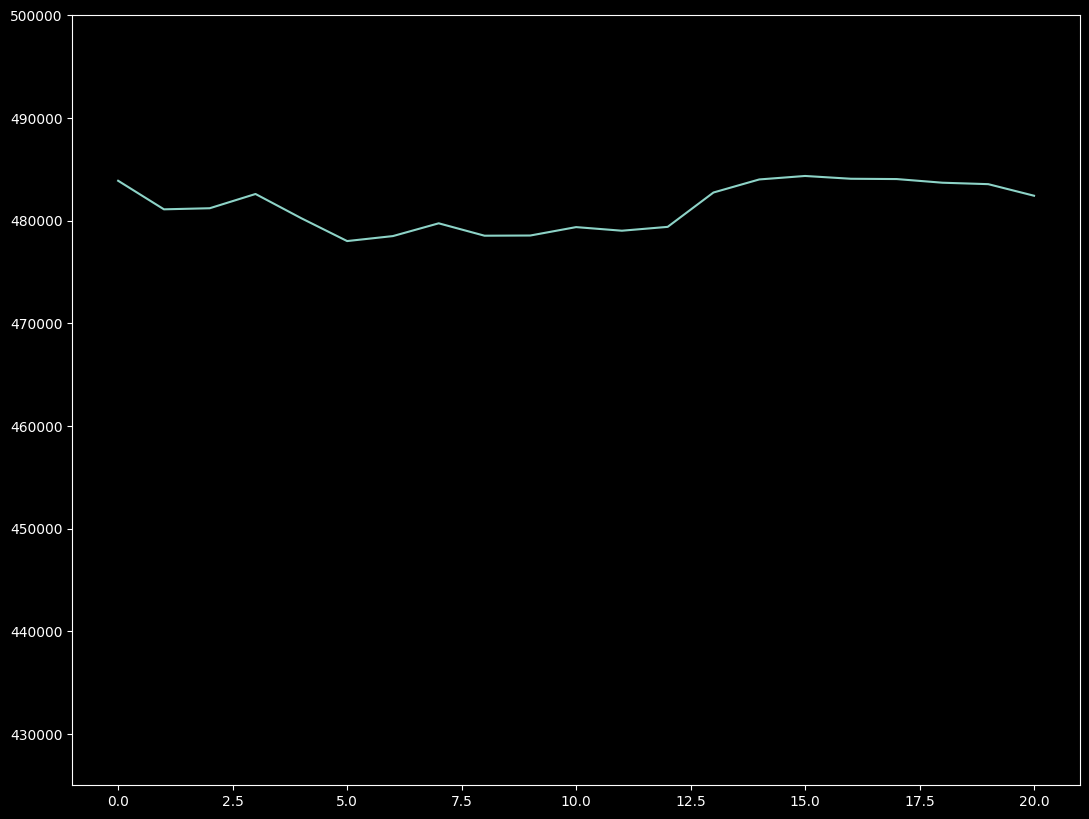

6593.096489526226 0.5669330928553883
DELTA 1.1984837834372866 0.005623672012425654
VEL 13623.962575118576 m / s
PER 9.158648094898531 h
VEL 27247.92515023715 m / s
PER 4.579324047449266 h


In [13]:
mask_data = data[:,slice(*sel_ends)]
# plt.figure(figsize=(13,10))
# plt.plot(np.sum(data,axis=0))
# plt.xlim(800,830)
plt.figure(figsize=(13,10))
plt.plot(np.sum(mask_data,axis=0))
plt.ylim(4.25e5,5e5)
plt.show()

(mf, qf), (Dmf, Dqf) = fit.results()
# bal_px = np.argmin(np.sum(data,axis=0))+jupiter.lims[2]
# est_bal = mf*bal_px+qf
# Dest_bal = np.sqrt((Dmf*bal_px)**2 + Dqf**2 + 2*fit.res['cov'][0,1])
# print(mf,qf)
# print(est_bal,BALMER)
# print(est_bal-BALMER,Dest_bal)

cen_val = np.argmin(np.sum(mask_data,axis=0)) + cp_jup.lims[2] + sel_ends[0]
est_val = fit.method(cen_val) 
Dest_val = np.sqrt((Dmf*cen_val)**2 + Dqf**2 + 2*fit.res['cov'][0,1])
print(est_val,Dest_val)

delta = abs(new_shift*mf)
Ddelta = abs(new_shift*Dmf)

print('DELTA',delta,Ddelta)
print('VEL',C*delta/est_val/4)
print('PER', (8*np.pi * (R/C) * (est_val/delta)).to(u.h) )
print('VEL',C*delta/est_val/2)
print('PER', (4*np.pi * (R/C) * (est_val/delta)).to(u.h) )


6561.456517643482
6
5475.863451105266 m / s
22.786740392219457 h
0.10807904790373259 h
11.393370196109728 h


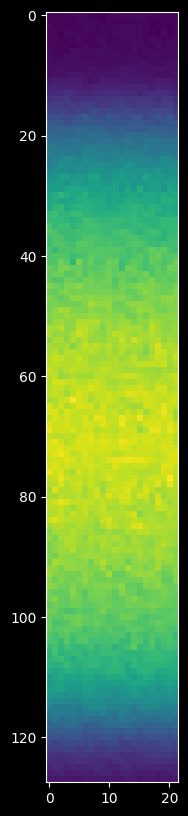

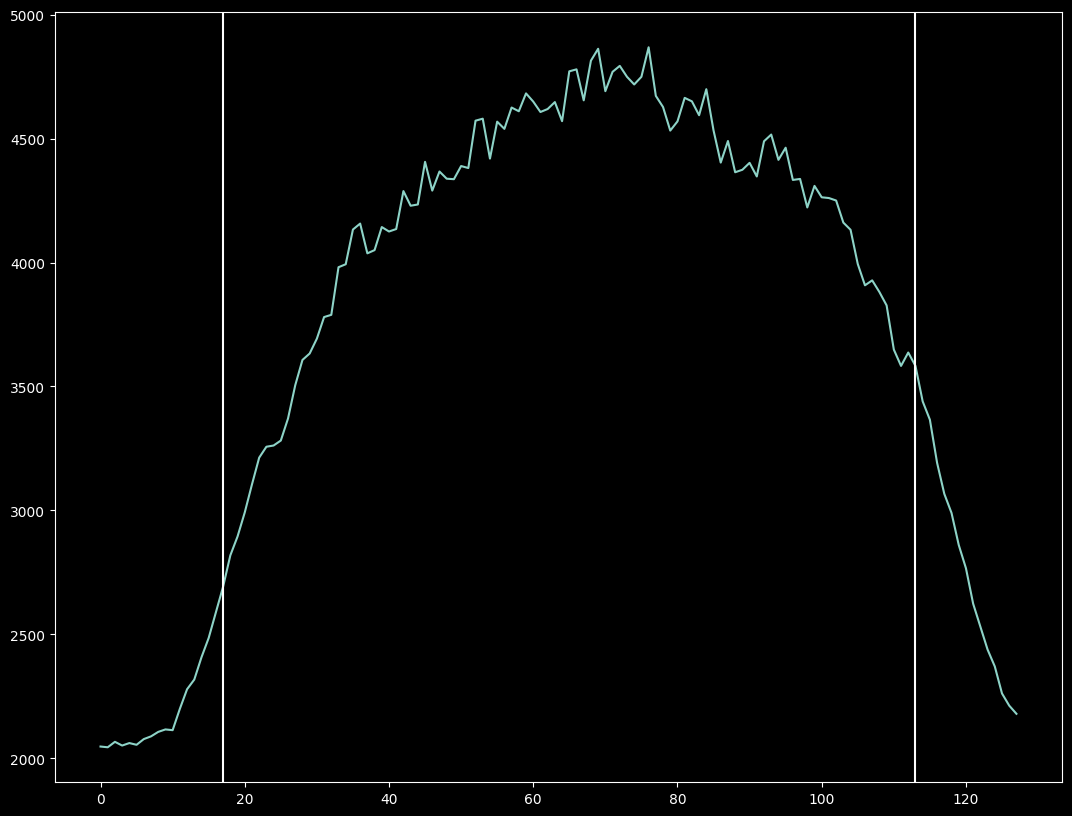

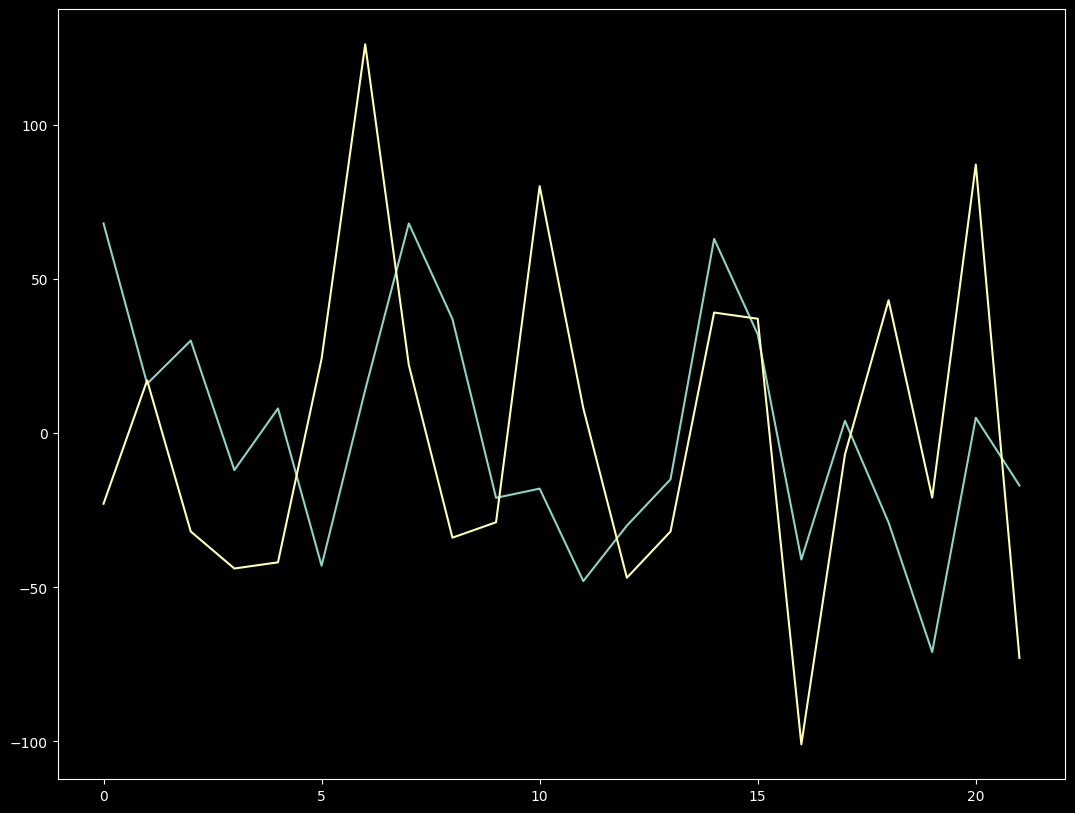

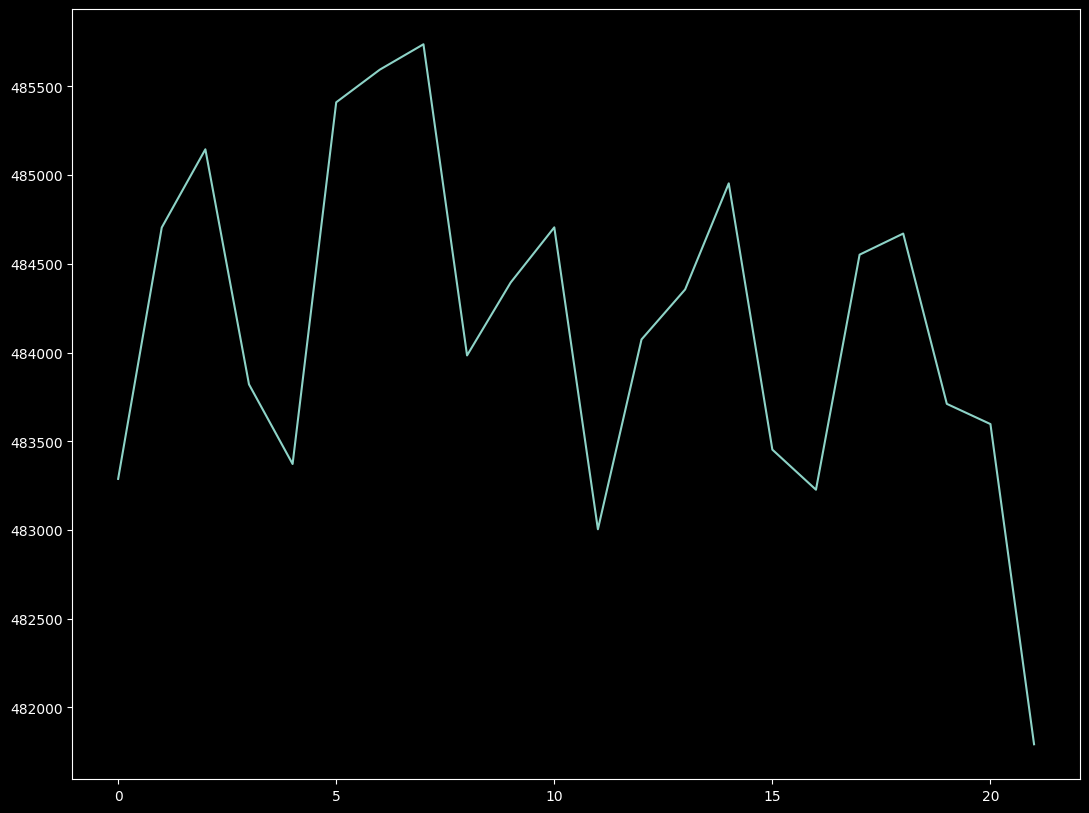

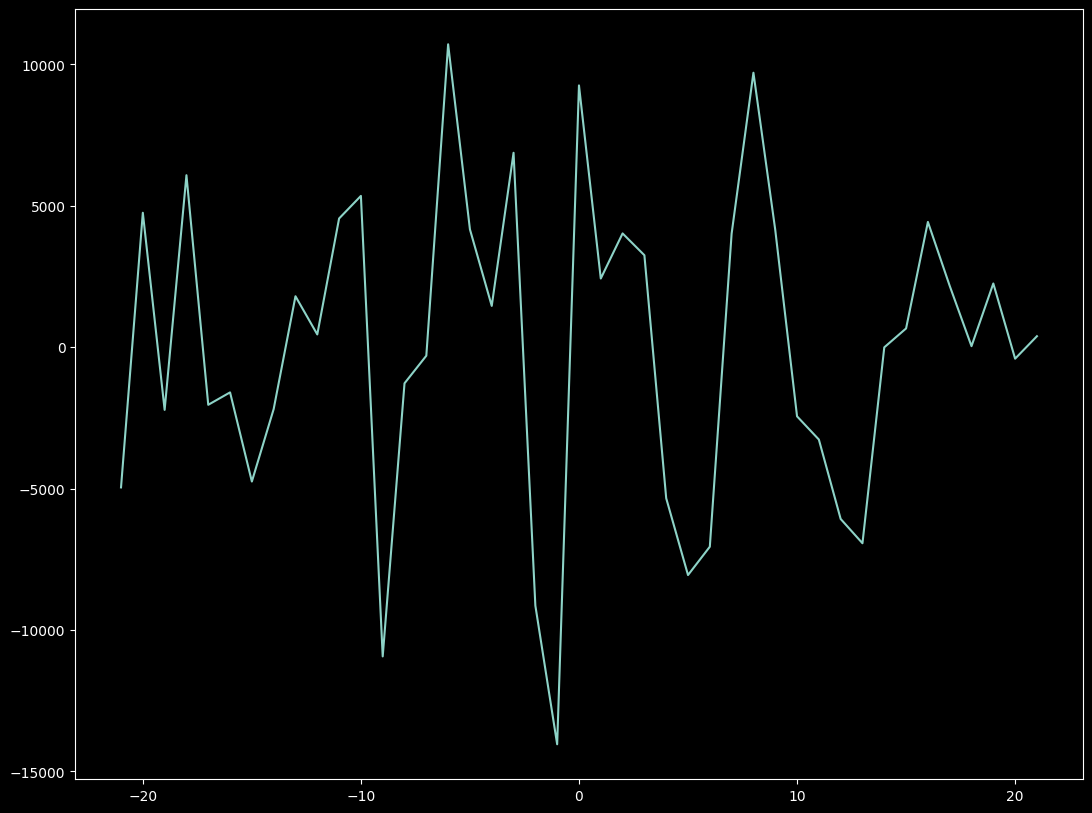

In [14]:
# sel_ends2 = (595,622)
sel_ends2 = (598,620)
sel_ends2 = (lamp.data.shape[1]-620,lamp.data.shape[1]-598)
m_data = data[:,slice(*sel_ends2)].copy()
plt.figure(figsize=(13,10))
plt.imshow(m_data)
plt.figure(figsize=(13,10))
plt.plot(m_data[:,0])
plt.axvline(px_u,0,1)
plt.axvline(px_d,0,1)

sp2_u = m_data[px_u] - m_data[px_u].mean()
sp2_d = m_data[px_d] - m_data[px_d].mean()
plt.figure(figsize=(13,10))
plt.plot(sp2_u)
plt.plot(sp2_d)

plt.figure(figsize=(13,10))
plt.plot(np.sum(m_data,axis=0))

minpos = np.argmin(np.sum(m_data,axis=0)) + sel_ends2[0] + cp_jup.lims[2]
minval = fit.method(minpos)
print(minval)
corr3 = correlate(sp2_u,sp2_d,mode='full')
lags3 = correlation_lags(len(sp2_u),len(sp2_d),mode='full')
shift3 = abs(lags3[corr3.argmax()])
# (m*sh +q) / m*sh
# 1+(q/m*sh)
# Dq/q + Dm/m
T3 = (8*np.pi*R/C * minval/(shift3*mf)).to(u.h)
DT3 = T3 * (Dmf/mf+Dqf/qf)
print(shift3)
print(C*(shift3*mf)/minval/4)
print((8*np.pi*R/C * minval/(shift3*mf)).to(u.h))
print(DT3)
print((4*np.pi*R/C * minval/(shift3*mf)).to(u.h))

plt.figure(figsize=(13,10))
plt.plot(lags3,corr3)
plt.show()


Fit results:
	mode : curve_fit
	par0: 7.990e-02 +/- 3.7e-04  -->  0.47 %	init : 0.08
	par1: 6.49474e+03 +/- 3.3e-01  -->  0.01 %	init : 0.0
	corr_par0-par1	 = -0.83
[[ 1.40558608e-07 -1.02742394e-04]
 [-1.02742394e-04  1.08621583e-01]]
0.0798989188958191 0.0003749114674950436 6494.740920365472 0.3295778862247291

- - -
Value for (1135, 1160)
inclination:	 6.4 	 5.052631578947368
4 25
21
6590.699521959351
19080.48445228557 m / s
6.539513144732135 h 0.029967365333974094 h 0.45825070874143164
9.92491972222222 h
-3.3854065774900857 h
-112.96977694772653

- - -
Value for (942, 964)
inclination:	 -5.052631578947368 	 -6.4
0 22
22
6573.441355477854
20041.559048895546 m / s
6.225916785174197 h 0.028605212364248 h 0.45945381782753214
9.92491972222222 h
-3.6990029370480233 h
-129.31219981681355

- - -
Value for (797, 822)
inclination:	 -6.857142857142857 	 -6.0
3 24
21
6563.294192778085
19160.155870630384 m / s
6.512320657831546 h 0.029967365333974094 h 0.46016415512243136
9.92491972222222 h
-3

/tmp/ipykernel_27721/1944583617.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


13705.346300287842 m / s
9.10426312109735 h 0.041954311467563725 h 0.4608205069374896
9.92491972222222 h
-0.8206566011248704 h
-19.560721471006556

- - -
Value for (482, 506)
inclination:	 19.2 	 48.0
0 18
18
6537.40694305584
16488.023574459687 m / s
7.567740203674931 h 0.034961926222969786 h 0.4619863431092958
9.92491972222222 h
-2.35717951854729 h
-67.42132866233888

- - -
Value for (187, 208)
inclination:	 12.0 	 19.2
1 14
13
6513.51716630599
11951.692333980674 m / s
10.440118051634943 h 0.048408820924112 h 0.4636807810475963
9.92491972222222 h
0.5151983294127227 h
10.642653953922414


= = =

10.533422919258348 2.8624005142070925 27.174457307450755
OK


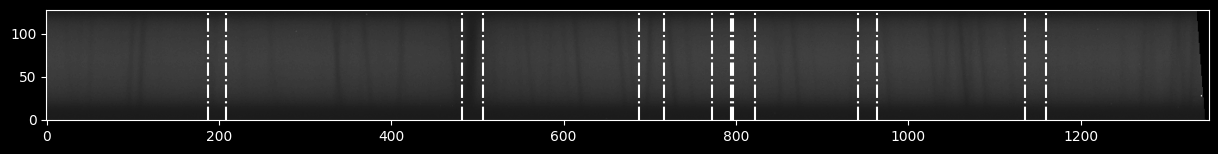

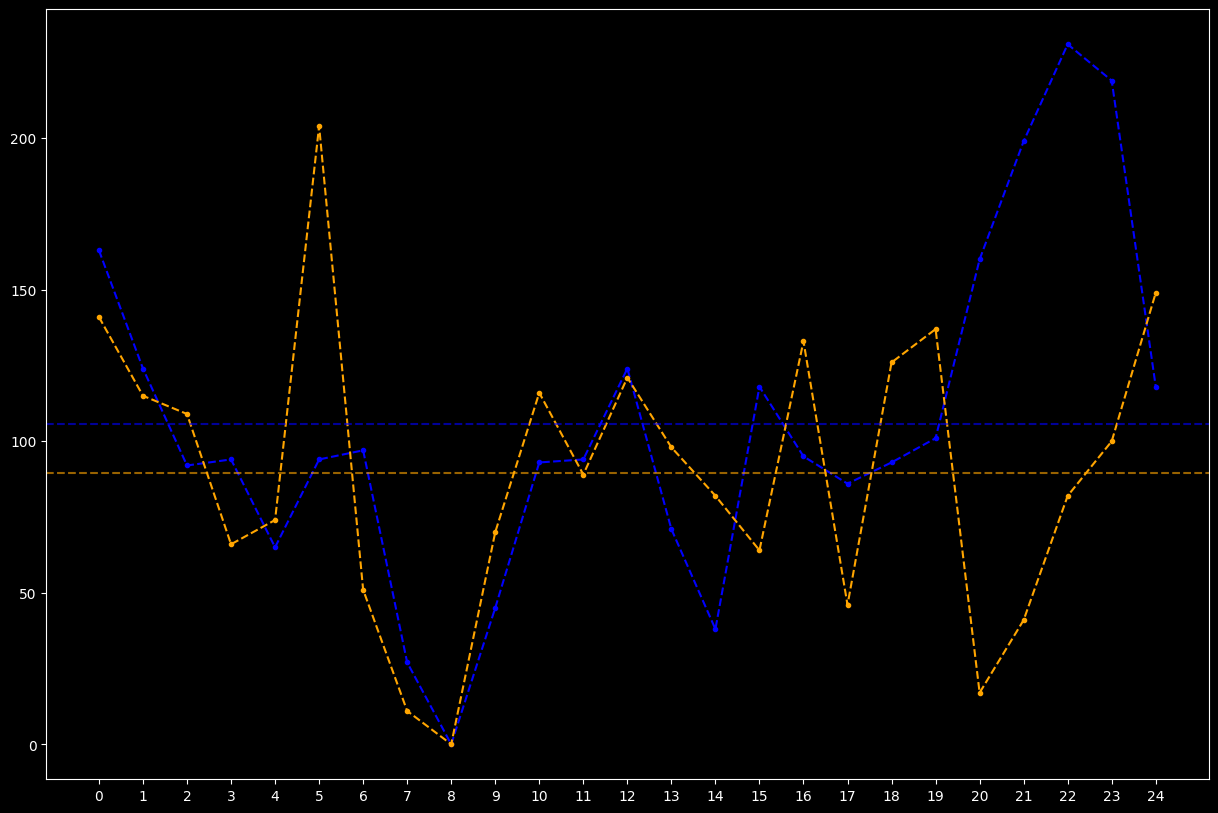

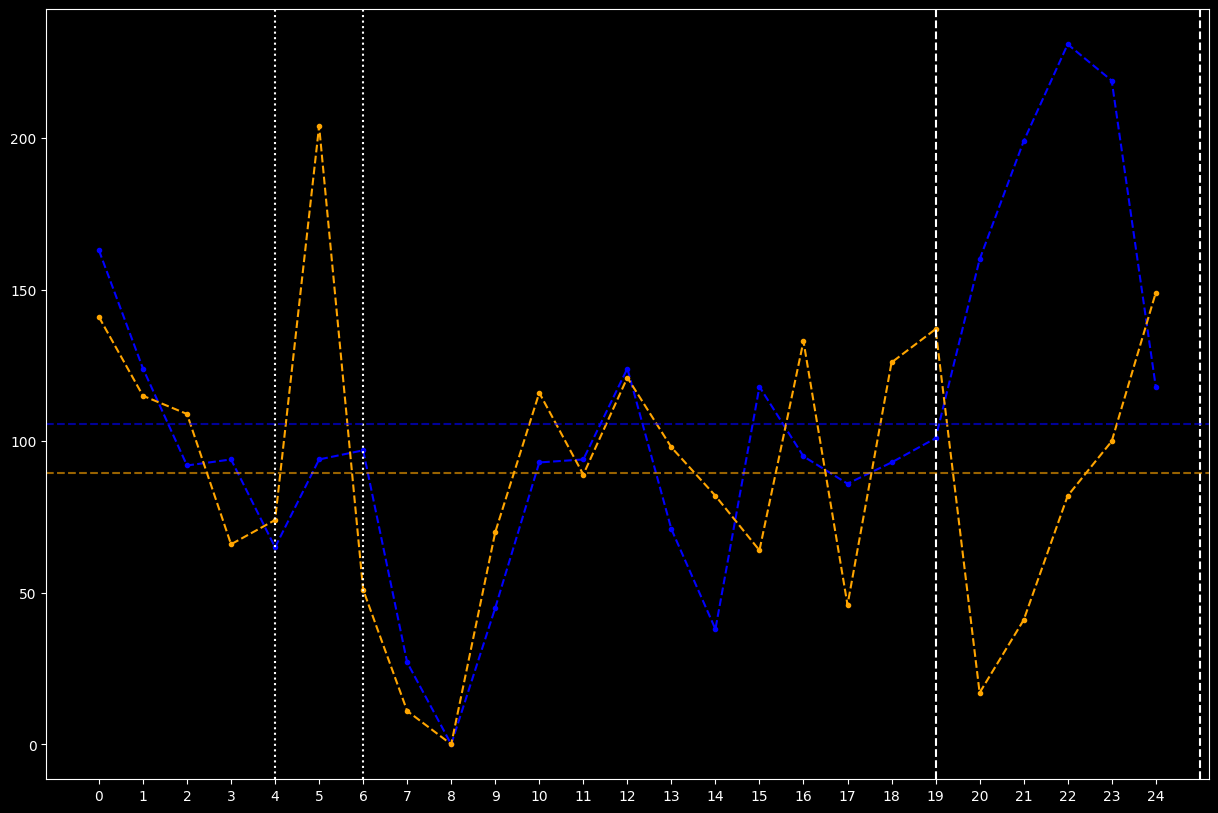

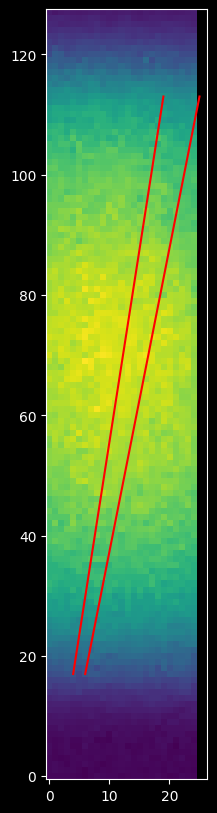

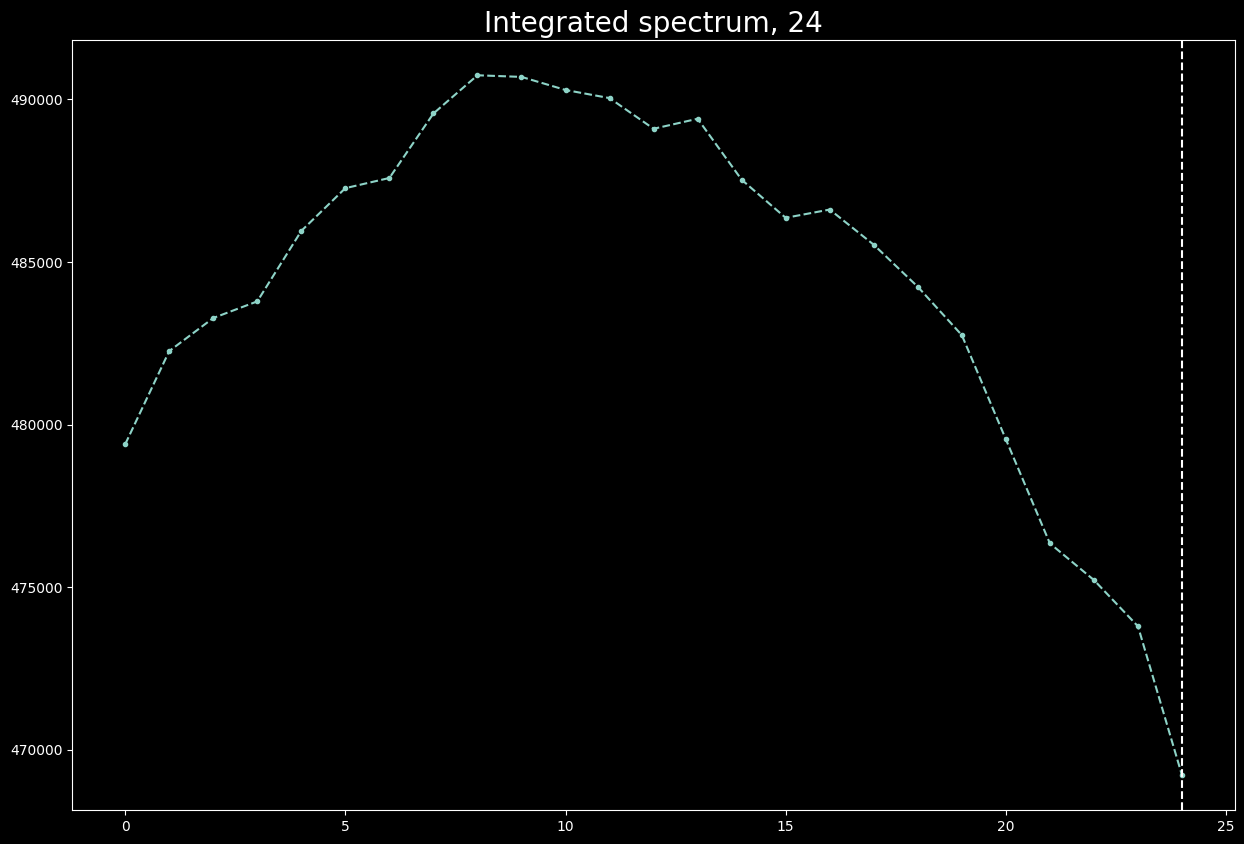

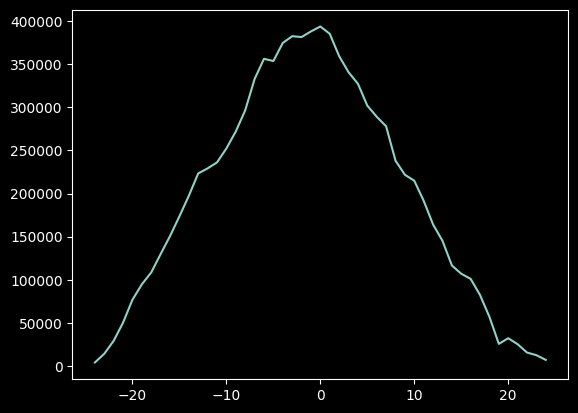

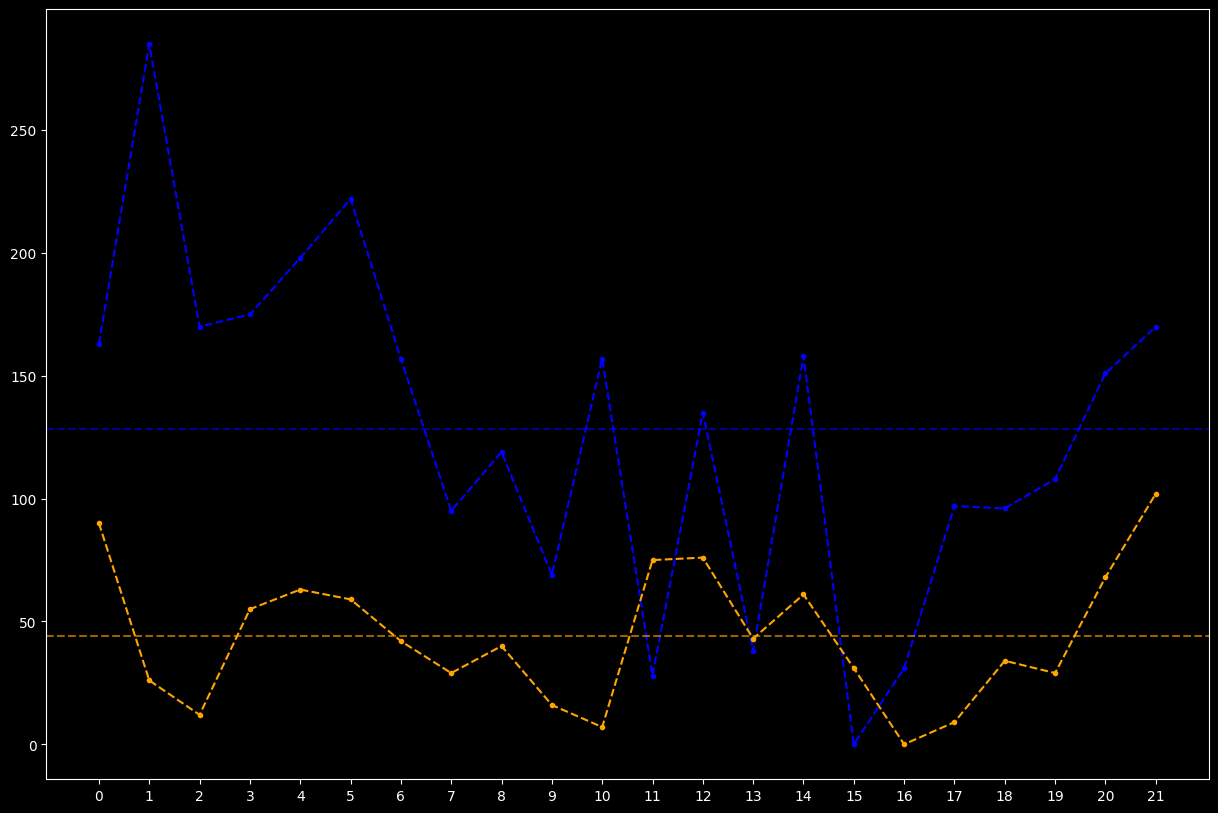

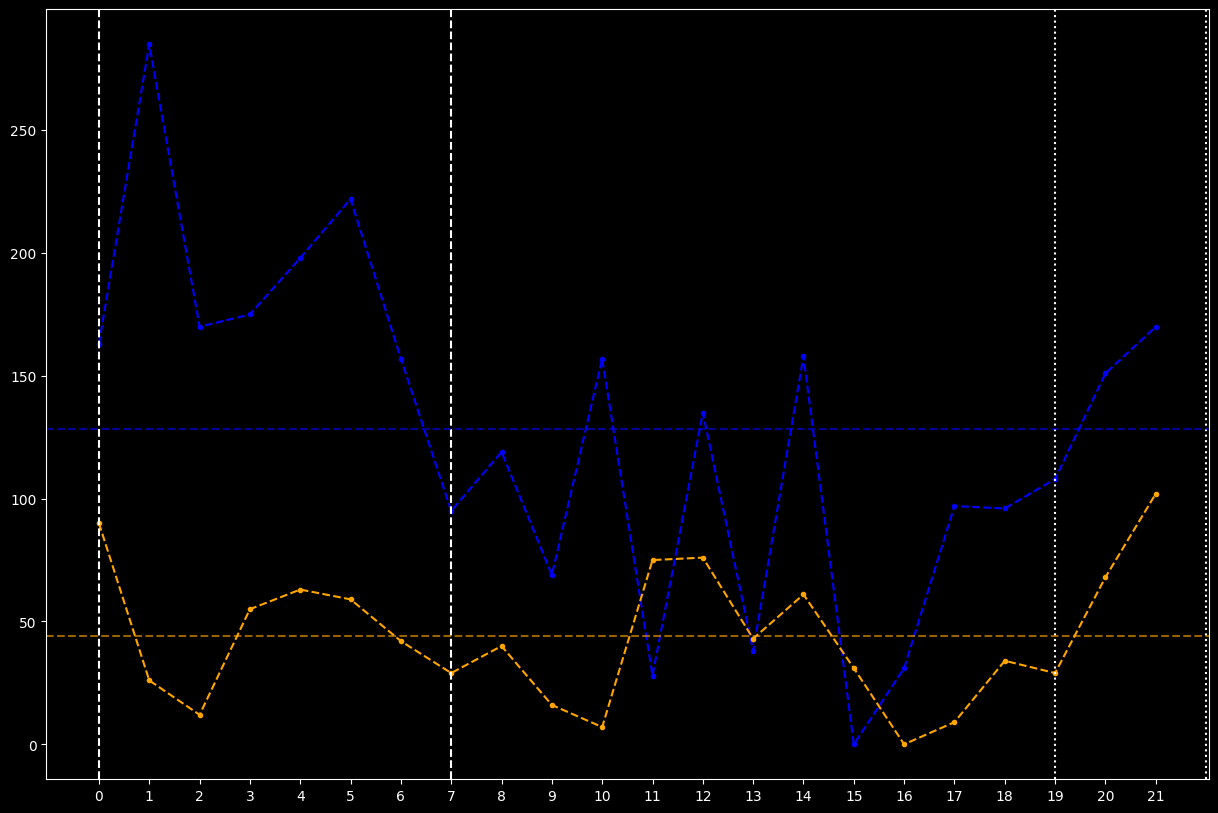

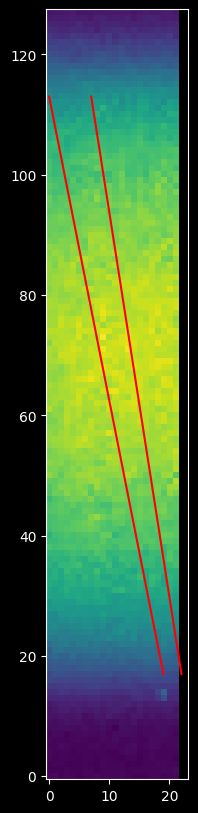

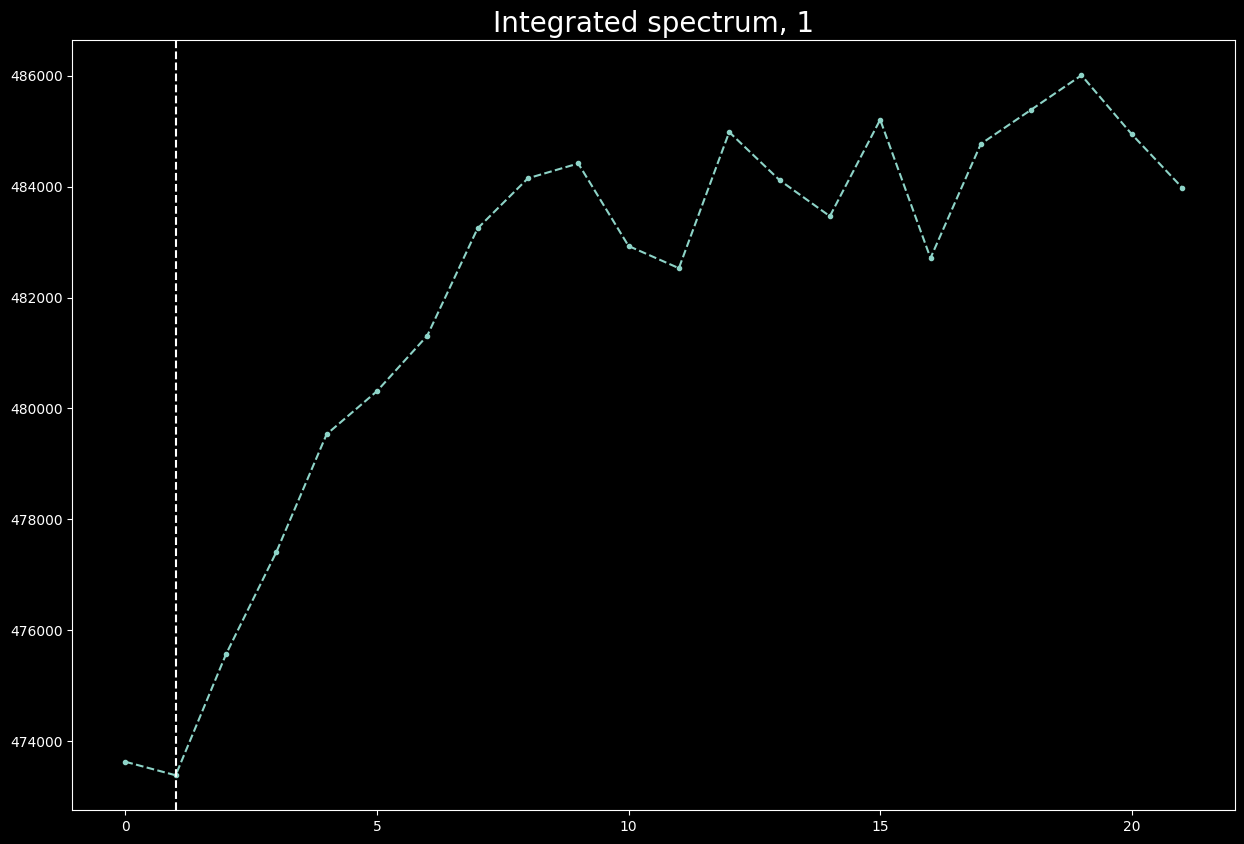

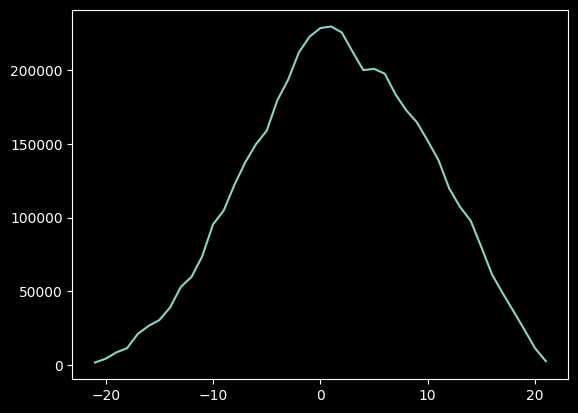

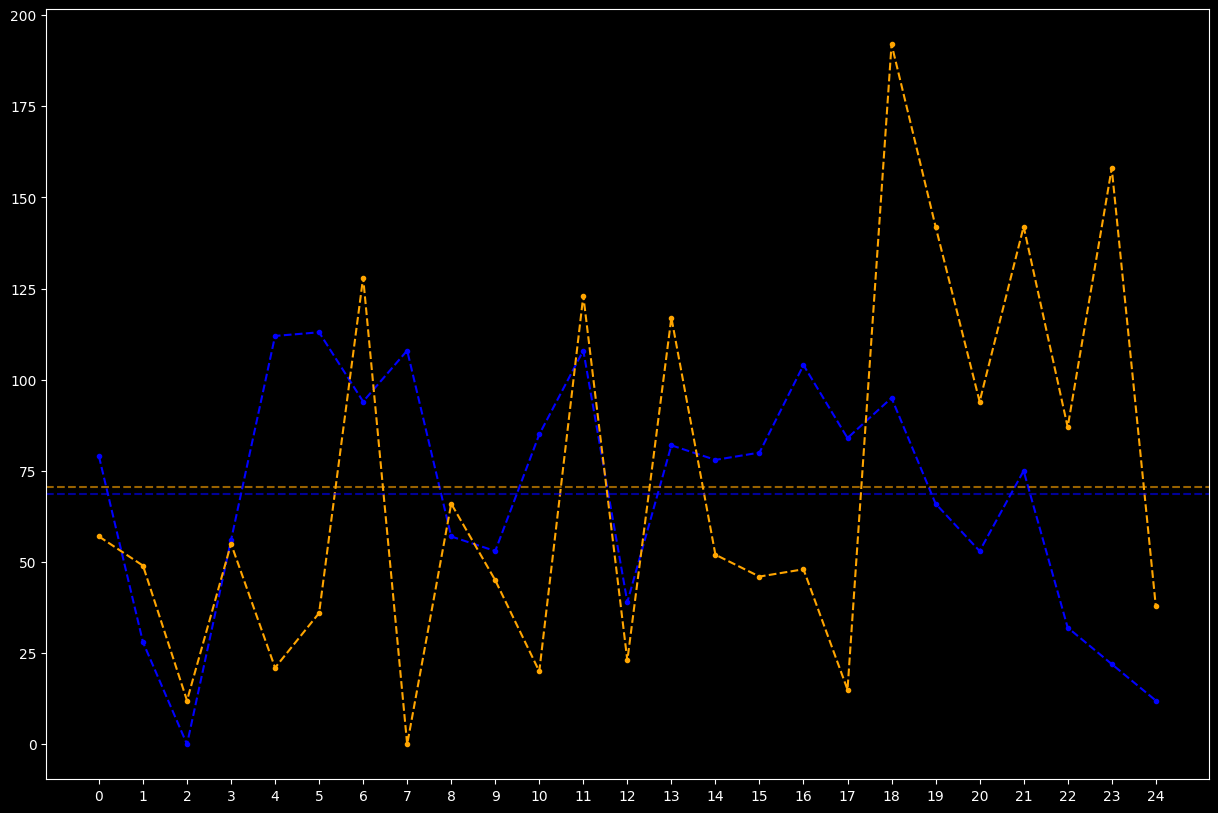

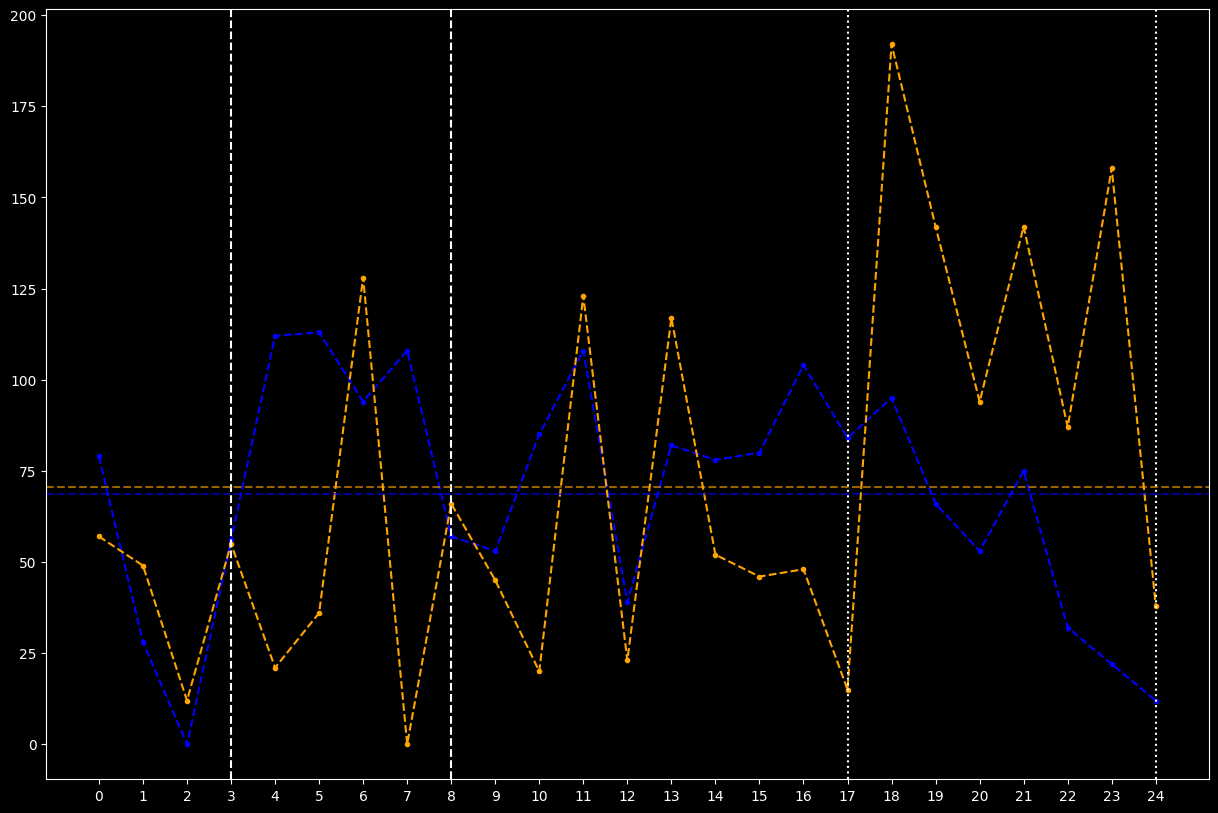

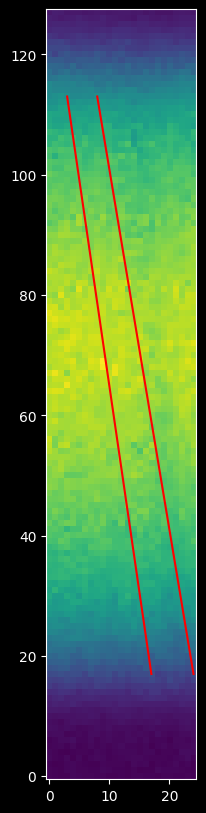

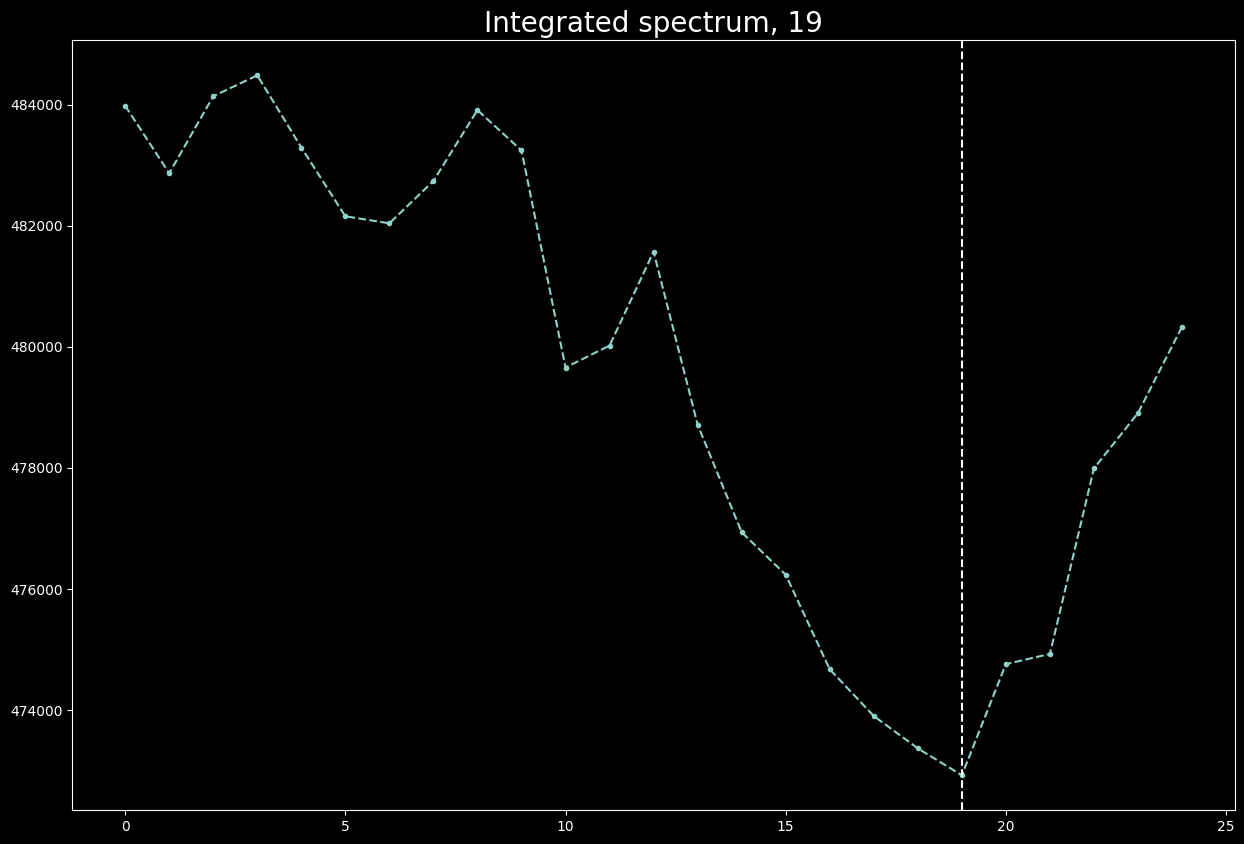

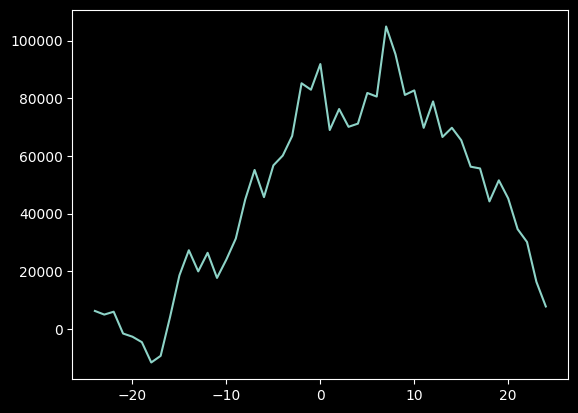

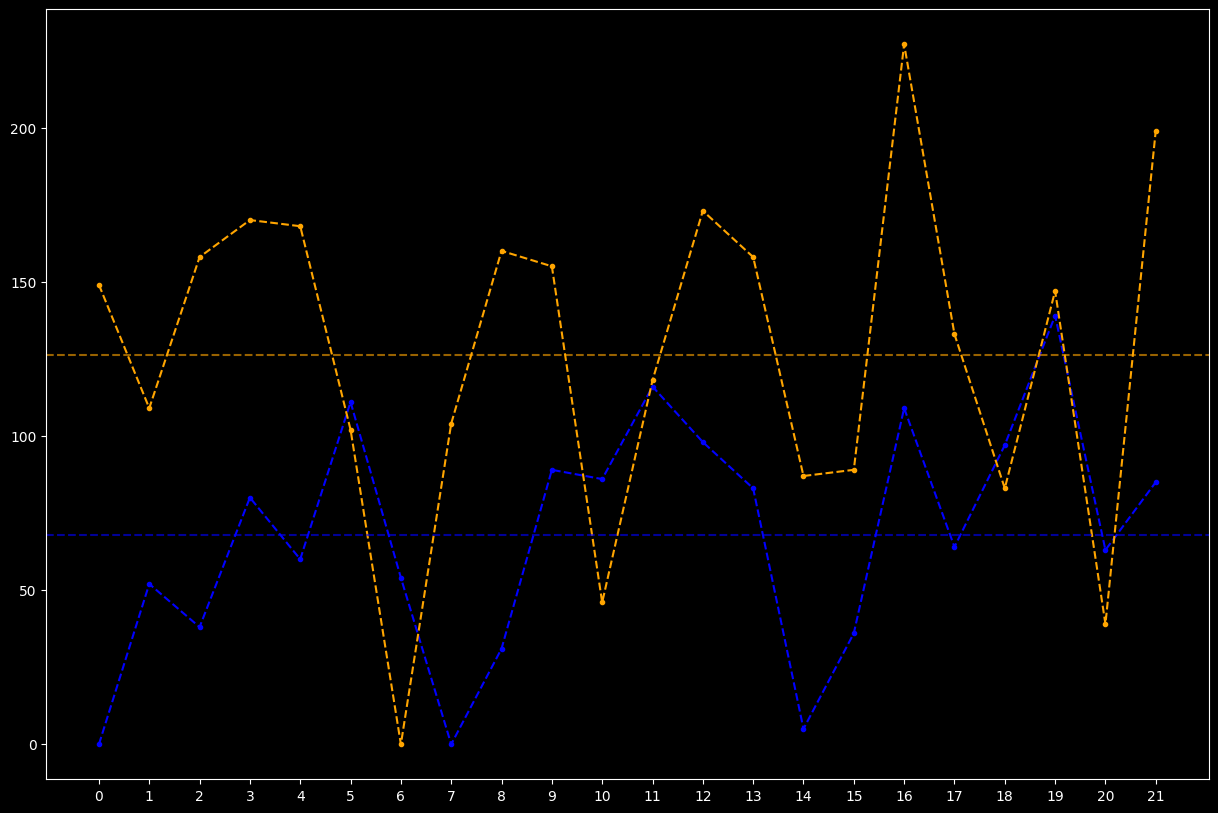

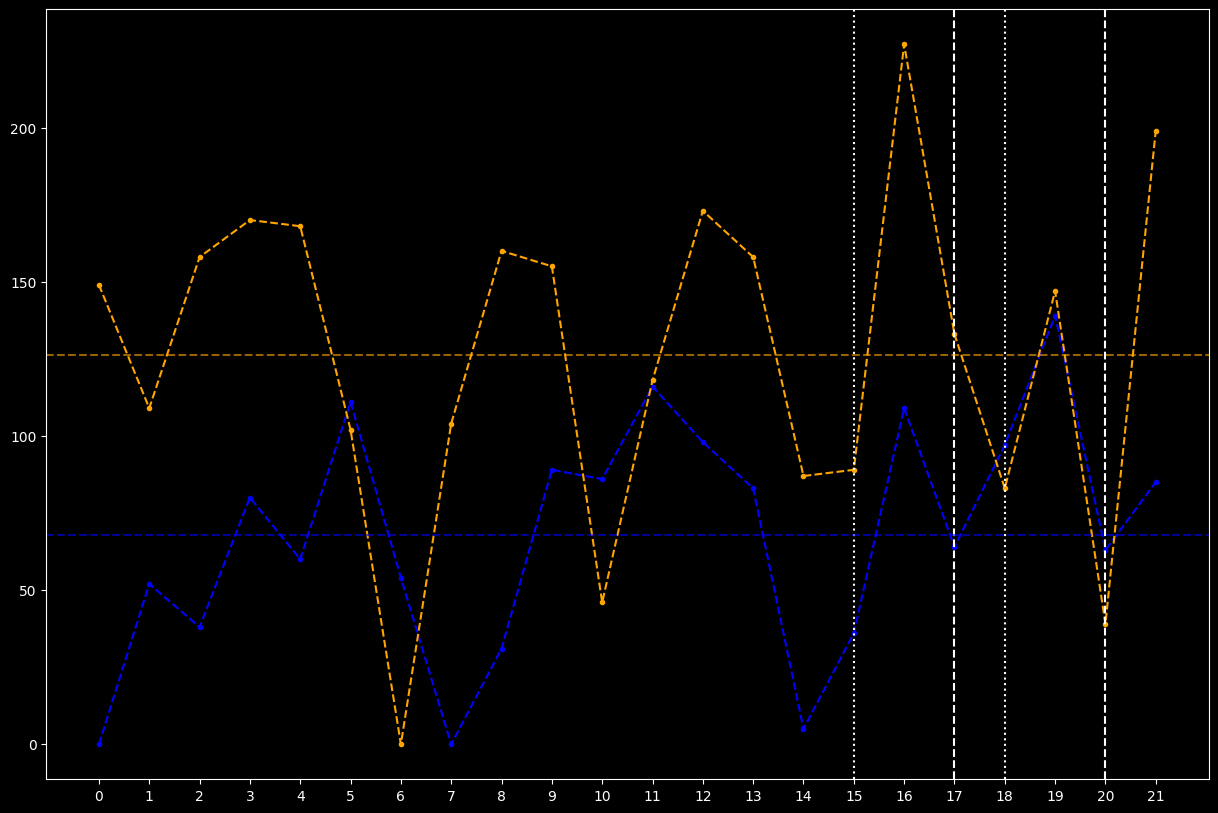

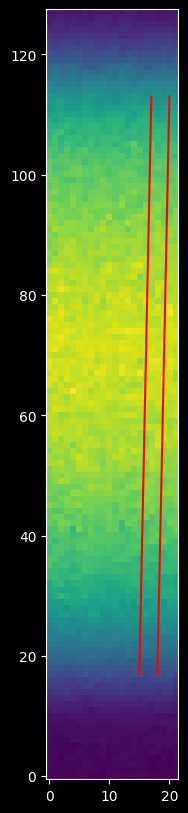

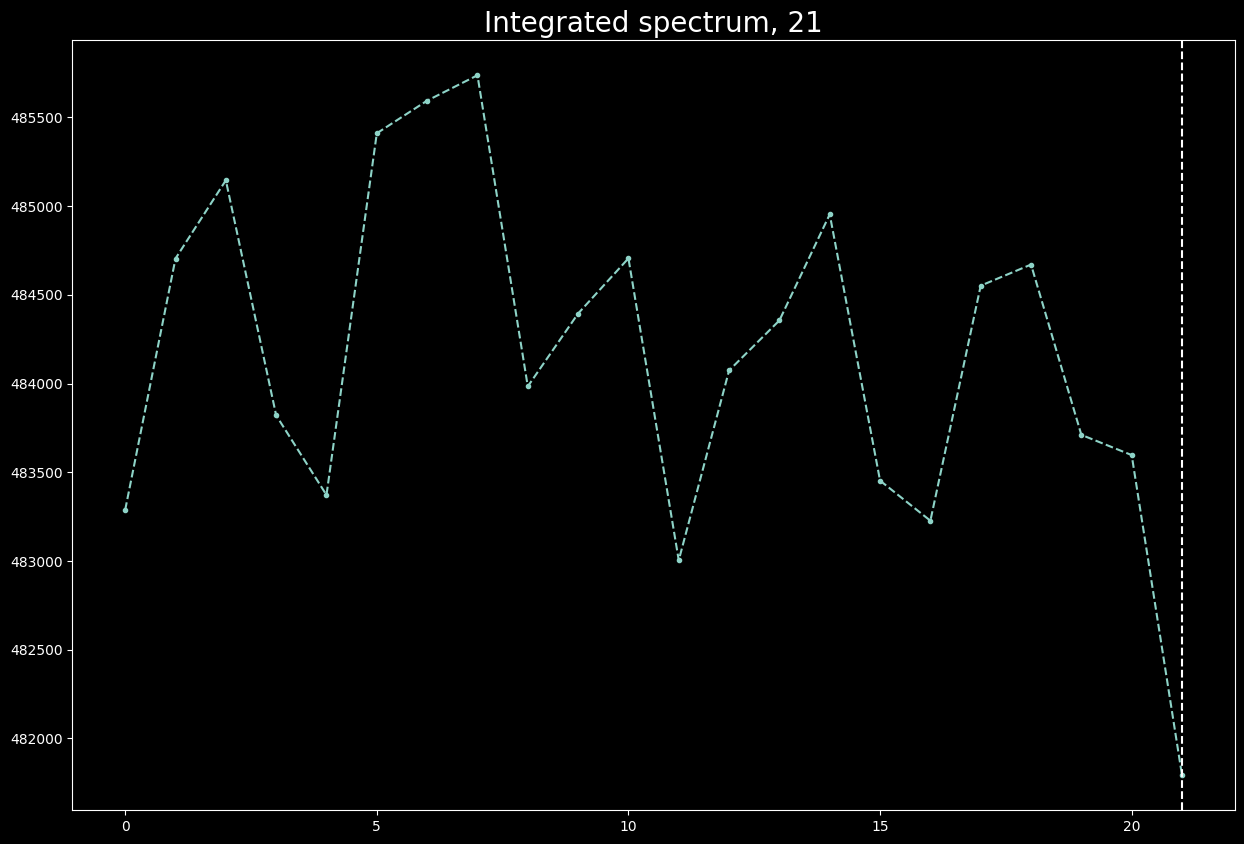

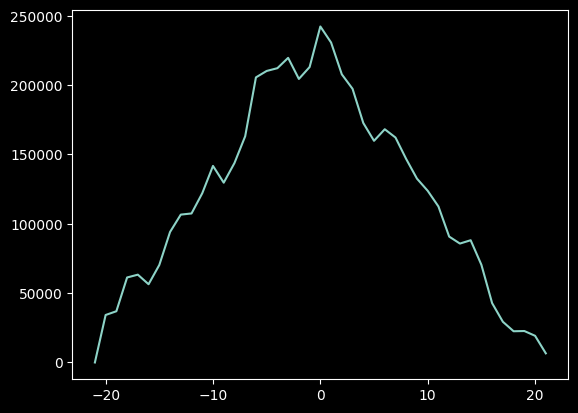

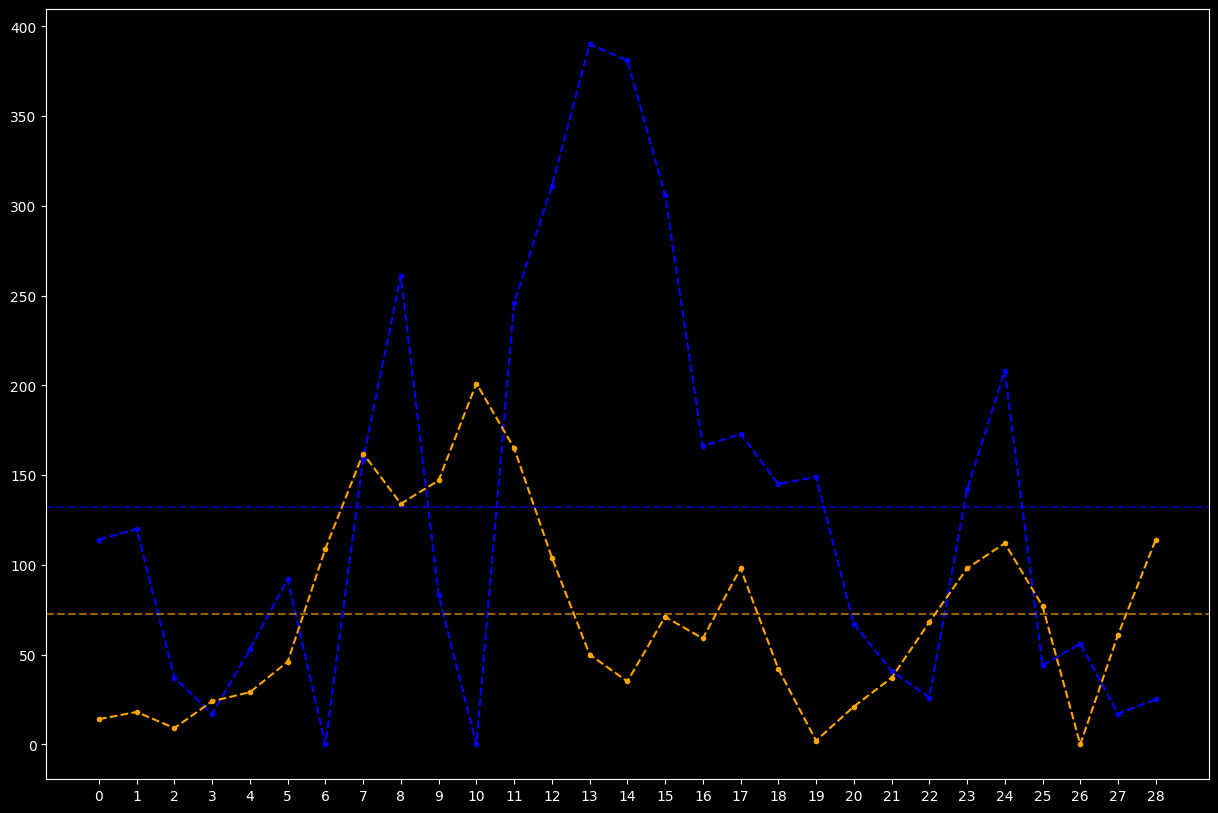

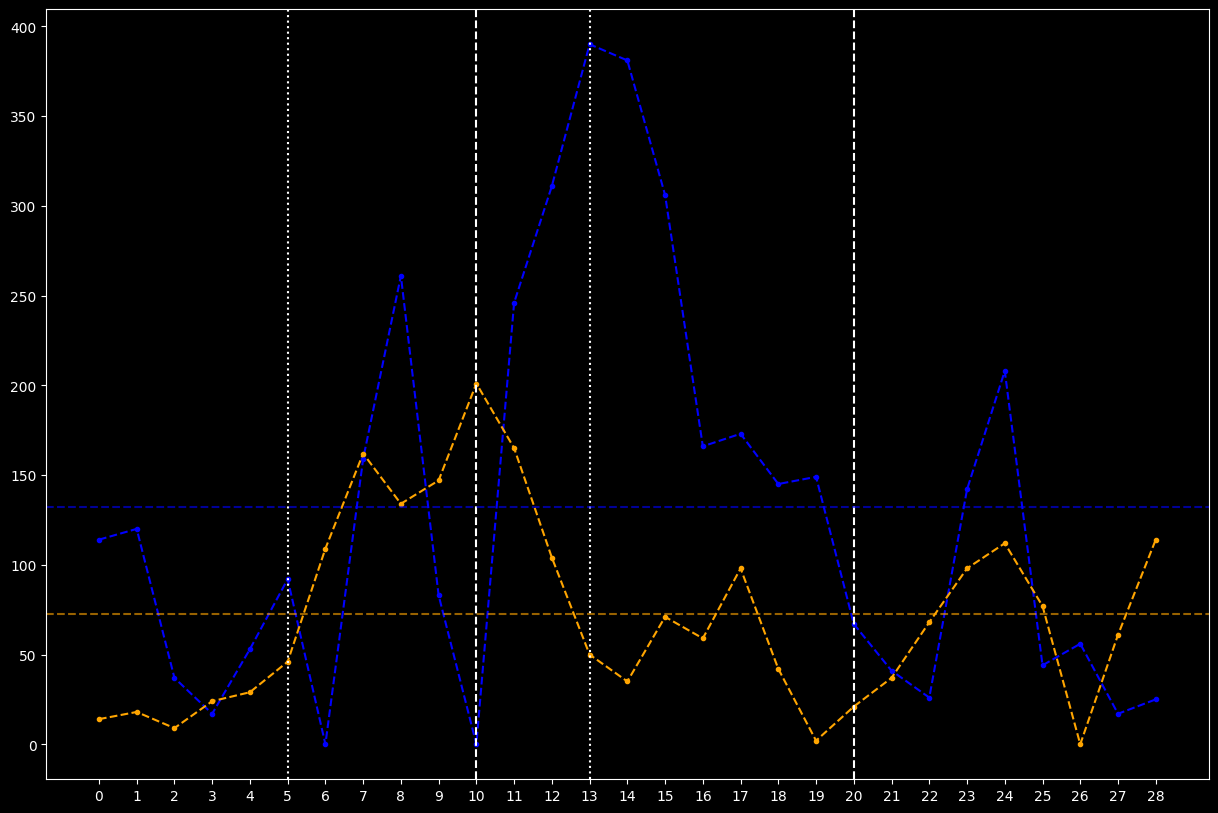

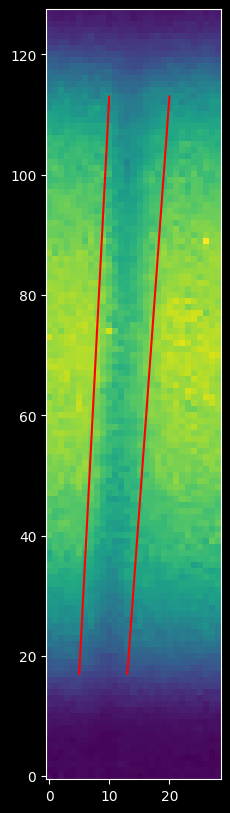

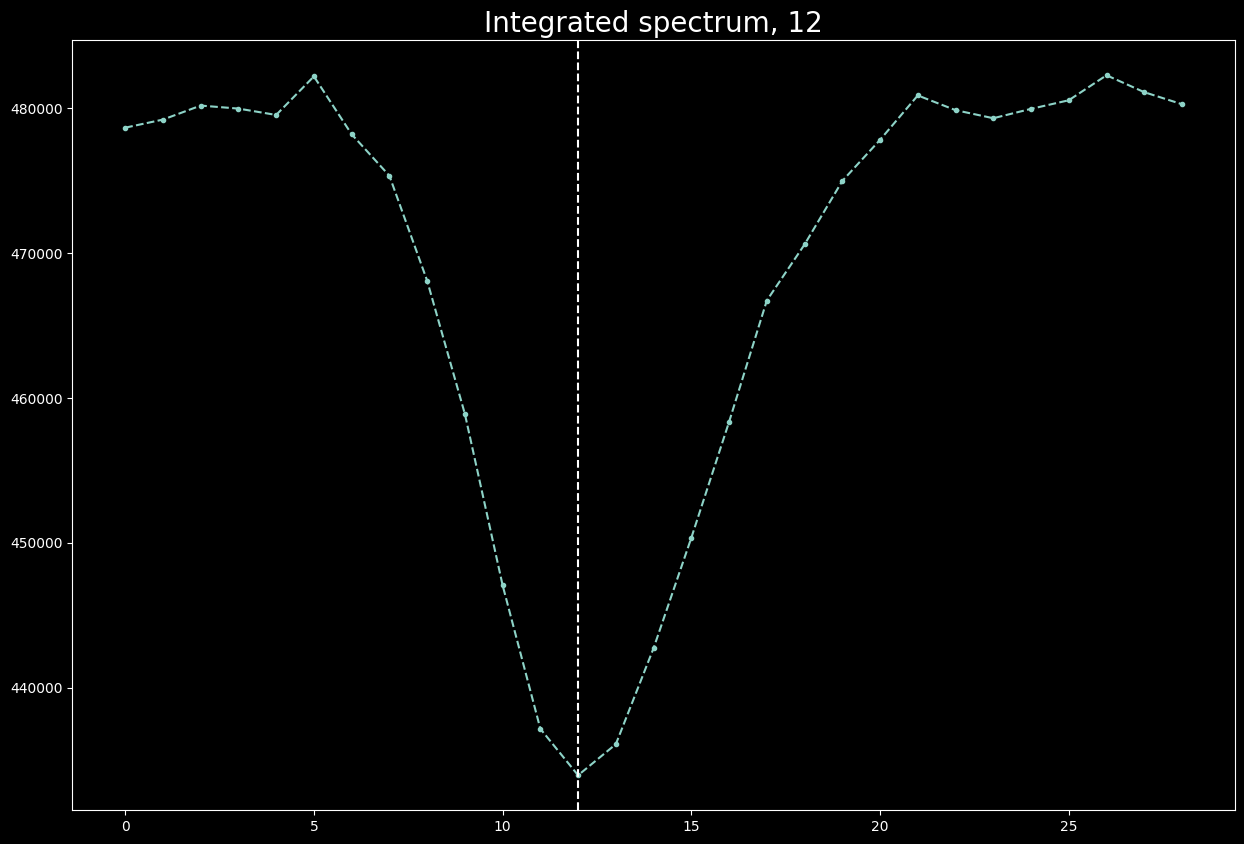

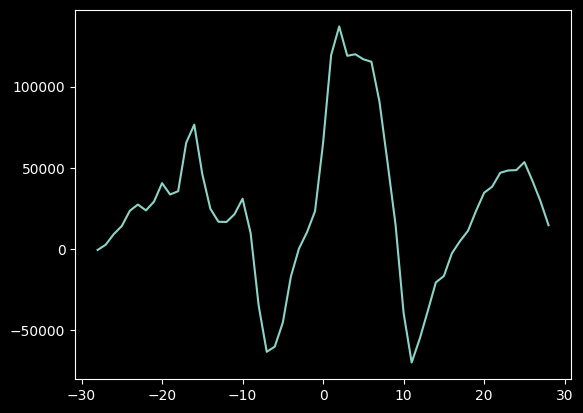

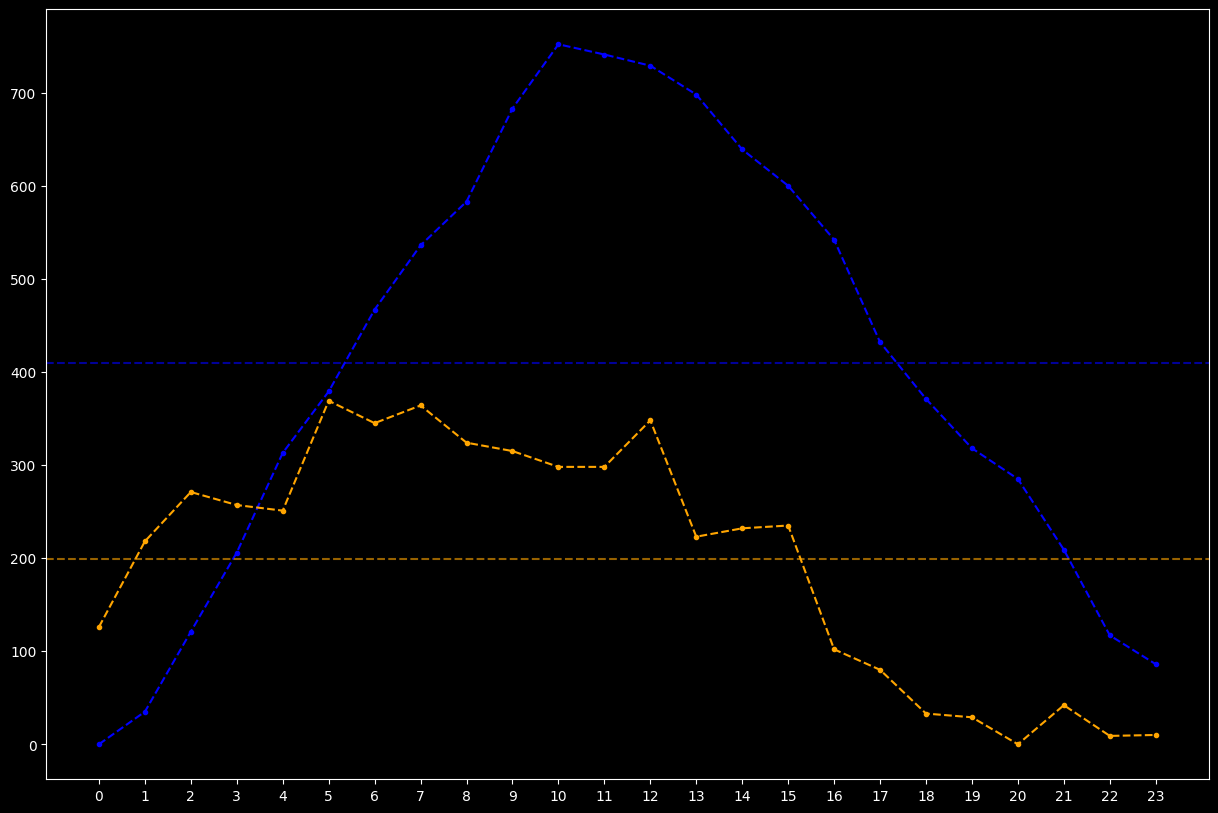

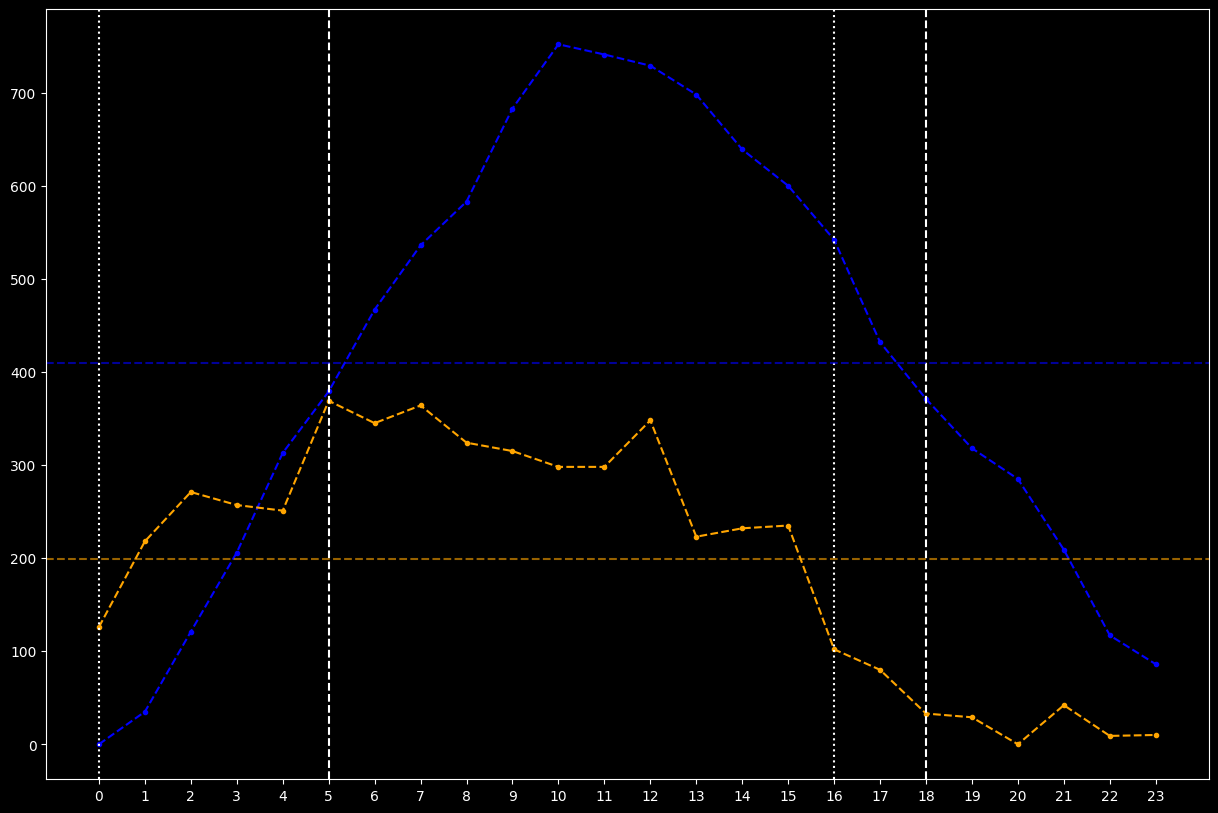

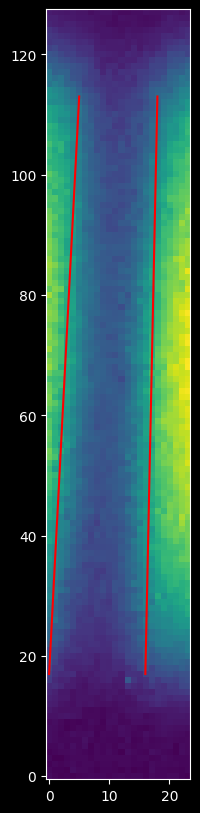

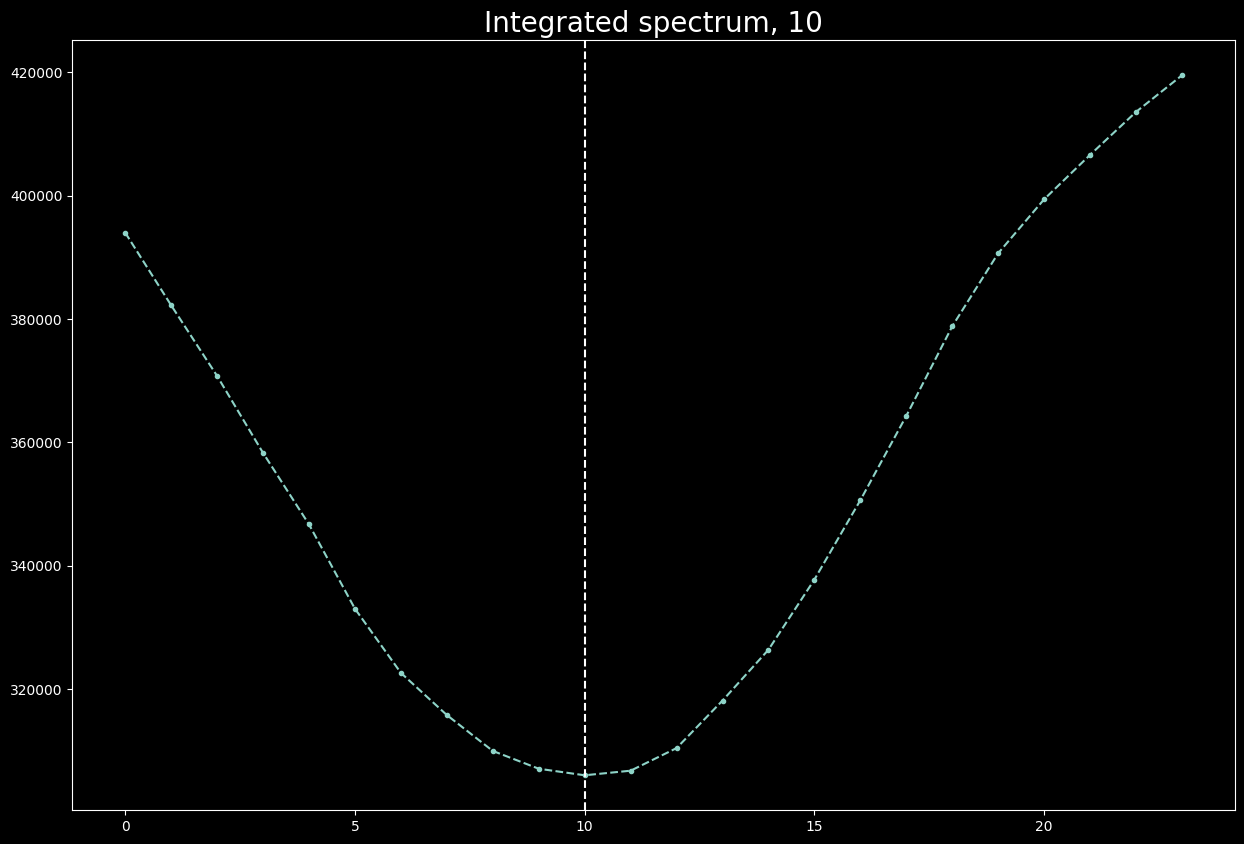

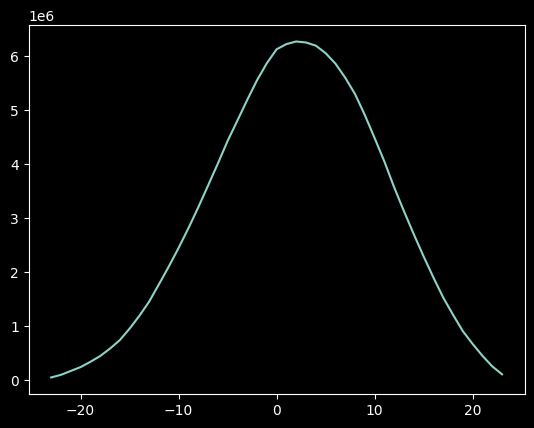

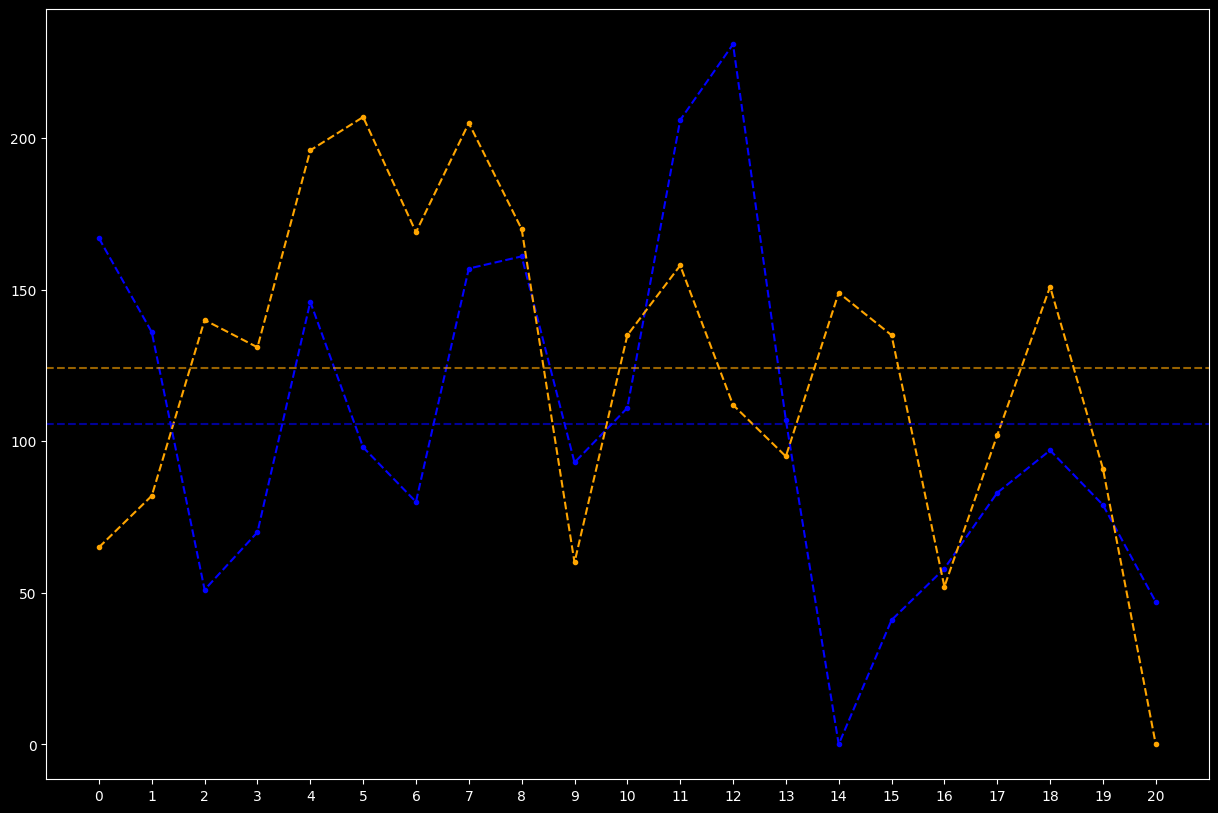

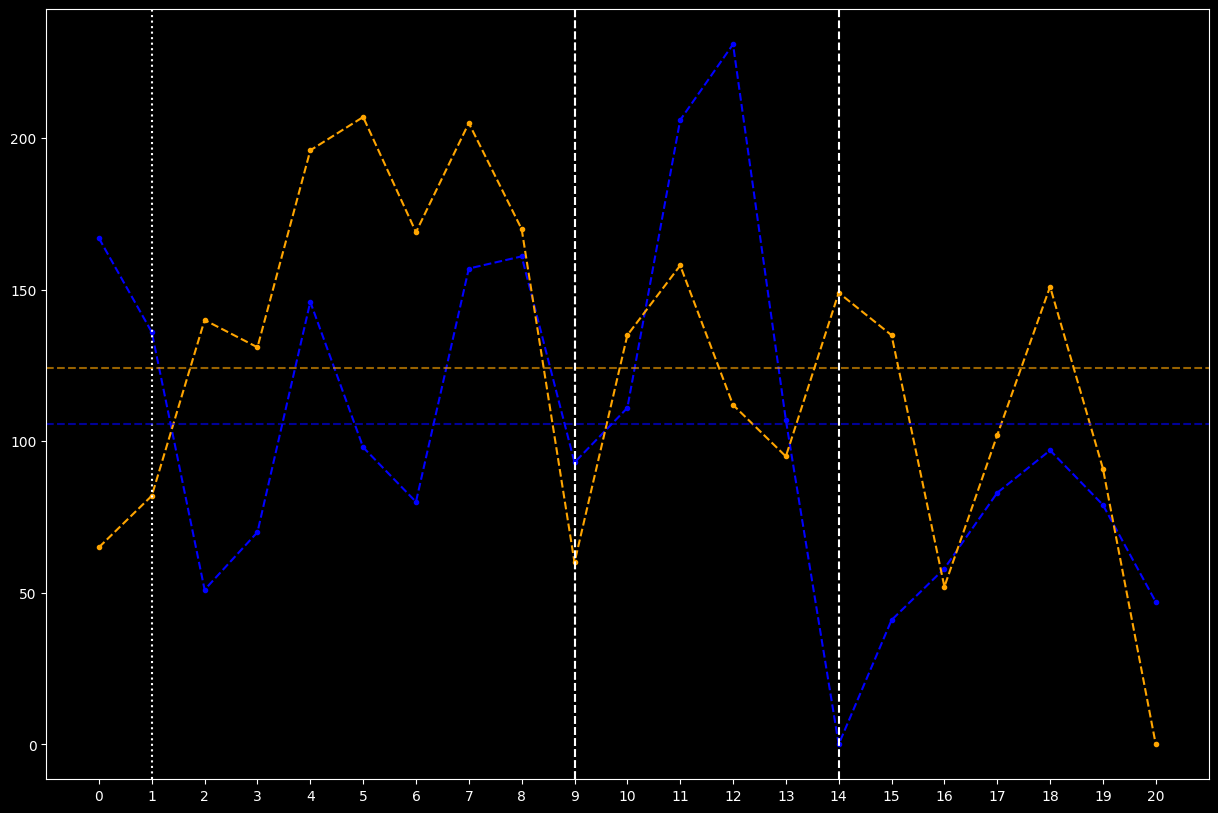

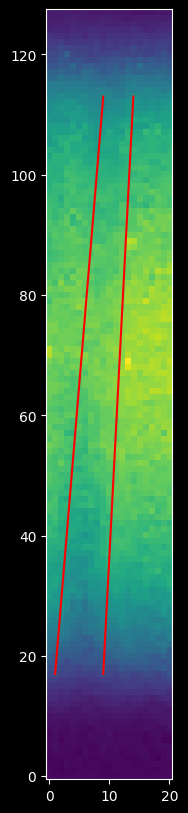

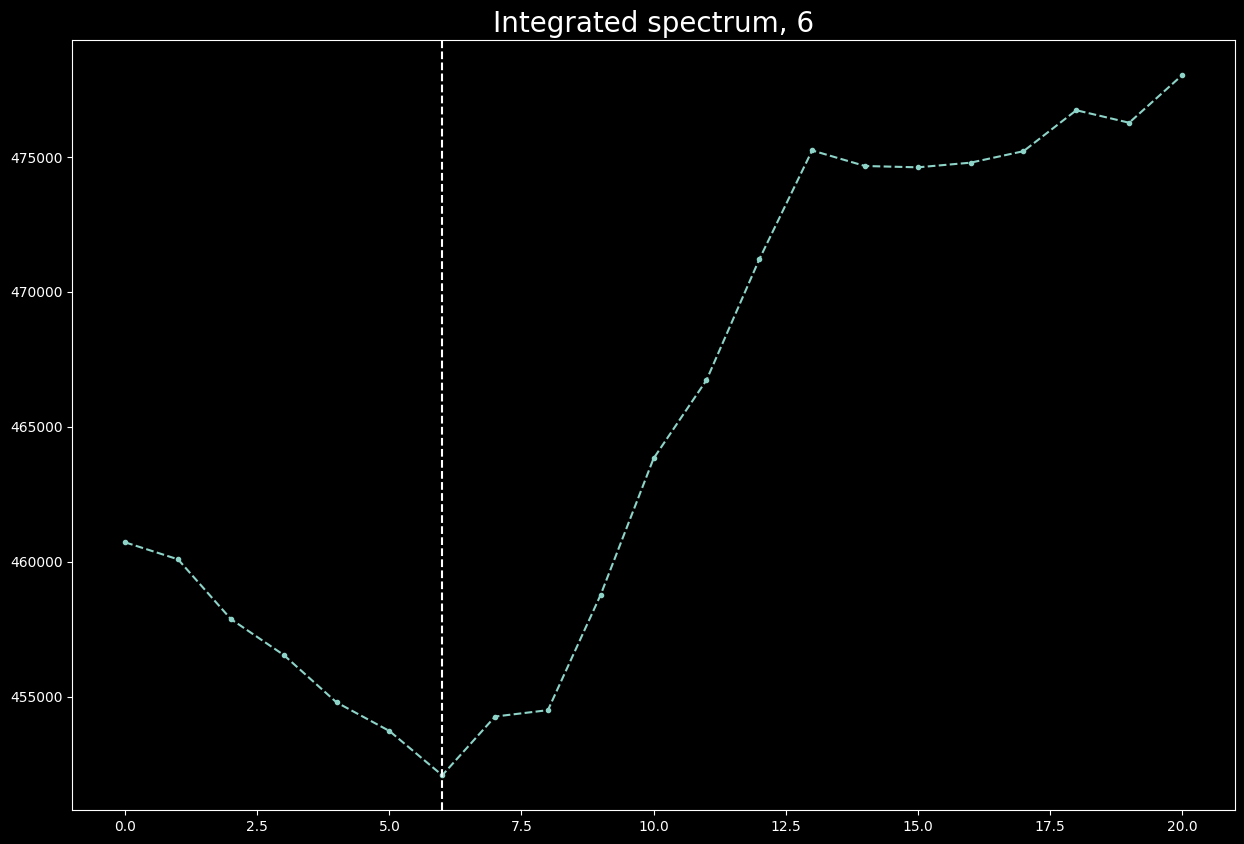

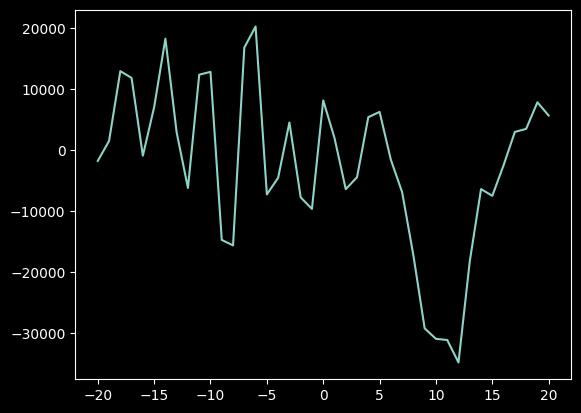

In [15]:
def find_minimum(values, avg: float, dir: str):
    pos = values.argmax()
    step = -1 if dir == 'left' else +1
    while values[pos] > avg:
        pos += step
        if pos == 0 or pos == len(values):
            break
    return pos

fit.infos()
print(fit.res['cov'])
print(mf,Dmf,qf,Dqf)
cut_list = [(232,257),(428,450),(570,595),(598,620),(676,705),(886,910),(1184,1205)]
cut_list = [ (lamp.data.shape[1]-i[1],lamp.data.shape[1]-i[0]) for i in cut_list]
# sel_cut = (885,910)
plt.figure(figsize=(15,10))
plt.imshow(data,origin='lower',cmap='gray')
for sel_cut in cut_list: 
    plt.axvline(sel_cut[0],0,1,color='w',linestyle='dashdot')
    plt.axvline(sel_cut[1],0,1,color='w',linestyle='dashdot')

est_ps = []
incl = []
centr = np.array([])
corr_shifts = np.array([])
for sel_cut in cut_list: 
    print('\n- - -\nValue for',sel_cut)
    sh = 0
    p1 = data[px_u+sh,slice(*sel_cut)]
    p2 = data[px_d-sh,slice(*sel_cut)]
    av1 = p1.max() - np.mean(data[px_u+sh])
    av2 = p2.max() - np.mean(data[px_d-sh])
    p1 = p1.max()-p1    
    p2 = p2.max()-p2    
    x1 = np.arange(len(p1))    
    x2 = np.arange(len(p2))    
    mp1 = p1.mean()
    mp2 = p2.mean()

    # plt.figure(figsize=(15,10))
    # plt.imshow(data[:,slice(*sel_cut)],origin='lower')
    # plt.axhline(px_u+sh,0,1)
    # plt.axhline(px_d-sh,0,1)

    plt.figure(figsize=(15,10))
    plt.plot(x1,p1,'.--',color='b')
    plt.plot(x2,p2,'.--',color='orange')
    plt.axhline(mp1,0,1,linestyle='dashed',color='b',alpha=0.6)
    plt.axhline(mp2,0,1,linestyle='dashed',color='orange',alpha=0.6)
    plt.xticks(x1,x1)

    ends1 = (find_minimum(p1,mp1,'left'),find_minimum(p1,mp1,'right'))
    ends2 = (find_minimum(p2,mp2,'left'),find_minimum(p2,mp2,'right'))
    compute_m = [(px_u - px_d) / (ends1[0]-ends2[0]),(px_u - px_d) / (ends1[1]-ends2[1])]
    print('inclination:\t',compute_m[0],'\t',compute_m[1])
    incl += [np.mean(compute_m)]

    if p1.argmax() > p2.argmax():
        right = find_minimum(p1,mp1,'right')
        left  = find_minimum(p2,mp2,'left')
    elif p1.argmax() < p2.argmax():
        right = find_minimum(p2,mp2,'right')
        left  = find_minimum(p1,mp1,'left')
    else:
        break

    print(left,right)
    print(right-left)
    shift3 = abs(right-left)
    plt.figure(figsize=(15,10))
    plt.plot(x1,p1,'.--',color='b')
    plt.plot(x2,p2,'.--',color='orange')
    # plt.axvline(left,0,1)
    # plt.axvline(right,0,1)
    plt.axvline(ends1[0],0,1,linestyle='dashed')
    plt.axvline(ends1[1],0,1,linestyle='dashed')
    plt.axvline(ends2[0],0,1,linestyle='dotted')
    plt.axvline(ends2[1],0,1,linestyle='dotted')
    plt.axhline(mp1,0,1,linestyle='dashed',color='b',alpha=0.6)
    plt.axhline(mp2,0,1,linestyle='dashed',color='orange',alpha=0.6)
    plt.xticks(x1,x1)

    plt.figure(figsize=(15,10))
    plt.imshow(data[:,slice(*sel_cut)],origin='lower')
    plt.plot([ends2[0],ends1[0]],[px_d-sh,px_u+sh],color='red')
    plt.plot([ends2[1],ends1[1]],[px_d-sh,px_u+sh],color='red')

    int_spec = np.sum(data[:,slice(*sel_cut)],axis=0)
    minpos = np.argmin(np.sum(data[:,slice(*sel_cut)],axis=0)) + sel_cut[0] + cp_jup.lims[2]
    minval = fit.method(minpos)
    print(minval)
    centr = np.append(centr,[minval])
    plt.figure(figsize=(15,10))
    plt.title(f'Integrated spectrum, {np.argmin(int_spec)}',fontsize=20)
    plt.plot(int_spec,'.--')
    plt.axvline(np.argmin(int_spec),0,1,linestyle='dashed')

    new_corr = correlate(p1-av1,p2-av2,mode='full')
    # new_corr = correlate(p1-mp1,p2-mp2,mode='full')
    new_lag = correlation_lags(len(p1),len(p2))
    corr_shifts = np.append(corr_shifts,[abs(new_lag[new_corr.argmax()])])
    plt.figure()
    plt.plot(new_lag,new_corr)


    # 8pi R/C (min+q/m)/sh
    # 8pi R/C/sh [Dmin + Dq/m + qDm/m² + sqrt(2q/m³) Cov ]
    # 8pi R/C [ (Dq/m)² + (q*Dm/m²)² + 2 q/m³ Cov] / sh
    # T [ (Dq/q) + (Dm/m) + 2Cov/qm ]
    T3 = (8*np.pi*R/C * minval/(shift3*mf)).to(u.h)
    DT3 = (T3-(8*np.pi*R/C*minpos/shift3).to(u.h)) * np.sqrt((Dmf/mf)**2+(Dqf/qf)**2+2*fit.res['cov'][0,1]/mf/qf)
    # DT3 = (T3-8*np.pi*R/C*minpos/shift3).to(u.h) * np.sqrt((Dmf/mf)**2+(Dqf/qf)**2)
    print(C*(shift3*mf)/minval/4)
    print(T3,DT3,DT3/T3*100)
    print(PERIOD)
    print((T3-PERIOD))
    print((T3-PERIOD)/DT3)
    est_ps += [T3.value]
est_ps, std_ps = spc.mean_n_std(est_ps)
print('\n\n= = =\n')
print(est_ps,std_ps,std_ps/est_ps*100)
if (est_ps-std_ps) <= PERIOD.value <= (est_ps+std_ps): 
    print('OK')
else:
    print((est_ps-PERIOD.value)/std_ps*100)


ANGLES [ 80.09419446 -80.09419446 -81.15818544  88.80651058  86.52276103
  88.29527168  86.33221194]
SHIFTS [16.76470588 16.76470588 14.93333333  2.          5.83333333  2.85714286
  6.15384615]
PERIODS [ 8.19160068  8.17015045  9.15795093 68.36022118 23.41096231 47.67676328
 22.05474938] h --> 26.717485457757675
PERIODS2 [         inf 136.97016927  19.53696197          inf  68.28197341
  68.10966183  22.62025578] h --> 19.536961973494638


/home/bernardo/.local/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


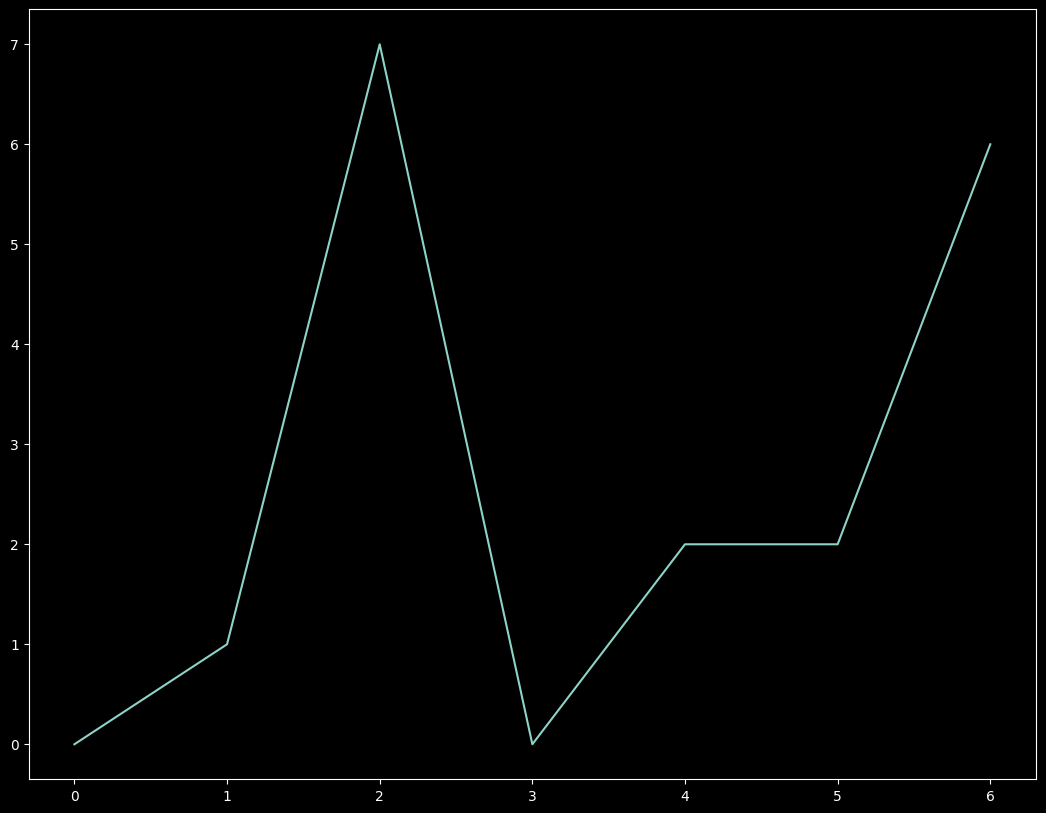

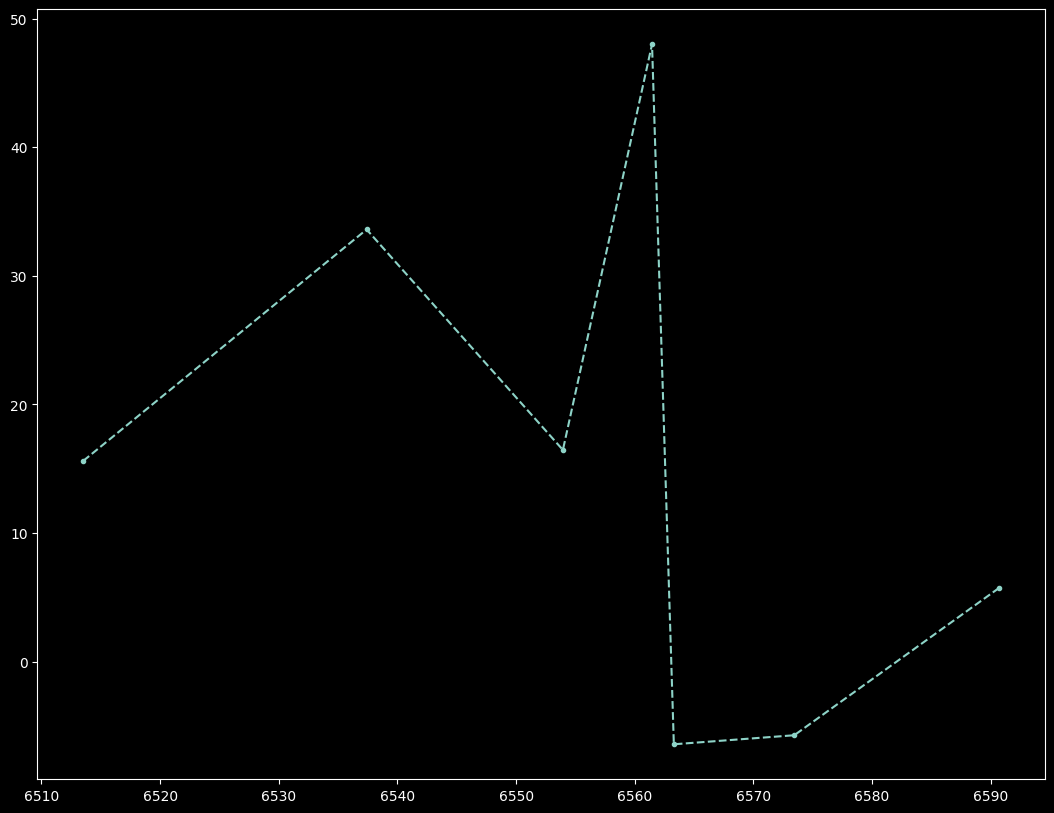

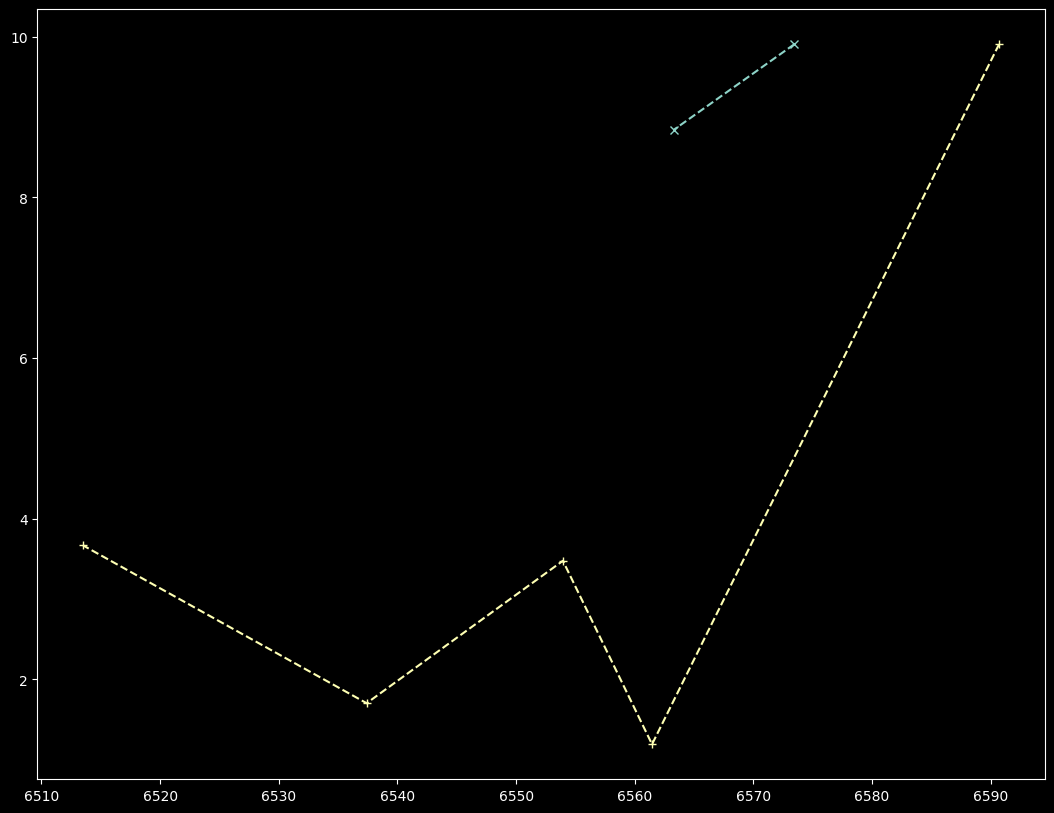

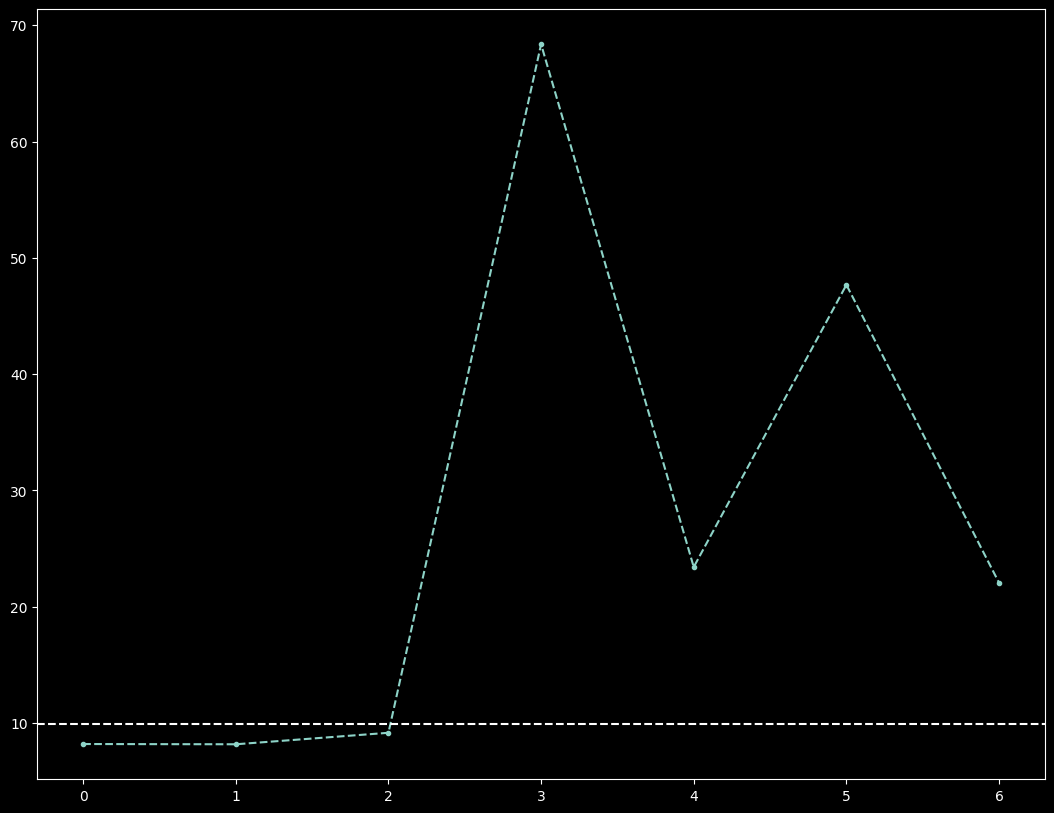

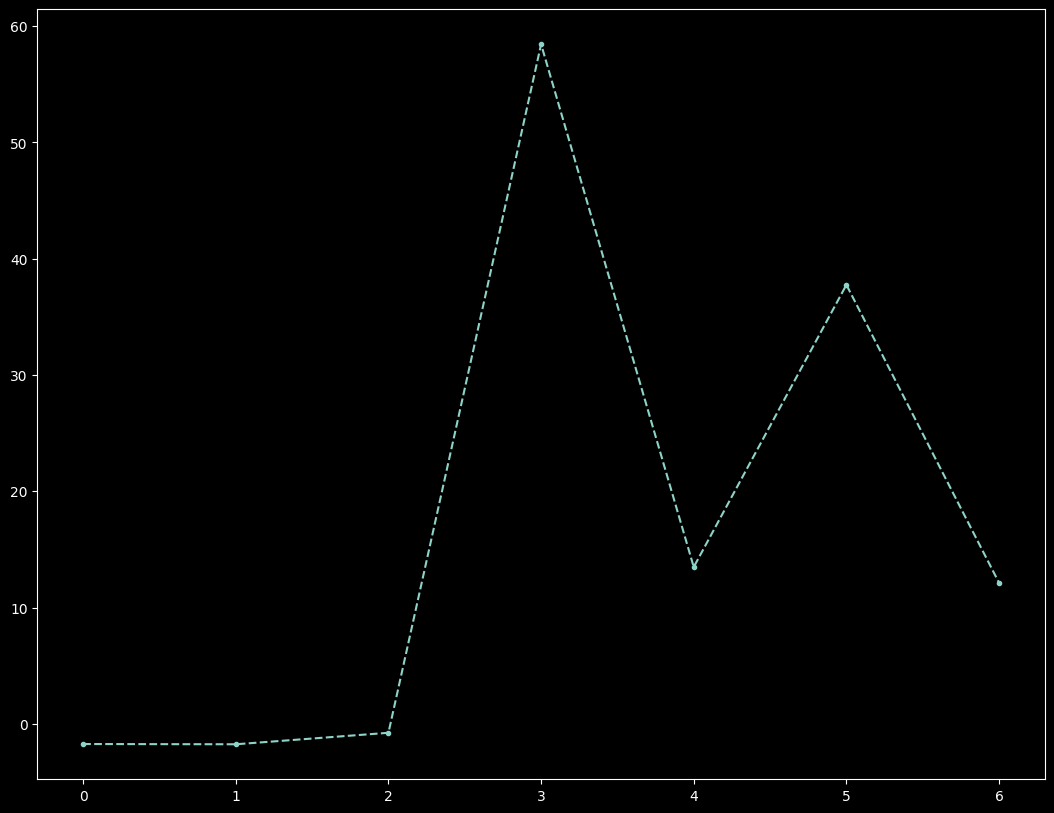

In [16]:

incl = np.array(incl)
angs = np.arctan(incl)*180/np.pi
print('ANGLES',angs)
xx = abs((px_u-px_d)/incl)
print('SHIFTS',xx)
periods = (8*np.pi*(R/C)*centr/(xx*mf)).to(u.h) 
corr_per = (8*np.pi*(R/C)*centr/(corr_shifts*mf)).to(u.h) 
print('PERIODS',periods,'-->',np.mean(periods.value))
print('PERIODS2',corr_per,'-->',np.mean(corr_per[corr_per.value<20].value))
plt.figure(figsize=(13,10))
plt.plot(corr_shifts)
plt.figure(figsize=(13,10))
plt.plot(centr,incl,'.--')
plt.figure(figsize=(13,10))
plt.plot(centr[angs<0],90+angs[angs<0],'x--')
plt.plot(centr[angs>0],90-angs[angs>0],'+--')
plt.figure(figsize=(13,10))
plt.plot(periods.value,'.--')
plt.axhline(PERIOD.value,0,1,linestyle='dashed')
plt.figure(figsize=(13,10))
plt.plot((periods-PERIOD).value,'.--')
plt.show()

9404.0
[13277, 6, 4]
curve_fit
XERR None

Fit results:
	mode : curve_fit
	k: 1.287e+04 +/- 2.6e+02  -->  2.06 %	init : 1.3e+04
	mu: 5.02e+00 +/- 1.3e-01  -->  2.51 %	init : 6.0
	sigma: 4.67e+00 +/- 2.1e-01  -->  4.40 %	init : 4.0
	corr_k-mu	 = -0.0034
	corr_k-sigma	 = -0.68
	corr_mu-sigma	 = 0.0076
857.0173803877258 1387
976.8969859800898 km / s 7.003323465112797 km / s
9.722725625020795 km / s 4.318866454010313 km / s
68.27753845509824 h


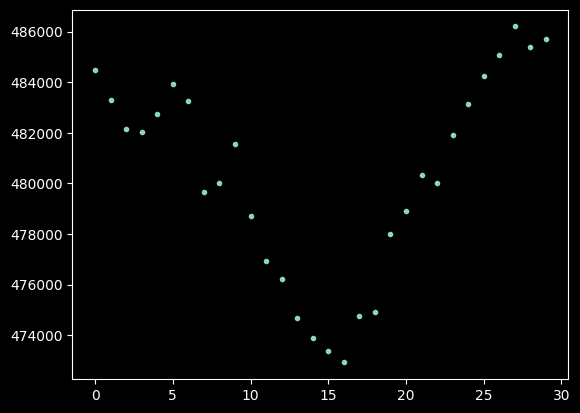

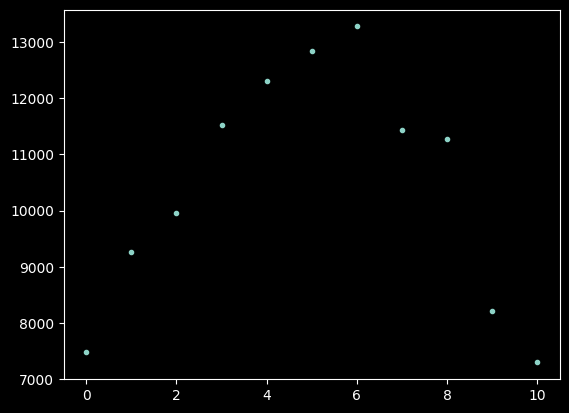

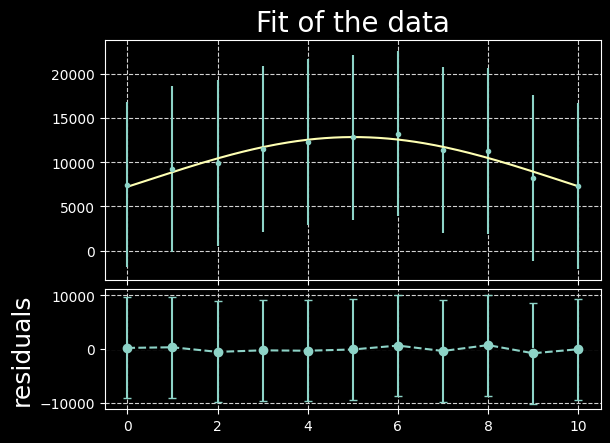

In [17]:
int_data = data.sum(axis=0)
max_disp = (data.max()-data.min())/2
print(max_disp)
int_minpos = int_data.argmin() + cp_jup.lims[2]
int_minval = fit.method(int_minpos)
fit_data = int_data[800:830]
plt.figure()
plt.plot(fit_data,'.')
fit_data = fit_data.max()-fit_data[10:21]
plt.figure()
plt.plot(fit_data,'.')
fit_xx = np.arange(len(fit_data))
hm = fit_data.max()/2
hm_pos = np.argmin(abs(fit_data-hm))
hwhm = abs(fit_data.argmax()-hm_pos)
initial_values = [fit_data.max(),fit_data.argmax(),hwhm]
print(initial_values)
gfit = spc.FuncFit(fit_xx,fit_data,max_disp)
gfit.gaussian_fit(initial_values,mode='curve_fit')
gfit.plot(mode='subplots')

print(gfit.fit_par[1]+cp_jup.lims[2]+810,int_minpos)
val_lam = fit.method(gfit.fit_par[1]+cp_jup.lims[2]+810)
print(C.to(u.km/u.s)*(fit.method(int_minpos)-BALMER)/BALMER/2, C.to(u.km/u.s)/BALMER/2 * np.sqrt((Dmf*int_minpos)**2 + Dqf**2 + 2*fit.res['cov'][0,1]*int_minpos) )
print(C.to(u.km/u.s)*(val_lam-BALMER)/BALMER/2, C.to(u.km/u.s)/BALMER/2 * np.sqrt((Dmf*(gfit.fit_par[1]+cp_jup.lims[2]+810))**2 + Dqf**2 + 2*fit.res['cov'][0,1]*(gfit.fit_par[1]+cp_jup.lims[2]+810)) )
T3 = (8*np.pi*R/C * (centr[-3]-(val_lam-BALMER))/(corr_shifts[-3]*mf)).to(u.h)
# T3 = (8*np.pi*R/C * (minval-(fit.method(857)-BALMER))/(shift3*mf)).to(u.h)
# DT3 = (T3-(8*np.pi*R/C*minpos/shift3).to(u.h)) * np.sqrt((Dmf/mf)**2+(Dqf/qf)**2+2*fit.res['cov'][0,1]/mf/qf)
print(T3)
plt.show()